# Import libraries

In [1]:

import pandas as pd
import numpy as np
from scipy import stats
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib

# keras with tensorflow
import keras
# set the random seed
np.random.seed(35)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import metrics

# import seaborn
import seaborn as sns

# umap library
import umap

# sklearn libraries for the encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn import svm

# data split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# imbalance learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

matplotlib.rcParams.update({'font.size': 15})


Using TensorFlow backend.
/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Anatoly

In [2]:
# change the figure properties to make sure they have changed

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

matplotlib.rcParams.update({'font.size': 20})


# Read human dataset

### human ephys

In [23]:

ephys_human = pd.read_csv('human_MET_ephys_scaling.csv')

ephys_human.head(5)


spec_id_label  threshold_index_rheobase  trough_t_short_square        tau  \
0      539532683                     89841               0.745700  12.404046   
1      539537044                     73771               0.738660  12.742015   
2      539541521                     35842               1.024947  13.211400   
3      539634808                     58962               1.082222  20.628605   
4      539642974                     63199               0.507427  20.790816   

   peak_v_short_square  upstroke_scaling  upstroke_index_scaling  \
0           -14.343751         -0.816665              -97.728233   
1           -19.781250          1.194837              616.296866   
2            32.802082         -0.139734             -361.723202   
3             3.520833         -0.508379              -53.403292   
4            15.750000          0.285430              -87.578332   

   trough_t_scaling  adaptation  peak_t_index_scaling  ...  peak_t_rheobase  \
0         -0.002006    0.007846             -0.001954  ...          1.27734   
1          0.008801         NaN              0.008327  ...          0.95584   
2         -0.011648    0.008588             -0.007234  ...          0.19738   
3         -0.001182    0.016558             -0.001068  ...          0.65990   
4         -0.001762         NaN             -0.001752  ...          0.74440   

   downstroke_index_scaling  slow_trough_v_short_square  upstroke_t_scaling  \
0                -97.691763                         NaN           -0.001955   
1                616.412244                         NaN            0.008326   
2               -361.719720                         NaN           -0.007234   
3                -53.439392                         NaN           -0.001068   
4                -87.590071                         NaN           -0.001752   

   slow_trough_t_scaling  slow_trough_index_rheobase  slow_trough_v_rheobase  \
0              -0.002957                     91175.0              -50.312504   
1               0.006907                     70897.0              -24.687500   
2              -0.015042                     37032.0              -66.656258   
3              -0.001440                     60139.0              -54.062504   
4              -0.002350                     62368.0              -66.343758   

   slow_trough_v_scaling  slow_trough_index_scaling  slow_trough_t_rheobase  
0               0.114625                -147.862989                 1.30350  
1              -0.189893                 545.329270                 0.89794  
2               0.052344                -752.100000                 0.22064  
3               0.151977                 -72.005332                 0.68278  
4               0.007813                -117.503676                 0.72736  

[5 rows x 95 columns]

# Read the patch seq dataset and select cells only from MTG

## Filter the patch-seq cells by MTG only

In [14]:

seq_human = pd.read_csv('human_distillery_selection_new.csv')
seq_human.head(5)

# make a filter to find cells only from one brain area

print('unique patch seq labels')
print(seq_human['patchseq_roi_label'].unique())


# create the array of zeros
temporal_labels=np.zeros(len(seq_human))

# coding for temporal lobe
# 1 - temporal lobe,0 - not temporal lobe

# create the list for diseases
for i in range(len(seq_human)):
    file_name=seq_human['patchseq_roi_label'].iloc[i]
    
    # code for temporal ones
    
    if file_name != np.nan:
        
        # safety check for float
        if type(file_name) != float:
    
            if 'TC' in file_name:
                temporal_labels[i]=1

            if 'temporal' in file_name:
                temporal_labels[i]=1

# find the values of 0s
temporal_args = np.argwhere(temporal_labels == 1)

non_zero_idx=np.nonzero(temporal_labels == 1)
non_zero_idx=non_zero_idx[0]

# filter the dataset
seq_human=seq_human.iloc[non_zero_idx,:]

unique patch seq labels
['TCx1' 'TCx3' 'TCx2' 'TCx4' 'FCx2' 'Tcx' 'TCxL1'
 'Right frontal (~area 46)' 'FCx3' '0' 'FCx1' 'Right anterior temporal'
 'Right frontal' 'Left temporal' 'Right temporal' 'temporal' 'FCx4'
 'TCx3a' 'TCx5' 'TCx3c' 'HIPbCA1' 'TCx3b' 'TCxL3' 'HIPbCA2' 'HIPbCA3'
 'HIPbDG' 'TCx2/3' 'FCxL5' 'FCx5' 'Left frontal' 'TCxL2' 'OCx4' 'CB'
 'FCx3a' 'ZZ_Missing' 'OCx2' 'OCx3' 'TCxL5' nan 'dLGNShell' 'OCx3c' 'FCx6'
 'TEaL5' 'FCxL4' 'TCx6' 'TCxL4' 'MOp5' 'PCx4' 'OCx3a' 'OCx3b' 'VISp2/3'
 'FCxL2' 'FCx3c' 'TEa1' 'FCxL3' 'FCxL1' 'TEaL2-3' 'insula' 'TEa5' 'VISp5'
 'transverse gyrus insula']


## Take only cells with good NMS score

In [15]:

seq_human=seq_human.loc[seq_human['Norm_Marker_Sum.0.4_label'] == True]


## Take only cells from hIVSCC project

In [16]:

seq_human=seq_human.loc[seq_human['cell_specimen_project_label']=='hIVSCC-MET']


## Filter ephys cells by MTG only

In [17]:

# get the cell ids from the filtered dataset by patch-seq

MTG_cell_ids=seq_human['spec_id_label'].values

# use cell ephys only from MTG defined by patch-seq
ephys_human=ephys_human.loc[ephys_human['spec_id_label'].isin(MTG_cell_ids)]
ephys_human.head()

spec_id_label  threshold_index_rheobase  trough_t_short_square  \
170      650076115                     59399               0.600900   
171      650076320                     57553               0.524000   
172      650077366                    104295               0.519560   
173      650077581                     55329               0.905080   
175      650130090                     83085               1.389955   

           tau  peak_v_short_square  upstroke_scaling  upstroke_index_scaling  \
170  19.888895            28.312500          0.143409              -63.959088   
171  10.619282            35.328125          0.353417              -69.706815   
172  22.147690            32.320312          0.040435             -625.577387   
173  28.791926            45.640625          0.222479              -36.250001   
175  16.453116            33.695312          0.280648             -230.901750   

     trough_t_scaling  peak_t_index_scaling  trough_v_long_square  ...  \
170         -0.015694             -0.001279            -56.656254  ...   
171         -0.001395             -0.001394            -53.531250  ...   
172         -0.012532             -0.012512            -56.406254  ...   
173         -0.000737             -0.000725            -48.125004  ...   
175         -0.007001             -0.004618            -61.843754  ...   

     trough_v_scaling  downstroke_index_rheobase  fast_trough_index_rheobase  \
170          0.071023                    59443.0                     59572.0   
171          0.008239                    57582.0                     57636.0   
172         -0.009854                   104331.0                    104391.0   
173          0.004297                    55368.0                     55519.0   
175          0.209244                    83143.0                     83223.0   

     threshold_index_scaling  peak_t_long_square  peak_v_long_square  \
170               -63.952270             0.55698           30.531252   
171               -69.688633             0.63146           30.000002   
172              -625.599497             0.68442           35.750000   
173               -36.237501             0.58710           48.531254   
175              -230.769232             0.63560           33.375004   

     upstroke_v_scaling  peak_t_rheobase  downstroke_index_scaling  \
170           -0.033665          0.66854                -63.904543   
171           -0.020384          0.63146                -69.722724   
172            0.019095          1.56644               -625.592211   
173           -0.044531          0.58710                -36.287501   
175           -0.027753          1.14262               -230.919232   

     upstroke_t_scaling  
170           -0.001279  
171           -0.001394  
172           -0.012512  
173           -0.000725  
175           -0.004618  

[5 rows x 69 columns]

## Sort the ephys features by spec_id_label

In [18]:
# sort cells by specimen id
ephys_human=ephys_human.sort_values(by=['spec_id_label'])

print('Sorted specimen Ids in ephys features')
print(ephys_human['spec_id_label'].head())

Sorted specimen Ids in ephys features
170    650076115
171    650076320
172    650077366
173    650077581
175    650130090
Name: spec_id_label, dtype: int64


## Sort the patch-seq dataset by ephys specimen IDs

In [19]:
# get the cell specimen ids

cell_ids = ephys_human['spec_id_label'].values
cell_ids = cell_ids.astype(np.str)

print('These are the first 5 cell ids in ephys dataset')
print(ephys_human['spec_id_label'].values[:5])

These are the first 5 cell ids in ephys dataset
[650076115 650076320 650077366 650077581 650130090]


## Select the patch-seq cells only from ephys data

In [20]:

seq_human=seq_human[seq_human['spec_id_label'].isin(cell_ids)]
seq_human.head()

exp_component_name_id exp_component_name_label exp_component_name_color  \
0                    860      SM-GE4QD_S054_E1-50                  #58CC00   
1                    861      SM-GE4QD_S055_E1-50                  #699945   
3                    873      SM-GE4QD_S067_E1-50                  #679945   
5                   2557      SM-GE672_S094_E1-50                  #D173FF   
6                   2083      SM-GE5TO_S161_E1-50                  #2651FF   

   layer_id layer_label layer_color  batch_id batch_label batch_color  \
0         2           1     #CC5A3D       131     RSC-205     #CC1F9D   
1         2           1     #CC5A3D       131     RSC-205     #CC1F9D   
3         2           1     #CC5A3D       131     RSC-205     #CC1F9D   
5         3           2     #994B17        79     RSC-139     #26DCFF   
6         9           4     #679945       100     RSC-169     #0300FF   

   cell_name_id  ... Tree_first_cor_id Tree_first_cor_color  \
0          2533  ...              2862              #FF1212   
1          2534  ...              2769              #FF1919   
3          2546  ...              1802              #FF5454   
5           382  ...              2356              #FF3030   
6           879  ...              2814              #FF1616   

   Tree_second_cor_id Tree_second_cor_color Tree_third_cor_id  \
0                2426               #FF3C3C              2636   
1                2434               #FF3B3B              2479   
3                1780               #FF7B7B              2154   
5                2104               #FF5757              2245   
6                2524               #FF3535              2518   

   Tree_third_cor_color Tree_call_id Tree_call_color  Old_call_id  \
0               #FF4D4D            1         #FF7373            2   
1               #FF6363            1         #FF7373            2   
3               #FF8E8E            1         #FF7373            2   
5               #FF8181            1         #FF7373            2   
6               #FF5E5E            1         #FF7373            2   

  Old_call_color  
0        #85CC3D  
1        #85CC3D  
3        #85CC3D  
5        #85CC3D  
6        #85CC3D  

[5 rows x 250 columns]

## Arrange the patch-seq cells by cell ids

In [72]:
seq_human=seq_human.sort_values(by=['spec_id_label'])

print('Final patch-seq shape')
print(seq_human.shape)

Final patch-seq shape
(706, 250)


## Remove index features as redundant ones

In [73]:
# features

# drop index features
ephys_human = ephys_human.drop(['threshold_index_rheobase', 'threshold_index_scaling','peak_v_index_scaling','trough_index_rheobase','upstroke_index_scaling','fast_trough_t_index_scaling','peak_t_index_scaling','downstroke_index_scaling','trough_index_scaling','peak_index_rheobase','fast_trough_index_scaling','peak_index_index_scaling','downstroke_index_rheobase','fast_trough_index_rheobase','fast_trough_v_index_scaling','upstroke_index_rheobase'], axis=1)

# drop repeated features
ephys_human = ephys_human.drop(['upstroke_t_scaling','downstroke_t_scaling'] ,axis=1)

# drop non-relevant timing related features
ephys_human=ephys_human.drop(['trough_t_short_square','threshold_t_short_square','threshold_t_long_square','trough_t_long_square','fast_trough_t_long_square','peak_t_short_square','peak_t_long_square'], axis=1)

# remove all scaling featurs (except f-I curve)
ephys_human=ephys_human.drop(['upstroke_scaling','trough_t_scaling','upstroke_downstroke_ratio_scaling','downstroke_v_scaling','downstroke_scaling','width_scaling','threshold_t_scaling','threshold_v_scaling','trough_v_scaling','upstroke_v_scaling'], axis=1)

# remove the rheobase features
ephys_human=ephys_human.drop(['upstroke_v_rheobase','upstroke_t_rheobase','threshold_t_rheobase','width_rheobase','fast_trough_t_rheobase','downstroke_t_rheobase','downstroke_v_rheobase','downstroke_rheobase','peak_v_rheobase','upstroke_downstroke_ratio_rheobase','trough_t_rheobase','fast_trough_v_rheobase','threshold_v_rheobase','upstroke_rheobase','trough_v_rheobase','peak_t_rheobase'], axis=1)


In [74]:
# write down the feature names

feature_names = ephys_human.columns.values
print(len(feature_names))

44


## plot an exemplar feature

Text(0.5,0,'Values (ms)')

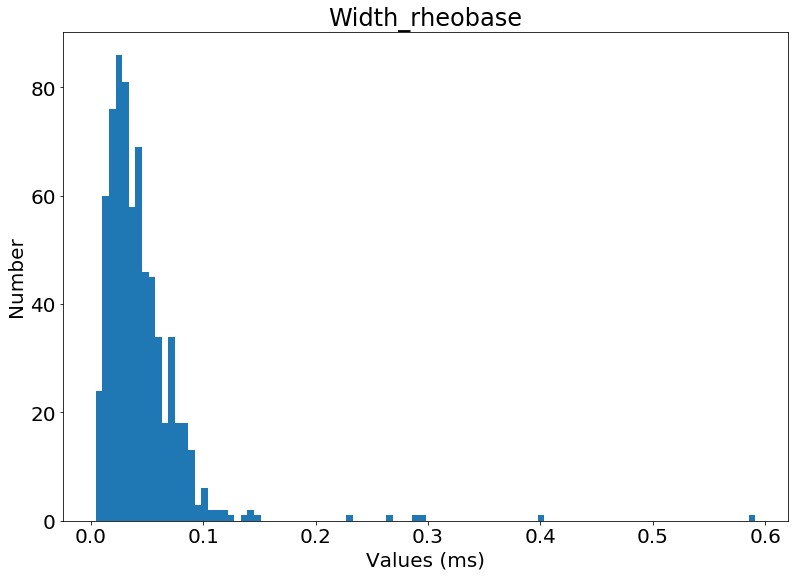

In [75]:
plt.hist(ephys_human['latency'],bins=100)
#plt.xlim([0,3])
plt.title('Width_rheobase')
plt.ylabel('Number')
plt.xlabel('Values (ms)')

### take only columns with no NaN's and remove the first column

In [76]:

ephys_human_no_nan=ephys_human.dropna(axis=1,how='any')
# take out the values
ephys_human_values=ephys_human_no_nan.values
# remove the first, spec id column
ephys_human_features=ephys_human_values[:,1:]

print('ephys features no-nan shape: ')
print(str(ephys_human_features.shape))


ephys features no-nan shape: 
(706, 17)


In [77]:
# save the feature names

feature_names = ephys_human_no_nan.columns.values
feature_names = feature_names[1:]
print(feature_names)


['tau' 'peak_v_short_square' 'trough_v_long_square'
 'threshold_v_short_square' 'threshold_i_long_square'
 'threshold_i_short_square' 'threshold_v_long_square'
 'trough_v_short_square' 'upstroke_downstroke_ratio_long_square'
 'f_i_curve_slope' 'vrest' 'upstroke_downstroke_ratio_short_square'
 'fast_trough_v_long_square' 'sag' 'latency' 'ri' 'peak_v_long_square']


### Clip the outliers by 2*sigma rule

In [78]:
# clip the array using numpy

lower_bound=np.mean(ephys_human_features,axis=0) - 2*np.std(ephys_human_features,axis=0)
upper_bound=np.mean(ephys_human_features,axis=0) + 2*np.std(ephys_human_features,axis=0)

ephys_human_features_clipped=np.clip(ephys_human_features,lower_bound,upper_bound)



### use the clipped data

In [79]:
# apply to the log tranformation

#ephys_human_features_log=np.log10(ephys_human_features - np.amin(ephys_human_features,axis=0) + 1)

ephys_human_features_log=ephys_human_features_clipped
#ephys_human_features


### Scale the input data after log

In [80]:
# scale the data (only values)
ephys_human_scaled=preprocessing.scale(ephys_human_features_log)
# perform ROBUST SCALER

#transformer = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=False).fit(ephys_human_features_log)

#ephys_human_scaled=transformer.transform(ephys_human_features_log)

print('Shape of the data:')
print(ephys_human_scaled.shape)
plt.imshow(ephys_human_scaled)


Shape of the data:
(706, 17)


In [84]:
# plot the first feature distribution

fig,ax=plt.subplots()

plt.hist(ephys_human_scaled[:,10],bins=50)
plt.title('Scaled&Clipped feature 10')


Text(0.5,1,'Scaled&Clipped feature 10')

Text(0.5,1,'Original feature 10')

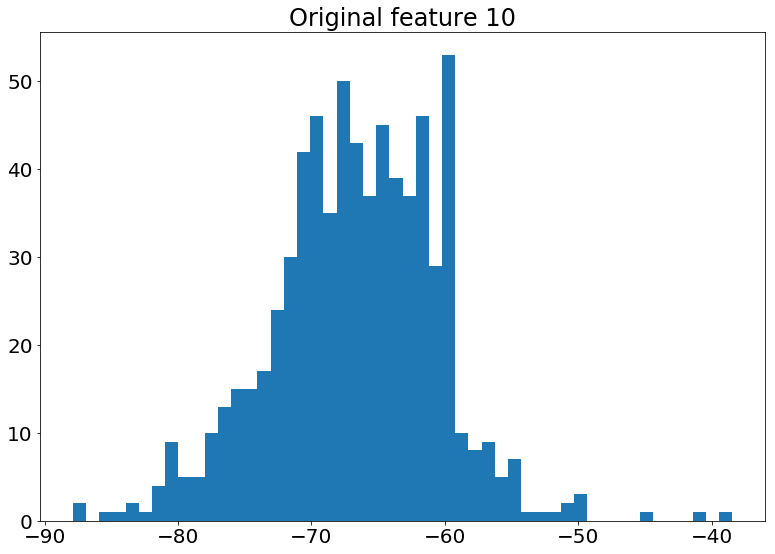

In [85]:
# raw data

#ephys_human_no_nan

plt.hist(ephys_human_features[:,10],bins=50)
plt.title('Original feature 10')



## Cluster call for cells

In [86]:

# human cell spec ids
human_cells_ids=ephys_human['spec_id_label'].values
human_cells_ids=human_cells_ids.tolist()
human_cells_ids=[ str(x) for x in human_cells_ids ]

# get the cluster names and labels, no NMS correction
#human_cells_labels=seq_human.loc[seq_human['spec_id_label'].isin(human_cells_ids)]['topLeaf_id'].values
#human_cells_label_names=seq_human.loc[seq_human['spec_id_label'].isin(human_cells_ids)]['topLeaf_label'].values

# get the cluster names and labels, NMS correction, top Leaf
#human_cells_labels=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['topLeaf_label'].values
#human_cells_label_names=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['topLeaf_label'].values

# get the cluster names and labels, NMS correction, SEURAT
human_cells_labels=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['seurat_cluster_label'].values
human_cells_label_names=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['seurat_cluster_label'].values


# get the cells, top_Leaf
#human_cells_cell_ids=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['topLeaf_label'].values

# get the cells, SEURAT
human_cells_cell_ids=seq_human.loc[(seq_human['spec_id_label'].isin(human_cells_ids))]['seurat_cluster_label'].values

print ('Labels for human cells: ' + str(len(human_cells_labels)) + ' cells')
print()
print (human_cells_labels)


Labels for human cells: 706 cells

['Exc L4-5 RORB FOLH1B' 'Inh L2-4 PVALB WFDC2' 'Inh L1-2 VIP LBH'
 'Exc L3-5 RORB FILIP1L' 'Inh L1-2 VIP TSPAN12' 'Exc L4-5 RORB FOLH1B'
 'Inh L1-4 VIP CHRNA6' 'Exc L2-3 LINC00507 FREM3' 'Exc L4-5 RORB FOLH1B'
 'Exc L4-6 RORB SEMA3E' 'Inh L2-6 LAMP5 CA1 (Igtp)' 'Exc L4-6 RORB SEMA3E'
 'Inh L1-3 SST CALB1' 'Inh L2-6 LAMP5 CA1 (Igtp)' 'Exc L2 LAMP5 LTK'
 'Exc L3-5 RORB ESR1' 'Inh L1 SST NMBR (ADARB2+)' 'Inh L2-4 PVALB WFDC2'
 'Inh L1 SST NMBR (ADARB2+)' 'Exc L2 LAMP5 LTK' 'Exc L2 LAMP5 LTK'
 'Exc L3-5 RORB ESR1' 'Exc L2-3 LINC00507 FREM3'
 'Inh L2-6 LAMP5 CA1 (Igtp)' 'Exc L4-5 RORB FOLH1B'
 'Exc L5-6 THEMIS CRABP1' 'Inh L2-4 PVALB WFDC2' 'Exc L4-5 RORB FOLH1B'
 'Exc L2-3 LINC00507 FREM3' 'Exc L3-5 RORB ESR1' 'Exc L5-6 RORB TTC12'
 'Inh L1-2 PAX6 CDH12' 'Exc L2 LAMP5 LTK' 'Inh L1-3 VIP ADAMTSL1'
 'Inh L1 SST NMBR (ADARB2+)' 'Exc L2 LAMP5 LTK' 'Exc L2 LAMP5 LTK'
 'Inh L1-3 VIP CHRM2' 'Exc L2 LAMP5 LTK' 'Exc L2-3 LINC00507 FREM3'
 'Exc L2 LAMP5 LTK' 'Exc L

# Download the tree location info

In [87]:

cluster_info = pd.read_excel('SI Table 2 - cluster metadata_rev.xlsx')
cluster_info.head(5)


tree_order                  cluster  size cluster_color            level1  \
0           1      Inh L1-2 PAX6 CDH12    90       #DDACC9  GABAergic neuron   
1           2  Inh L1-2 PAX6 TNFAIP8L3    16       #FF88AD  GABAergic neuron   
2           3        Inh L1 LAMP5 NMBR   283       #E67B73  GABAergic neuron   
3           4          Inh L1 SST NMBR   283       #E67B73  GABAergic neuron   
4           5      Inh L1-4 LAMP5 LCP2   356       #FFA388  GABAergic neuron   

  level1_color  level2 level2_color            level3 level3_color  ...  \
0      #C95170  ADARB2      #C456AA  LAMP5/PAX6/Other      #E37B97  ...   
1      #C95170  ADARB2      #C456AA  LAMP5/PAX6/Other      #E37B97  ...   
2      #C95170  ADARB2      #C456AA  LAMP5/PAX6/Other      #E37B97  ...   
3      #C95170  ADARB2      #C456AA  LAMP5/PAX6/Other      #E37B97  ...   
4      #C95170  ADARB2      #C456AA  LAMP5/PAX6/Other      #E37B97  ...   

  single_markers_vs_level4                              level4_markers_vs_all  \
0                      NaN                                       LOC102724124   
1                      NaN  DKFZp686K1684, PLSCR1, TNFAIP8L3, GTF3C6, LINC...   
2                      NaN                          NMBR, HS3ST5, SUSD5, NDNF   
3                      NaN                          NMBR, HS3ST5, SUSD5, NDNF   
4                      NaN                                               LCP2   

    combo_markers_vs_all f-score(all) combo_markers_vs_level1 f-score(level1)  \
0  TGFBR2 | LOC101927870     0.800654           TGFBR2 | BCHE        0.802920   
1        SP8 | LINC01497     0.833333            MLIP | PALMD        0.865385   
2            NDNF | SV2C     0.897552           SV2C | COL5A2        0.939368   
3            NDNF | SV2C     0.897552           SV2C | COL5A2        0.939368   
4            KIT | CPLX3     0.815868             KIT | FBXL7        0.844875   

  combo_markers_vs_level2 f-score(level2) combo_markers_vs_level3  \
0                  TGFBR2        0.819209         MAN1A1 | IGSF21   
1            MLIP | PALMD        0.865385           ANGPT1 | MLIP   
2           SV2C | COL5A2        0.923767         HS6ST3 | COL5A2   
3           SV2C | COL5A2        0.923767         HS6ST3 | COL5A2   
4   FBXL7 | NRG1 | UNC13C        0.849206           NRG1 | IL1RAP   

   f-score(level3)  
0         0.925414  
1         0.972222  
2         0.970382  
3         0.970382  
4         0.878788  

[5 rows x 26 columns]

## create labels for level 1, 2, 3, 4 of the tree

In [88]:

# create the labels list
level_1_label=[]
level_2_label=[]
level_3_label=[]
level_4_label=[]

# unassigned labels
unassigned_labels=[]

# replace the labels according to t-type
for i in range(len(human_cells_labels)):
    try:
        # label for level 1
        current_label=cluster_info.loc[ cluster_info['cluster'] == human_cells_labels[i] ]['level1'].values[0]
        level_1_label.append(current_label)
        # label for level 2
        current_label=cluster_info.loc[ cluster_info['cluster'] == human_cells_labels[i] ]['level2'].values[0]
        level_2_label.append(current_label)
        # label for level 3
        current_label=cluster_info.loc[ cluster_info['cluster'] == human_cells_labels[i] ]['level3'].values[0]
        level_3_label.append(current_label)
        # label for level 4
        current_label=cluster_info.loc[ cluster_info['cluster'] == human_cells_labels[i] ]['level4'].values[0]
        level_4_label.append(current_label)
        
    except IndexError:
        unassigned_labels.append(human_cells_labels[i])
        level_1_label.append('undefined')
        level_2_label.append('undefined')
        level_3_label.append('undefined')
        level_4_label.append('undefined')


In [89]:
# change the list formats

#all levels
for i in range(len(level_1_label)):
    try:
        level_1_label[i]=str(level_1_label[i],'utf8')
    except TypeError:
        level_1_label[i]=str(level_1_label[i])
        
    try:        
        level_2_label[i]=str(level_2_label[i],'utf8')
    except TypeError:
        level_2_label[i]=str(level_2_label[i])

    try:
        level_3_label[i]=str(level_3_label[i],'utf8')
    except TypeError:
        level_3_label[i]=str(level_3_label[i])
        
    try:
        level_4_label[i]=str(level_4_label[i],'utf8')
    except TypeError:
        level_4_label[i]=str(level_4_label[i])
    

In [90]:
# show the unassigned labels

print ('These top leafs that were not assigned to any leaf')
print (np.unique(unassigned_labels))


These top leafs that were not assigned to any leaf
['Exc L4-6 FEZF2 IL26 (NP)' 'Inh L1 SST CHRNA4 (ADARB2+)'
 'Inh L1 SST NMBR (ADARB2+)' 'Inh L1-2 GAD1 MC4R (ADARB2+)'
 'Inh L1-2 SST BAGE2 (ADARB2+)' 'Inh L1-3 PAX6 SYT6 (Sncg)'
 'Inh L1-4 LAMP5 LCP2 (rosehip)' 'Inh L2-5 PVALB SCUBE3 (chandelier)'
 'Inh L2-6 LAMP5 CA1 (Igtp)']


## Find all unassigned labels

In [91]:
# find indexes of unassigned labels

# level 1 unassigned
idx_level_1_undefined = np.ravel(np.argwhere(np.asarray(level_1_label) == 'undefined'))
print('Level 1 unassigned labels: ' + str(len(idx_level_1_undefined)))
# remove the unassigned labels
level_1_label=np.delete(level_1_label,idx_level_1_undefined)

# level 2 unassigned
idx_level_2_undefined = np.ravel(np.argwhere(np.asarray(level_2_label) == 'undefined'))
print('Level 2 unassigned labels: ' + str(len(idx_level_2_undefined)))
# remove the unassigned labels
level_2_label=np.delete(level_2_label,idx_level_2_undefined)

# level 3 unassigned
idx_level_3_undefined = np.ravel(np.argwhere(np.asarray(level_3_label) == 'undefined'))
print('Level 3 unassigned labels: ' + str(len(idx_level_3_undefined)))
# remove the unassigned labels
level_3_label=np.delete(level_3_label,idx_level_3_undefined)

# level 4 unassigned
idx_level_4_undefined = np.ravel(np.argwhere(np.asarray(level_4_label) == 'undefined'))
print('Level 4 unassigned labels: ' + str(len(idx_level_4_undefined)))
# remove the unassigned labels
level_4_label=np.delete(level_4_label,idx_level_4_undefined)



Level 1 unassigned labels: 110
Level 2 unassigned labels: 110
Level 3 unassigned labels: 110
Level 4 unassigned labels: 110


## Remove all unassigned labels from ephys dataset

In [92]:

# remove cells with 
ephys_human_features=np.delete(ephys_human_features,idx_level_1_undefined,axis=0,)

# remove cells from clipped data

# clip the array using numpy
ephys_human_features_clipped=np.delete(ephys_human_features_clipped,idx_level_1_undefined,axis=0)

# get the sclaed features
ephys_human_scaled=np.delete(ephys_human_scaled,idx_level_1_undefined,axis=0)



## Show the unique labels

In [93]:
print ('Level 1 has ' + str(len(np.unique(level_1_label))) + ' types')
print()
print ('Level 2 has ' + str(len(np.unique(level_2_label))) + ' types')
print()
print ('Level 3 has ' + str(len(np.unique(level_3_label))) + ' types')
print()
print ('Level 4 has ' + str(len(np.unique(level_4_label))) + ' types')

Level 1 has 2 types

Level 2 has 4 types

Level 3 has 6 types

Level 4 has 31 types


# Dimensionality reduction of the ephys dataset

## Run dimensionality reduction: PCA -> UMAP

In [94]:

# fix the random seed
np.random.seed(41)

# scale the original non-clipped features
ephys_human_features_original = preprocessing.scale(ephys_human_features)

# create pca object
pca = PCA(n_components=ephys_human_features_original.shape[1])
X = pca.fit(ephys_human_features_original).transform(ephys_human_features_original)

# create the reducer object
reducer = umap.UMAP()

# create the embedding shape
embedding = reducer.fit_transform(X)
print (embedding.shape)


(596, 2)


## Level 1

In [95]:
# create the dataset
d = {'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'label': level_1_label}
current_data = pd.DataFrame(data=d)

# sns plots

sns.set(font_scale=2)
colors=sns.color_palette("Dark2", n_colors=len(np.unique(level_1_label)),desat=1)
facet = sns.lmplot(data=current_data, x='UMAP1', y='UMAP2', hue='label', 
                   fit_reg=False, legend=False, legend_out=True,size=10,palette=colors)

facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

plt.title('Level 1')
plt.gca().set_aspect('equal', 'datalim')


## Level 2

In [96]:
# create the dataset
d = {'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'label': level_2_label}
current_data = pd.DataFrame(data=d)

# sns plots
sns.set(font_scale=2)
colors=sns.color_palette("Dark2", n_colors=len(np.unique(level_2_label)),desat=1)
facet = sns.lmplot(data=current_data, x='UMAP1', y='UMAP2', hue='label', 
                   fit_reg=False, legend=False, legend_out=True,size=10,palette=colors)

facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

plt.title('Level 2')
plt.gca().set_aspect('equal', 'datalim')


## Level 3

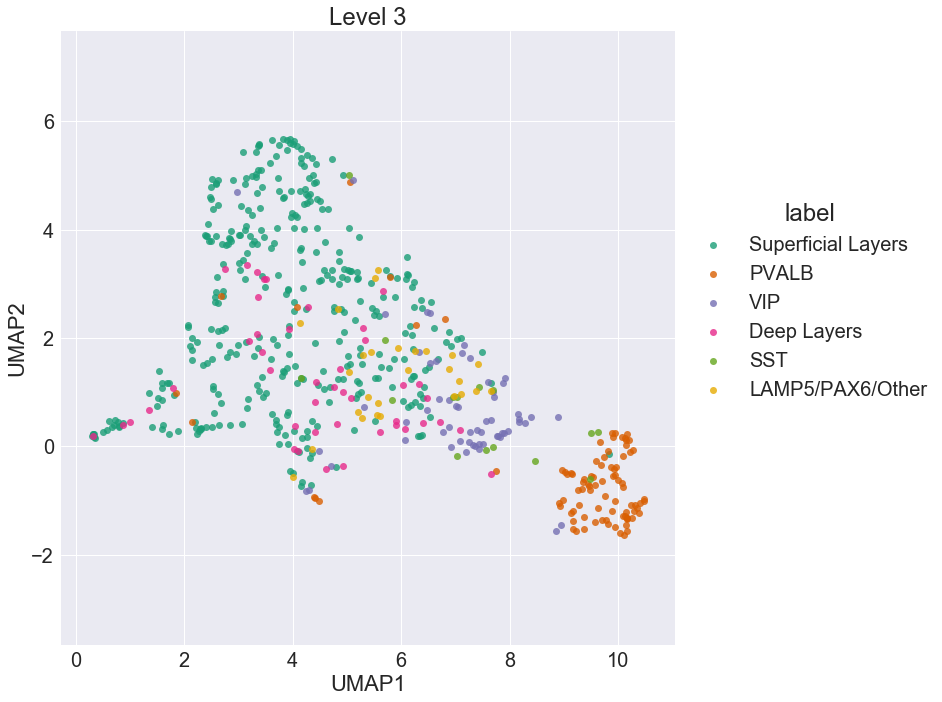

In [97]:
# create the dataset
d = {'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'label': level_3_label}
current_data = pd.DataFrame(data=d)

# sns plots
sns.set(font_scale=2)
colors=sns.color_palette("Dark2", n_colors=len(np.unique(level_3_label)),desat=1)
facet = sns.lmplot(data=current_data, x='UMAP1', y='UMAP2', hue='label', 
                   fit_reg=False, legend=False, legend_out=True,size=10,palette=colors)

facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

plt.title('Level 3')
plt.gca().set_aspect('equal', 'datalim')


## Level 4

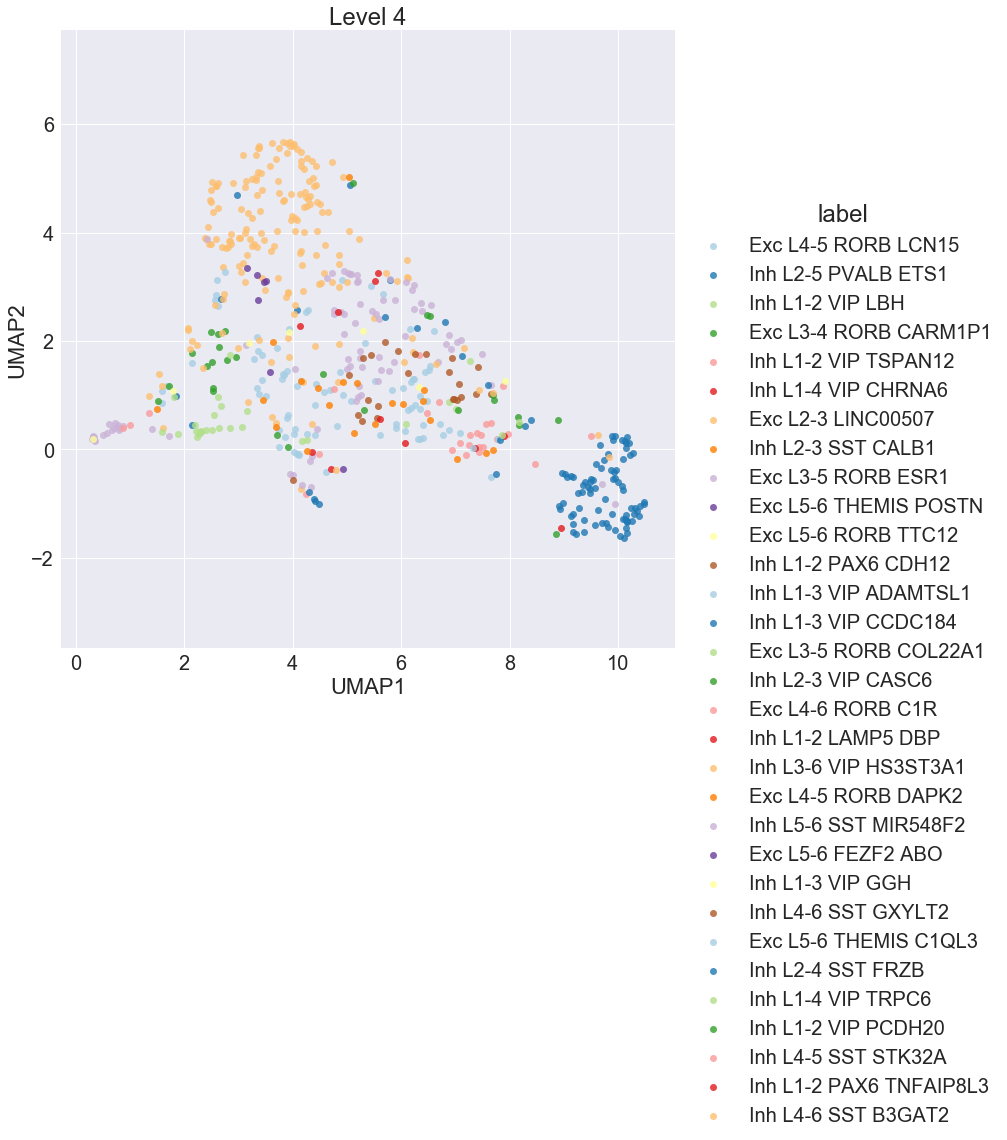

In [98]:
# create the dataset
d = {'UMAP1': embedding[:,0], 'UMAP2': embedding[:,1], 'label': level_4_label}
current_data = pd.DataFrame(data=d)

# sns plots
sns.set(font_scale=2)
colors=sns.color_palette("Paired", n_colors=len(np.unique(level_4_label)),desat=1)
facet = sns.lmplot(data=current_data, x='UMAP1', y='UMAP2', hue='label', 
                   fit_reg=False, legend=False, legend_out=True,size=10,palette=colors)

facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

plt.title('Level 4')
plt.gca().set_aspect('equal', 'datalim')


## Create input vectors for one-hot encoding

In [99]:

def one_hot_encoder(data):
    values = np.array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
   
    return onehot_encoded


## encode input vectors

In [100]:

level_1_one_hot=one_hot_encoder(level_1_label)
level_2_one_hot=one_hot_encoder(level_2_label)
level_3_one_hot=one_hot_encoder(level_3_label)
level_4_one_hot=one_hot_encoder(level_4_label)


/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can

### Feature selection: choose features with the most variance

Shape of the data:
(596, 10)


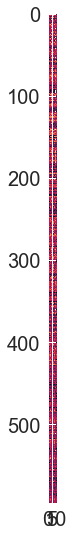

In [101]:
# best feature selection

X, y = ephys_human_features_clipped, level_1_label
X.shape

n_best_features=10

ephys_human_features_best = SelectKBest(f_classif, k=n_best_features).fit_transform(X, y)
ephys_human_features_best.shape


# scale the feature matrix

#ephys_human_scaled=preprocessing.scale(ephys_human_features_log)

# perform ROBUST SCALER
transformer = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=False).fit(ephys_human_features_best)
ephys_human_scaled_best=transformer.transform(ephys_human_features_best)

print('Shape of the data:')
print(ephys_human_scaled_best.shape)
plt.imshow(ephys_human_scaled_best)



# Predict t-type based on ephys

## Predict t-type based on ephys features:  random forest

In [102]:
# function to create the random forest classifier and plot the results

def random_forest_plot(input_data, labels, name, feature_names, num_classes, use_resampling=False):
    
    # number of features to show
    features_to_show=5
    
    # data
    data=input_data[:,:]

    # labels
    data_labels=labels
    
    # encode the labels
    le = preprocessing.LabelEncoder()
    le.fit(data_labels)
    data_labels=le.transform(data_labels)
    
    # test data
    X, y = input_data, data_labels
    
    # resample the data
    # fix sampling algorithm random state
    if use_resampling == True:
        try:
            ros = RandomUnderSampler(random_state=0)
            
            data, data_labels = ros.fit_resample(data, data_labels)
            print('Data is resampled using undersampling')
        except(ValueError):
            print('Resampling is not used')
    
    # first split with stratification
    try:
        x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.20, stratify=y, random_state=40)
        n_unique=len(np.unique(y_test))
    except(ValueError):
    # when stratification does not work
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
            print('Could not stratify classes')
            n_unique=len(np.unique(y_train))
            while n_unique >= num_classes:
                # do the random split
                x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
                n_unique=len(np.unique(y_train))
                if n_unique >= num_classes:
                    print('Number of classes in the training set:' +str(n_unique))
                    break
    
    #features
    n_features=np.shape(data)[1]

    # create the right classifier
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
                oob_score=True, random_state=0, verbose=0, warm_start=False)
    
    #RandomForestClassifier(max_depth=None, random_state=0)
    clf.fit(x_train, y_train)
    
    data_labels_predict=clf.predict(x_test)
    
    # get the scores of the trees and pring them
    random_forest_precision = precision_score(y_test, data_labels_predict,average='micro')
    random_forest_f1 = f1_score(y_test, data_labels_predict,average='micro')
    print ('Random forest precision: ' +str(random_forest_precision))
    print ('Random forest f1 score: ' +str(random_forest_f1)) 
    feature_importance=clf.feature_importances_
    
    data_labels_shuffle=np.random.randint(len(np.unique(data_labels_predict)), size=len(data_labels_predict))
    random_forest_precision_random=precision_score(y_test, data_labels_shuffle,average='micro')
    print ('Random forest random labels performance: ' + str(random_forest_precision_random))
    
    print()
    
    # compute and plot the feature order
    feature_order_idx=np.flip(np.argsort(feature_importance),0)

    print ('Random forest, important features:')
    for i in range(features_to_show):
        print(feature_names[feature_order_idx[i]])
        
    print()

    
    labels_names=np.unique(le.inverse_transform(y_test))

    # plot the confusion matrix
    fig, ax = plt.subplots()
    conf_matrix = confusion_matrix(y_test, data_labels_predict)
    # normalise confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    labels_names_form=[]
    # make label names shorter
    for i in range(len(labels_names)):
        # make the cell type name shorter
        labels_names[i]=labels_names[i][:13]
        # create the list with the cell type names
        labels_names_form.append(labels_names[i])
    # compute confusion matrix
    try:
        conf_matrix_pd=pd.DataFrame(conf_matrix, index=labels_names_form, columns=labels_names_form)
    except(ValueError):
        print('Not all classes are present in the testing set')
        conf_matrix_pd=pd.DataFrame(conf_matrix)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix_pd,annot=True,annot_kws={"size": 16},vmin=0, vmax=1)
    num_classes = len(labels_names)
    ax.set_title('Random forest e-type to t-type: ' + str(num_classes) + ' classes')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')

    

## Predict t-type based on ephys: ensemple of SVMs

In [103]:

def svm_analysis(input_data, labels, name, feature_names,num_classes,use_resampling = False, plot_weights = False):
    
    # feature number
    n_features = len(feature_names)
        
    # list to store f1 values
    f1_values = []
    
    # random f1 values
    f1_values_random = []
    
    # list to store predictions
    y_pred_average = np.zeros(1)
    
    # encode the labels with numbers
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels=le.transform(labels)
        
    # test data
    X, y = input_data, labels
            
    # first split with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.20, stratify=y, random_state=40)
        n_unique=len(np.unique(y_test))
    except(ValueError):
    # when stratification does not work
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
            print('Could not stratify classes')
            n_unique=len(np.unique(y_train))
            
            while n_unique >= num_classes:
                # do the random split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
                n_unique=len(np.unique(y_train))
                if n_unique >= num_classes:
                    print('Number of classes in the training set:' +str(n_unique))
                    break

    if use_resampling == True:
        try:
            ros = RandomUnderSampler(random_state=0,replacement = True)
            X, y = ros.fit_resample(X_train, y_train)
        except(ValueError):
            print('Oversampling is not possible')
            X_train, y_train = X_train, y_train

    # train the SVM
    clf = svm.SVC(kernel='poly', degree=3, gamma='auto', random_state=0, tol=1e-5, max_iter = -1, C = 1.0)
    clf.fit(X_train, y_train)

    # predict the labels for test data
    y_pred = clf.predict(X_test)

    # compute the f1 score for the model
    f1_result = precision_score(y_test, y_pred, average='micro')

    # compute the f1 score for random
    y_pred_random = np.random.randint(2, size=len(y_pred))
    f1_result_random = precision_score(y_test, y_pred_random, average='micro')

    # add the values
    f1_values.append(f1_result)
    # random prediction
    f1_values_random.append(f1_result_random)
    
    # get the f1_score
    f1_average = np.mean(f1_values)
    f1_average_random = np.mean(f1_values_random)
    
    print ('SVM precision: '  + str(f1_average))
    print ('SVM random precision: '  + str(f1_average_random))
    print ()
    print ('SVM f1 score: '  + str(precision_score(y_test, y_pred, average='micro')))
    print ('SVM f1 random score: '  + str(precision_score(y_test, y_pred_random, average='micro')))

    
    # transform back the labels names
    labels_names=np.unique(le.inverse_transform(y_test))

    # plot the confusion matrix
    fig, ax = plt.subplots()
    conf_matrix = confusion_matrix(y_test, y_pred)
    # normalise confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    labels_names_form=[]
    # make label names shorter
    for i in range(len(labels_names)):
        # make the cell type name shorter
        labels_names[i]=labels_names[i][:13]
        # create the list with the cell type names
        labels_names_form.append(labels_names[i])
    # compute confusion matrix
    try:
        conf_matrix_pd=pd.DataFrame(conf_matrix, index=labels_names_form, columns=labels_names_form)
    except(ValueError):
        print('Not all classes are present in the testing set')
        conf_matrix_pd=pd.DataFrame(conf_matrix)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix_pd,annot=True,annot_kws={"size": 16}, vmin=0, vmax=1)
    num_classes = len(labels_names)
    ax.set_title('SVM e-type to t-type: ' + str(num_classes) + ' classes')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')

## Predict t-type based on ephys features: neural network function

In [104]:
# this neural network learns the correspondance between ephys features and t-type

def ephys_to_t_type_net(X,labels,num_classes=2,out_layer=2):

    # encode the labels
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    y=le.transform(labels)
    
    # stratify the test data if possible
#    try:
#        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify = y)
#    except (ValueError):
#        print('Could not stratify train and test sets!')
#        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
        
    # stratify train and test datasets
    
    # first split with stratification
    try:
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=40)
        n_unique=len(np.unique(y_test))
    except(ValueError):
    # when stratification does not work
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
            print('Could not stratify classes')
            n_unique=len(np.unique(y_train))
            while n_unique >= num_classes:
                # do the random split
                x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=39)
                n_unique=len(np.unique(y_train))
                if n_unique >= num_classes:
                    print('Number of classes in the training set:' +str(n_unique))
                    break
    
    print('y_test')
    print(y_test)
    print()
    print('y_test_transformed')
    print(np.unique(le.inverse_transform(y_test)))
    # set up the testing set labels name
    labels_names=np.unique(le.inverse_transform(y_test))
    
    model = Sequential()
    # Dense(64) is a fully-connected layer with 64 hidden units.
    # in the first layer, you must specify the expected input data shape:
    # here, 20-dimensional vectors.

    x_train = x_train
    y_train = keras.utils.to_categorical(y_train, num_classes)
    x_test = x_test
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.add(Dense(128, activation='relu', input_dim=17))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(out_layer, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['categorical_accuracy'])

    model.fit(x_train, y_train,
              epochs=5000,
              batch_size=256)

#    score = model.evaluate(x_test, y_test, batch_size=256)
    
#    print('Score on testing set')
#    print(score)
    
    
    # predict the test set
    y_predict=model.predict(x_test)
    
    print()
    network_precision=precision_score(y_test.argmax(axis=1), y_predict.argmax(axis=1),average='micro')
    print('Network precision score: ' + str(network_precision)) 
    network_f1=f1_score(y_test.argmax(axis=1), y_predict.argmax(axis=1),average='micro')
    print('Network f1 score: ' + str(network_f1))

    print('Test data')
    print(y_test.argmax(axis=1))
    print('Model predictions')
    print(y_predict.argmax(axis=1))
    print()
    
            
    # COMPUTE AND PLOT THE CONFUSION MATRIX

    fig, ax = plt.subplots()
#   conf_matrix=confusion_matrix(y_test, y_predict)
    conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
    # normalise confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
#    labels_names=np.unique(le.inverse_transform(y_test))
    labels_names_form=[]
    # make label names shorter
    for i in range(len(labels_names)):
        # make the cell type name shorter
        labels_names[i]=labels_names[i][:13]
        # create the list with the cell type names
        labels_names_form.append(labels_names[i])
    # compute confusion matrix
    try:
        conf_matrix_pd=pd.DataFrame(conf_matrix, index=labels_names_form, columns=labels_names_form)
    except(ValueError):
        print('Not all classes are present in the testing set')
        conf_matrix_pd=pd.DataFrame(conf_matrix)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix_pd,annot=True,annot_kws={"size": 16},vmin=0, vmax=1)
    ax.set_title('Neural network e-type to t-type: ' + str(num_classes) + ' classes')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')

    return model

### Level 1: neural network

y_test
[0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0
 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1
 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1
 0 1 0 1 0 1 1 1 1]

y_test_transformed
['GABAergic neuron' 'Glutamatergic neuron']
Epoch 1/5000
476/476 [==============================] - 0s 702us/step - loss: 0.7411 - categorical_accuracy: 0.3866
Epoch 2/5000
476/476 [==============================] - 0s 18us/step - loss: 0.6824 - categorical_accuracy: 0.5168
Epoch 3/5000
476/476 [==============================] - 0s 17us/step - loss: 0.6285 - categorical_accuracy: 0.7122
Epoch 4/5000
476/476 [==============================] - 0s 17us/step - loss: 0.5987 - categorical_accuracy: 0.7500
Epoch 5/5000
476/476 [==============================] - 0s 18us/step - loss: 0.5550 - categorical_accuracy: 0.7500
Epoch 6/5000
476/476 [==============================] - 0s 21us/step - loss: 0.5445 - categorical_accuracy: 

Epoch 69/5000
476/476 [==============================] - 0s 16us/step - loss: 0.1952 - categorical_accuracy: 0.9328
Epoch 70/5000
476/476 [==============================] - 0s 17us/step - loss: 0.1999 - categorical_accuracy: 0.9265
Epoch 71/5000
476/476 [==============================] - 0s 17us/step - loss: 0.2099 - categorical_accuracy: 0.9181
Epoch 72/5000
476/476 [==============================] - 0s 19us/step - loss: 0.1935 - categorical_accuracy: 0.9307
Epoch 73/5000
476/476 [==============================] - 0s 17us/step - loss: 0.1858 - categorical_accuracy: 0.9391
Epoch 74/5000
476/476 [==============================] - 0s 17us/step - loss: 0.1896 - categorical_accuracy: 0.9349
Epoch 75/5000
476/476 [==============================] - 0s 18us/step - loss: 0.2042 - categorical_accuracy: 0.9286
Epoch 76/5000
476/476 [==============================] - 0s 17us/step - loss: 0.2071 - categorical_accuracy: 0.9286
Epoch 77/5000
476/476 [==============================] - 0s 17us/step - 

476/476 [==============================] - 0s 18us/step - loss: 0.0962 - categorical_accuracy: 0.9706
Epoch 210/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0902 - categorical_accuracy: 0.9601
Epoch 211/5000
476/476 [==============================] - 0s 18us/step - loss: 0.1089 - categorical_accuracy: 0.9748
Epoch 212/5000
476/476 [==============================] - 0s 16us/step - loss: 0.0930 - categorical_accuracy: 0.9622
Epoch 213/5000
476/476 [==============================] - 0s 17us/step - loss: 0.1114 - categorical_accuracy: 0.9622
Epoch 214/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0863 - categorical_accuracy: 0.9727
Epoch 215/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0958 - categorical_accuracy: 0.9790
Epoch 216/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0829 - categorical_accuracy: 0.9664
Epoch 217/5000
476/476 [==============================] - 0s 18us/step - loss: 

476/476 [==============================] - 0s 19us/step - loss: 0.0329 - categorical_accuracy: 0.9895
Epoch 350/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0417 - categorical_accuracy: 0.9874
Epoch 351/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0275 - categorical_accuracy: 0.9937
Epoch 352/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0399 - categorical_accuracy: 0.9853
Epoch 353/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0468 - categorical_accuracy: 0.9832
Epoch 354/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0314 - categorical_accuracy: 0.9874
Epoch 355/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0495 - categorical_accuracy: 0.9811
Epoch 356/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0311 - categorical_accuracy: 0.9895
Epoch 357/5000
476/476 [==============================] - 0s 19us/step - loss: 

476/476 [==============================] - 0s 18us/step - loss: 0.0267 - categorical_accuracy: 0.9937
Epoch 489/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0170 - categorical_accuracy: 0.9958
Epoch 490/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0110 - categorical_accuracy: 0.9979
Epoch 491/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0252 - categorical_accuracy: 0.9895
Epoch 492/5000
476/476 [==============================] - 0s 16us/step - loss: 0.0200 - categorical_accuracy: 0.9916
Epoch 493/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0283 - categorical_accuracy: 0.9916
Epoch 494/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0142 - categorical_accuracy: 0.9958
Epoch 495/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0133 - categorical_accuracy: 0.9958
Epoch 496/5000
476/476 [==============================] - 0s 16us/step - loss: 

476/476 [==============================] - 0s 18us/step - loss: 0.0248 - categorical_accuracy: 0.9895
Epoch 629/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0188 - categorical_accuracy: 0.9937
Epoch 630/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0102 - categorical_accuracy: 0.9979
Epoch 631/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0150 - categorical_accuracy: 0.9937
Epoch 632/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0069 - categorical_accuracy: 1.0000
Epoch 633/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0093 - categorical_accuracy: 0.9958
Epoch 634/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0200 - categorical_accuracy: 0.9937
Epoch 635/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 636/5000
476/476 [==============================] - 0s 18us/step - loss: 

476/476 [==============================] - 0s 20us/step - loss: 0.0097 - categorical_accuracy: 0.9979
Epoch 769/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0048 - categorical_accuracy: 1.0000
Epoch 770/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0081 - categorical_accuracy: 0.9958
Epoch 771/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0090 - categorical_accuracy: 0.9979
Epoch 772/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0055 - categorical_accuracy: 1.0000
Epoch 773/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0125 - categorical_accuracy: 0.9979
Epoch 774/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0066 - categorical_accuracy: 0.9979
Epoch 775/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0186 - categorical_accuracy: 0.9937
Epoch 776/5000
476/476 [==============================] - 0s 24us/step - loss: 

476/476 [==============================] - 0s 19us/step - loss: 0.0202 - categorical_accuracy: 0.9937
Epoch 908/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0048 - categorical_accuracy: 1.0000
Epoch 909/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0066 - categorical_accuracy: 0.9979
Epoch 910/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0081 - categorical_accuracy: 0.9979
Epoch 911/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0151 - categorical_accuracy: 0.9937
Epoch 912/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0037 - categorical_accuracy: 1.0000
Epoch 913/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 914/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0037 - categorical_accuracy: 0.9979
Epoch 915/5000
476/476 [==============================] - 0s 24us/step - loss: 

476/476 [==============================] - 0s 21us/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 1047/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0028 - categorical_accuracy: 0.9979
Epoch 1048/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0090 - categorical_accuracy: 0.9937
Epoch 1049/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 1050/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 1051/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0139 - categorical_accuracy: 0.9937
Epoch 1052/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0056 - categorical_accuracy: 0.9979
Epoch 1053/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0077 - categorical_accuracy: 0.9979
Epoch 1054/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0050 - categorical_accuracy: 0.9979
Epoch 1185/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 1186/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 1187/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 1188/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0049 - categorical_accuracy: 0.9979
Epoch 1189/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 1190/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0046 - categorical_accuracy: 1.0000
Epoch 1191/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 1192/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 1323/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 1324/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0066 - categorical_accuracy: 0.9979
Epoch 1325/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0053 - categorical_accuracy: 0.9979
Epoch 1326/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 1327/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0042 - categorical_accuracy: 0.9979
Epoch 1328/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 1329/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 1330/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0023 - categorical_accuracy: 0.9979
Epoch 1461/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 1462/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 1463/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 1464/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 1465/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0040 - categorical_accuracy: 0.9979
Epoch 1466/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0169 - categorical_accuracy: 0.9958
Epoch 1467/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 1468/5000
476/476 [==============================] - 0s 19us/step 

Epoch 1598/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0051 - categorical_accuracy: 0.9979
Epoch 1599/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0109 - categorical_accuracy: 0.9958
Epoch 1600/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0031 - categorical_accuracy: 0.9979
Epoch 1601/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 1602/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0176 - categorical_accuracy: 0.9979
Epoch 1603/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0047 - categorical_accuracy: 0.9979
Epoch 1604/5000
476/476 [==============================] - 0s 23us/step - loss: 9.8242e-04 - categorical_accuracy: 1.0000
Epoch 1605/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 1606/5000
476/476 [===========================

476/476 [==============================] - 0s 21us/step - loss: 0.0072 - categorical_accuracy: 0.9958
Epoch 1735/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 1736/5000
476/476 [==============================] - 0s 20us/step - loss: 5.5247e-04 - categorical_accuracy: 1.0000
Epoch 1737/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 1738/5000
476/476 [==============================] - 0s 20us/step - loss: 6.5695e-04 - categorical_accuracy: 1.0000
Epoch 1739/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0063 - categorical_accuracy: 0.9979
Epoch 1740/5000
476/476 [==============================] - 0s 21us/step - loss: 5.4703e-04 - categorical_accuracy: 1.0000
Epoch 1741/5000
476/476 [==============================] - 0s 55us/step - loss: 7.0947e-04 - categorical_accuracy: 1.0000
Epoch 1742/5000
476/476 [==============================]

476/476 [==============================] - 0s 23us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 1871/5000
476/476 [==============================] - 0s 24us/step - loss: 4.7313e-04 - categorical_accuracy: 1.0000
Epoch 1872/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 1873/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 1874/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 1875/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0035 - categorical_accuracy: 0.9979
Epoch 1876/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0049 - categorical_accuracy: 0.9979
Epoch 1877/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 1878/5000
476/476 [==============================] - 0s 25us/s

476/476 [==============================] - 0s 18us/step - loss: 0.0048 - categorical_accuracy: 0.9979
Epoch 2007/5000
476/476 [==============================] - 0s 19us/step - loss: 9.9338e-04 - categorical_accuracy: 1.0000
Epoch 2008/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0033 - categorical_accuracy: 0.9979
Epoch 2009/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 2010/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 2011/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0056 - categorical_accuracy: 0.9979
Epoch 2012/5000
476/476 [==============================] - 0s 28us/step - loss: 5.3584e-04 - categorical_accuracy: 1.0000
Epoch 2013/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 2014/5000
476/476 [==============================] - 0s 24

476/476 [==============================] - 0s 25us/step - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 2143/5000
476/476 [==============================] - 0s 21us/step - loss: 8.2169e-04 - categorical_accuracy: 1.0000
Epoch 2144/5000
476/476 [==============================] - 0s 22us/step - loss: 9.8645e-04 - categorical_accuracy: 1.0000
Epoch 2145/5000
476/476 [==============================] - 0s 23us/step - loss: 8.8434e-04 - categorical_accuracy: 1.0000
Epoch 2146/5000
476/476 [==============================] - 0s 23us/step - loss: 3.3952e-04 - categorical_accuracy: 1.0000
Epoch 2147/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0010 - categorical_accuracy: 1.0000
Epoch 2148/5000
476/476 [==============================] - 0s 25us/step - loss: 4.9232e-04 - categorical_accuracy: 1.0000
Epoch 2149/5000
476/476 [==============================] - 0s 22us/step - loss: 6.8623e-04 - categorical_accuracy: 1.0000
Epoch 2150/5000
476/476 [=======================

476/476 [==============================] - 0s 22us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 2279/5000
476/476 [==============================] - 0s 22us/step - loss: 6.6998e-04 - categorical_accuracy: 1.0000
Epoch 2280/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0114 - categorical_accuracy: 0.9958
Epoch 2281/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 2282/5000
476/476 [==============================] - 0s 26us/step - loss: 9.8471e-04 - categorical_accuracy: 1.0000
Epoch 2283/5000
476/476 [==============================] - 0s 21us/step - loss: 3.7344e-04 - categorical_accuracy: 1.0000
Epoch 2284/5000
476/476 [==============================] - 0s 22us/step - loss: 4.7686e-04 - categorical_accuracy: 1.0000
Epoch 2285/5000
476/476 [==============================] - 0s 24us/step - loss: 5.0294e-04 - categorical_accuracy: 1.0000
Epoch 2286/5000
476/476 [===========================

476/476 [==============================] - 0s 26us/step - loss: 9.8725e-04 - categorical_accuracy: 1.0000
Epoch 2415/5000
476/476 [==============================] - 0s 20us/step - loss: 4.2903e-04 - categorical_accuracy: 1.0000
Epoch 2416/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0084 - categorical_accuracy: 0.9979
Epoch 2417/5000
476/476 [==============================] - 0s 22us/step - loss: 6.3460e-04 - categorical_accuracy: 1.0000
Epoch 2418/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 2419/5000
476/476 [==============================] - 0s 20us/step - loss: 3.1524e-04 - categorical_accuracy: 1.0000
Epoch 2420/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0034 - categorical_accuracy: 0.9979
Epoch 2421/5000
476/476 [==============================] - 0s 23us/step - loss: 5.4084e-04 - categorical_accuracy: 1.0000
Epoch 2422/5000
476/476 [===========================

476/476 [==============================] - 0s 18us/step - loss: 8.9970e-04 - categorical_accuracy: 1.0000
Epoch 2483/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0046 - categorical_accuracy: 0.9979
Epoch 2484/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0020 - categorical_accuracy: 0.9979
Epoch 2485/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0122 - categorical_accuracy: 0.9979
Epoch 2486/5000
476/476 [==============================] - 0s 21us/step - loss: 3.3910e-04 - categorical_accuracy: 1.0000
Epoch 2487/5000
476/476 [==============================] - 0s 18us/step - loss: 7.2286e-04 - categorical_accuracy: 1.0000
Epoch 2488/5000
476/476 [==============================] - 0s 18us/step - loss: 3.2336e-04 - categorical_accuracy: 1.0000
Epoch 2489/5000
476/476 [==============================] - 0s 17us/step - loss: 0.0065 - categorical_accuracy: 0.9979
Epoch 2490/5000
476/476 [==============================]

476/476 [==============================] - 0s 19us/step - loss: 0.0032 - categorical_accuracy: 0.9979
Epoch 2618/5000
476/476 [==============================] - 0s 20us/step - loss: 2.2783e-04 - categorical_accuracy: 1.0000
Epoch 2619/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0034 - categorical_accuracy: 0.9979
Epoch 2620/5000
476/476 [==============================] - 0s 18us/step - loss: 3.0643e-04 - categorical_accuracy: 1.0000
Epoch 2621/5000
476/476 [==============================] - 0s 18us/step - loss: 3.6728e-04 - categorical_accuracy: 1.0000
Epoch 2622/5000
476/476 [==============================] - 0s 20us/step - loss: 2.5700e-04 - categorical_accuracy: 1.0000
Epoch 2623/5000
476/476 [==============================] - 0s 18us/step - loss: 5.9178e-04 - categorical_accuracy: 1.0000
Epoch 2624/5000
476/476 [==============================] - 0s 18us/step - loss: 8.5168e-04 - categorical_accuracy: 1.0000
Epoch 2625/5000
476/476 [=======================

476/476 [==============================] - 0s 19us/step - loss: 4.9764e-04 - categorical_accuracy: 1.0000
Epoch 2686/5000
476/476 [==============================] - 0s 19us/step - loss: 3.9477e-04 - categorical_accuracy: 1.0000
Epoch 2687/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0026 - categorical_accuracy: 0.9979
Epoch 2688/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0073 - categorical_accuracy: 0.9958
Epoch 2689/5000
476/476 [==============================] - 0s 21us/step - loss: 2.8610e-04 - categorical_accuracy: 1.0000
Epoch 2690/5000
476/476 [==============================] - 0s 22us/step - loss: 5.4606e-04 - categorical_accuracy: 1.0000
Epoch 2691/5000
476/476 [==============================] - 0s 22us/step - loss: 2.1171e-04 - categorical_accuracy: 1.0000
Epoch 2692/5000
476/476 [==============================] - 0s 110us/step - loss: 8.5933e-04 - categorical_accuracy: 1.0000
Epoch 2693/5000
476/476 [======================

Epoch 2753/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 2754/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0080 - categorical_accuracy: 0.9979
Epoch 2755/5000
476/476 [==============================] - 0s 19us/step - loss: 3.4504e-04 - categorical_accuracy: 1.0000
Epoch 2756/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0055 - categorical_accuracy: 0.9979
Epoch 2757/5000
476/476 [==============================] - 0s 20us/step - loss: 2.1415e-04 - categorical_accuracy: 1.0000
Epoch 2758/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0034 - categorical_accuracy: 0.9979
Epoch 2759/5000
476/476 [==============================] - 0s 18us/step - loss: 4.2802e-04 - categorical_accuracy: 1.0000
Epoch 2760/5000
476/476 [==============================] - 0s 19us/step - loss: 6.5165e-04 - categorical_accuracy: 1.0000
Epoch 2761/5000
476/476 [===============

476/476 [==============================] - 0s 23us/step - loss: 1.5030e-04 - categorical_accuracy: 1.0000
Epoch 2889/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 2890/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 2891/5000
476/476 [==============================] - 0s 22us/step - loss: 2.7062e-04 - categorical_accuracy: 1.0000
Epoch 2892/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 2893/5000
476/476 [==============================] - 0s 23us/step - loss: 2.2890e-04 - categorical_accuracy: 1.0000
Epoch 2894/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0030 - categorical_accuracy: 0.9979
Epoch 2895/5000
476/476 [==============================] - 0s 18us/step - loss: 2.5040e-04 - categorical_accuracy: 1.0000
Epoch 2896/5000
476/476 [==============================]

476/476 [==============================] - 0s 18us/step - loss: 3.2009e-04 - categorical_accuracy: 1.0000
Epoch 3024/5000
476/476 [==============================] - 0s 20us/step - loss: 4.9059e-04 - categorical_accuracy: 1.0000
Epoch 3025/5000
476/476 [==============================] - 0s 18us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 3026/5000
476/476 [==============================] - 0s 21us/step - loss: 1.8971e-04 - categorical_accuracy: 1.0000
Epoch 3027/5000
476/476 [==============================] - 0s 20us/step - loss: 1.5326e-04 - categorical_accuracy: 1.0000
Epoch 3028/5000
476/476 [==============================] - 0s 19us/step - loss: 9.7421e-04 - categorical_accuracy: 1.0000
Epoch 3029/5000
476/476 [==============================] - 0s 19us/step - loss: 5.3367e-04 - categorical_accuracy: 1.0000
Epoch 3030/5000
476/476 [==============================] - 0s 20us/step - loss: 1.9214e-04 - categorical_accuracy: 1.0000
Epoch 3031/5000
476/476 [===================

476/476 [==============================] - 0s 23us/step - loss: 4.9310e-04 - categorical_accuracy: 1.0000
Epoch 3158/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 3159/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0030 - categorical_accuracy: 0.9979
Epoch 3160/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3161/5000
476/476 [==============================] - 0s 25us/step - loss: 2.4076e-04 - categorical_accuracy: 1.0000
Epoch 3162/5000
476/476 [==============================] - 0s 21us/step - loss: 3.3176e-04 - categorical_accuracy: 1.0000
Epoch 3163/5000
476/476 [==============================] - 0s 23us/step - loss: 3.8789e-04 - categorical_accuracy: 1.0000
Epoch 3164/5000
476/476 [==============================] - 0s 21us/step - loss: 2.4014e-04 - categorical_accuracy: 1.0000
Epoch 3165/5000
476/476 [===========================

476/476 [==============================] - 0s 24us/step - loss: 4.0153e-04 - categorical_accuracy: 1.0000
Epoch 3226/5000
476/476 [==============================] - 0s 25us/step - loss: 3.5741e-04 - categorical_accuracy: 1.0000
Epoch 3227/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 3228/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 3229/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 3230/5000
476/476 [==============================] - 0s 23us/step - loss: 6.0715e-04 - categorical_accuracy: 1.0000
Epoch 3231/5000
476/476 [==============================] - 0s 23us/step - loss: 2.7361e-04 - categorical_accuracy: 1.0000
Epoch 3232/5000
476/476 [==============================] - 0s 24us/step - loss: 7.4751e-04 - categorical_accuracy: 1.0000
Epoch 3233/5000
476/476 [===========================

476/476 [==============================] - 0s 22us/step - loss: 9.5191e-04 - categorical_accuracy: 1.0000
Epoch 3294/5000
476/476 [==============================] - 0s 24us/step - loss: 4.6790e-04 - categorical_accuracy: 1.0000
Epoch 3295/5000
476/476 [==============================] - 0s 24us/step - loss: 3.1657e-04 - categorical_accuracy: 1.0000
Epoch 3296/5000
476/476 [==============================] - 0s 18us/step - loss: 5.3547e-04 - categorical_accuracy: 1.0000
Epoch 3297/5000
476/476 [==============================] - 0s 20us/step - loss: 6.1097e-04 - categorical_accuracy: 1.0000
Epoch 3298/5000
476/476 [==============================] - 0s 20us/step - loss: 2.3969e-04 - categorical_accuracy: 1.0000
Epoch 3299/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0094 - categorical_accuracy: 0.9979
Epoch 3300/5000
476/476 [==============================] - 0s 21us/step - loss: 3.6776e-04 - categorical_accuracy: 1.0000
Epoch 3301/5000
476/476 [===================

476/476 [==============================] - 0s 26us/step - loss: 4.2016e-04 - categorical_accuracy: 1.0000
Epoch 3428/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3429/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0088 - categorical_accuracy: 0.9979
Epoch 3430/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0151 - categorical_accuracy: 0.9958
Epoch 3431/5000
476/476 [==============================] - 0s 29us/step - loss: 7.4687e-04 - categorical_accuracy: 1.0000
Epoch 3432/5000
476/476 [==============================] - 0s 28us/step - loss: 2.7632e-04 - categorical_accuracy: 1.0000
Epoch 3433/5000
476/476 [==============================] - 0s 26us/step - loss: 3.9548e-04 - categorical_accuracy: 1.0000
Epoch 3434/5000
476/476 [==============================] - 0s 30us/step - loss: 3.4291e-04 - categorical_accuracy: 1.0000
Epoch 3435/5000
476/476 [===========================

476/476 [==============================] - 0s 24us/step - loss: 9.7506e-05 - categorical_accuracy: 1.0000
Epoch 3562/5000
476/476 [==============================] - 0s 27us/step - loss: 7.0738e-04 - categorical_accuracy: 1.0000
Epoch 3563/5000
476/476 [==============================] - 0s 25us/step - loss: 2.3855e-04 - categorical_accuracy: 1.0000
Epoch 3564/5000
476/476 [==============================] - 0s 23us/step - loss: 1.3393e-04 - categorical_accuracy: 1.0000
Epoch 3565/5000
476/476 [==============================] - 0s 25us/step - loss: 3.0981e-04 - categorical_accuracy: 1.0000
Epoch 3566/5000
476/476 [==============================] - 0s 21us/step - loss: 1.6435e-04 - categorical_accuracy: 1.0000
Epoch 3567/5000
476/476 [==============================] - 0s 20us/step - loss: 1.4303e-04 - categorical_accuracy: 1.0000
Epoch 3568/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 3569/5000
476/476 [===================

476/476 [==============================] - 0s 20us/step - loss: 2.9543e-04 - categorical_accuracy: 1.0000
Epoch 3696/5000
476/476 [==============================] - 0s 20us/step - loss: 9.3344e-04 - categorical_accuracy: 1.0000
Epoch 3697/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3698/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0050 - categorical_accuracy: 0.9979
Epoch 3699/5000
476/476 [==============================] - 0s 20us/step - loss: 2.6706e-04 - categorical_accuracy: 1.0000
Epoch 3700/5000
476/476 [==============================] - 0s 19us/step - loss: 2.3304e-04 - categorical_accuracy: 1.0000
Epoch 3701/5000
476/476 [==============================] - 0s 19us/step - loss: 1.3811e-04 - categorical_accuracy: 1.0000
Epoch 3702/5000
476/476 [==============================] - 0s 21us/step - loss: 6.5043e-04 - categorical_accuracy: 1.0000
Epoch 3703/5000
476/476 [=======================

476/476 [==============================] - 0s 20us/step - loss: 1.6509e-04 - categorical_accuracy: 1.0000
Epoch 3830/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3990e-04 - categorical_accuracy: 1.0000
Epoch 3831/5000
476/476 [==============================] - 0s 20us/step - loss: 2.8476e-04 - categorical_accuracy: 1.0000
Epoch 3832/5000
476/476 [==============================] - 0s 20us/step - loss: 1.0024e-04 - categorical_accuracy: 1.0000
Epoch 3833/5000
476/476 [==============================] - 0s 20us/step - loss: 1.6530e-04 - categorical_accuracy: 1.0000
Epoch 3834/5000
476/476 [==============================] - 0s 21us/step - loss: 8.5965e-05 - categorical_accuracy: 1.0000
Epoch 3835/5000
476/476 [==============================] - 0s 20us/step - loss: 1.5595e-04 - categorical_accuracy: 1.0000
Epoch 3836/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3837/5000
476/476 [===================

476/476 [==============================] - 0s 20us/step - loss: 9.9926e-05 - categorical_accuracy: 1.0000
Epoch 3964/5000
476/476 [==============================] - 0s 20us/step - loss: 1.6059e-04 - categorical_accuracy: 1.0000
Epoch 3965/5000
476/476 [==============================] - 0s 19us/step - loss: 4.3518e-04 - categorical_accuracy: 1.0000
Epoch 3966/5000
476/476 [==============================] - 0s 19us/step - loss: 8.0397e-04 - categorical_accuracy: 1.0000
Epoch 3967/5000
476/476 [==============================] - 0s 20us/step - loss: 4.5900e-04 - categorical_accuracy: 1.0000
Epoch 3968/5000
476/476 [==============================] - 0s 20us/step - loss: 1.5966e-04 - categorical_accuracy: 1.0000
Epoch 3969/5000
476/476 [==============================] - 0s 20us/step - loss: 1.1049e-04 - categorical_accuracy: 1.0000
Epoch 3970/5000
476/476 [==============================] - 0s 19us/step - loss: 9.4202e-04 - categorical_accuracy: 1.0000
Epoch 3971/5000
476/476 [===============

476/476 [==============================] - 0s 22us/step - loss: 2.1233e-04 - categorical_accuracy: 1.0000
Epoch 4098/5000
476/476 [==============================] - 0s 22us/step - loss: 6.3196e-05 - categorical_accuracy: 1.0000
Epoch 4099/5000
476/476 [==============================] - 0s 20us/step - loss: 5.6488e-04 - categorical_accuracy: 1.0000
Epoch 4100/5000
476/476 [==============================] - 0s 20us/step - loss: 2.9474e-04 - categorical_accuracy: 1.0000
Epoch 4101/5000
476/476 [==============================] - 0s 21us/step - loss: 1.0428e-04 - categorical_accuracy: 1.0000
Epoch 4102/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0057 - categorical_accuracy: 0.9958
Epoch 4103/5000
476/476 [==============================] - 0s 19us/step - loss: 1.2872e-04 - categorical_accuracy: 1.0000
Epoch 4104/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0125 - categorical_accuracy: 0.9979
Epoch 4105/5000
476/476 [=======================

476/476 [==============================] - 0s 19us/step - loss: 3.2958e-04 - categorical_accuracy: 1.0000
Epoch 4232/5000
476/476 [==============================] - 0s 19us/step - loss: 3.0027e-04 - categorical_accuracy: 1.0000
Epoch 4233/5000
476/476 [==============================] - 0s 19us/step - loss: 2.3890e-04 - categorical_accuracy: 1.0000
Epoch 4234/5000
476/476 [==============================] - 0s 19us/step - loss: 1.6687e-04 - categorical_accuracy: 1.0000
Epoch 4235/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 4236/5000
476/476 [==============================] - 0s 18us/step - loss: 3.9785e-04 - categorical_accuracy: 1.0000
Epoch 4237/5000
476/476 [==============================] - 0s 18us/step - loss: 1.4148e-04 - categorical_accuracy: 1.0000
Epoch 4238/5000
476/476 [==============================] - 0s 18us/step - loss: 3.5096e-04 - categorical_accuracy: 1.0000
Epoch 4239/5000
476/476 [===================

476/476 [==============================] - 0s 20us/step - loss: 8.3685e-04 - categorical_accuracy: 1.0000
Epoch 4366/5000
476/476 [==============================] - 0s 22us/step - loss: 1.9045e-04 - categorical_accuracy: 1.0000
Epoch 4367/5000
476/476 [==============================] - 0s 19us/step - loss: 2.5479e-04 - categorical_accuracy: 1.0000
Epoch 4368/5000
476/476 [==============================] - 0s 19us/step - loss: 1.7225e-04 - categorical_accuracy: 1.0000
Epoch 4369/5000
476/476 [==============================] - 0s 20us/step - loss: 1.5617e-04 - categorical_accuracy: 1.0000
Epoch 4370/5000
476/476 [==============================] - 0s 19us/step - loss: 2.3520e-04 - categorical_accuracy: 1.0000
Epoch 4371/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 4372/5000
476/476 [==============================] - 0s 20us/step - loss: 2.0981e-04 - categorical_accuracy: 1.0000
Epoch 4373/5000
476/476 [===================

476/476 [==============================] - 0s 18us/step - loss: 9.0147e-05 - categorical_accuracy: 1.0000
Epoch 4500/5000
476/476 [==============================] - 0s 19us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4501/5000
476/476 [==============================] - 0s 18us/step - loss: 8.8609e-04 - categorical_accuracy: 1.0000
Epoch 4502/5000
476/476 [==============================] - 0s 18us/step - loss: 1.6335e-04 - categorical_accuracy: 1.0000
Epoch 4503/5000
476/476 [==============================] - 0s 20us/step - loss: 6.7739e-05 - categorical_accuracy: 1.0000
Epoch 4504/5000
476/476 [==============================] - 0s 22us/step - loss: 6.7389e-05 - categorical_accuracy: 1.0000
Epoch 4505/5000
476/476 [==============================] - 0s 21us/step - loss: 1.8137e-04 - categorical_accuracy: 1.0000
Epoch 4506/5000
476/476 [==============================] - 0s 20us/step - loss: 1.1492e-04 - categorical_accuracy: 1.0000
Epoch 4507/5000
476/476 [===================

476/476 [==============================] - 0s 18us/step - loss: 0.0082 - categorical_accuracy: 0.9979
Epoch 4634/5000
476/476 [==============================] - 0s 19us/step - loss: 1.3006e-04 - categorical_accuracy: 1.0000
Epoch 4635/5000
476/476 [==============================] - 0s 21us/step - loss: 1.5124e-04 - categorical_accuracy: 1.0000
Epoch 4636/5000
476/476 [==============================] - 0s 19us/step - loss: 7.8142e-05 - categorical_accuracy: 1.0000
Epoch 4637/5000
476/476 [==============================] - 0s 18us/step - loss: 1.7517e-04 - categorical_accuracy: 1.0000
Epoch 4638/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4639/5000
476/476 [==============================] - 0s 26us/step - loss: 2.2160e-04 - categorical_accuracy: 1.0000
Epoch 4640/5000
476/476 [==============================] - 0s 26us/step - loss: 2.9227e-04 - categorical_accuracy: 1.0000
Epoch 4641/5000
476/476 [=======================

476/476 [==============================] - 0s 23us/step - loss: 9.4593e-05 - categorical_accuracy: 1.0000
Epoch 4768/5000
476/476 [==============================] - 0s 26us/step - loss: 9.2870e-04 - categorical_accuracy: 1.0000
Epoch 4769/5000
476/476 [==============================] - 0s 24us/step - loss: 1.1927e-04 - categorical_accuracy: 1.0000
Epoch 4770/5000
476/476 [==============================] - 0s 25us/step - loss: 8.3258e-05 - categorical_accuracy: 1.0000
Epoch 4771/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0020 - categorical_accuracy: 0.9979
Epoch 4772/5000
476/476 [==============================] - 0s 25us/step - loss: 8.2786e-05 - categorical_accuracy: 1.0000
Epoch 4773/5000
476/476 [==============================] - 0s 23us/step - loss: 6.9789e-04 - categorical_accuracy: 1.0000
Epoch 4774/5000
476/476 [==============================] - 0s 24us/step - loss: 1.6065e-04 - categorical_accuracy: 1.0000
Epoch 4775/5000
476/476 [===================

476/476 [==============================] - 0s 22us/step - loss: 0.0017 - categorical_accuracy: 0.9979
Epoch 4902/5000
476/476 [==============================] - 0s 21us/step - loss: 1.5447e-04 - categorical_accuracy: 1.0000
Epoch 4903/5000
476/476 [==============================] - 0s 22us/step - loss: 4.7458e-05 - categorical_accuracy: 1.0000
Epoch 4904/5000
476/476 [==============================] - 0s 20us/step - loss: 6.3972e-05 - categorical_accuracy: 1.0000
Epoch 4905/5000
476/476 [==============================] - 0s 20us/step - loss: 1.8688e-04 - categorical_accuracy: 1.0000
Epoch 4906/5000
476/476 [==============================] - 0s 20us/step - loss: 1.2341e-04 - categorical_accuracy: 1.0000
Epoch 4907/5000
476/476 [==============================] - 0s 24us/step - loss: 1.1378e-04 - categorical_accuracy: 1.0000
Epoch 4908/5000
476/476 [==============================] - 0s 23us/step - loss: 4.9790e-05 - categorical_accuracy: 1.0000
Epoch 4909/5000
476/476 [===================

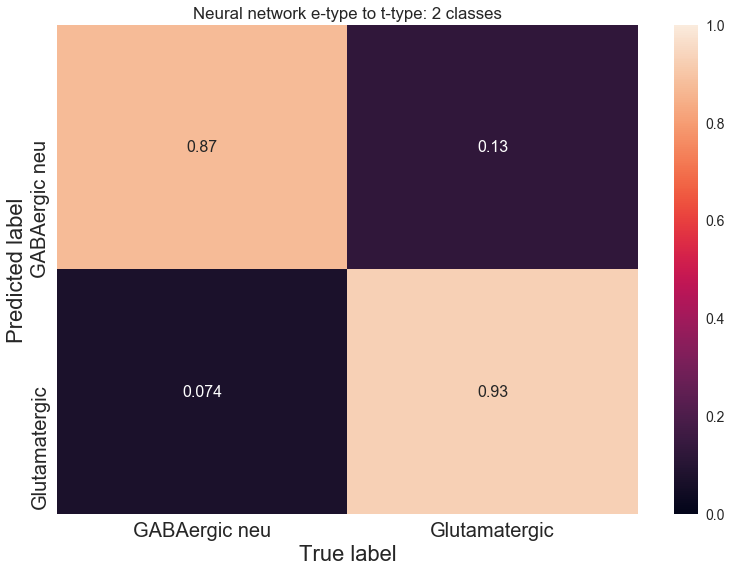

In [105]:

model_e2t_level_1=ephys_to_t_type_net(ephys_human_scaled,level_1_label,num_classes=2,out_layer=2)


### Level 1: random forest

Random forest precision: 0.9416666666666667
Random forest f1 score: 0.9416666666666667
Random forest random labels performance: 0.475

Random forest, important features:
upstroke_downstroke_ratio_short_square
upstroke_downstroke_ratio_long_square
f_i_curve_slope
latency
threshold_i_short_square



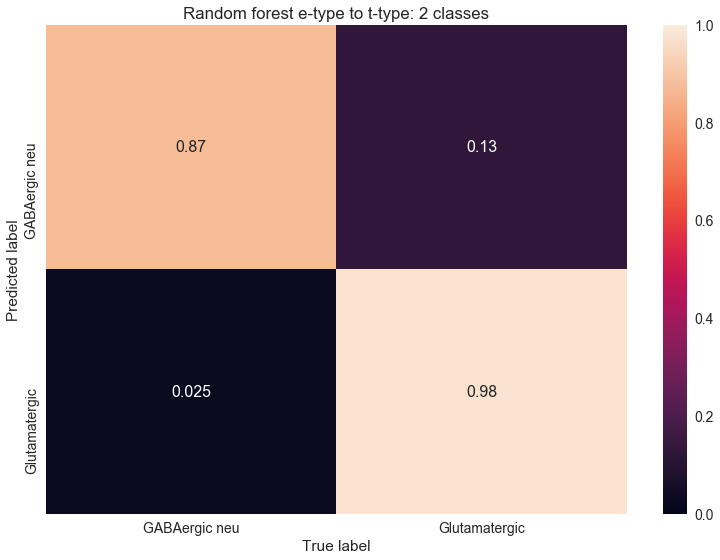

In [106]:

random_forest_plot(ephys_human_scaled,level_1_label, 'Level 1', feature_names,num_classes=2,use_resampling=False)


### Level 1: SVM analysis

SVM precision: 0.9166666666666666
SVM random precision: 0.5

SVM f1 score: 0.9166666666666666
SVM f1 random score: 0.5


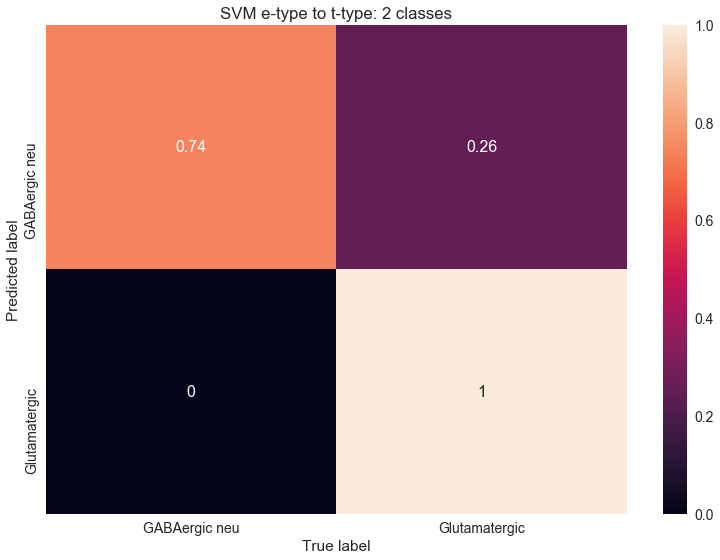

In [107]:

svm_analysis(ephys_human_scaled, level_1_label, 'Level 1', feature_names, num_classes =2, use_resampling=False)


### Level 2: neural network

y_test
[3 2 3 0 2 3 3 0 3 3 2 3 0 3 2 3 2 2 1 3 3 0 3 0 2 3 2 3 2 3 1 3 1 3 3 2 0
 3 3 0 0 2 3 3 1 3 2 2 3 0 3 2 3 3 3 3 2 0 1 2 3 0 3 3 3 3 1 3 3 3 3 0 3 3
 3 3 3 3 3 2 0 2 2 3 3 1 3 3 3 2 3 3 3 3 0 1 3 0 3 3 3 0 3 3 3 2 3 3 0 3 3
 3 3 3 3 2 3 1 3 3]

y_test_transformed
['ADARB2' 'Deep Layers' 'LHX6' 'Superficial Layers']
Epoch 1/5000
476/476 [==============================] - 0s 865us/step - loss: 1.3561 - categorical_accuracy: 0.3193
Epoch 2/5000
476/476 [==============================] - 0s 19us/step - loss: 1.3088 - categorical_accuracy: 0.4076
Epoch 3/5000
476/476 [==============================] - 0s 18us/step - loss: 1.2341 - categorical_accuracy: 0.5714
Epoch 4/5000
476/476 [==============================] - 0s 19us/step - loss: 1.1730 - categorical_accuracy: 0.6008
Epoch 5/5000
476/476 [==============================] - 0s 18us/step - loss: 1.1244 - categorical_accuracy: 0.6050
Epoch 6/5000
476/476 [==============================] - 0s 18us/step - loss: 1.0695 - categorical_a

476/476 [==============================] - 0s 21us/step - loss: 0.4023 - categorical_accuracy: 0.8571
Epoch 139/5000
476/476 [==============================] - 0s 20us/step - loss: 0.3895 - categorical_accuracy: 0.8571
Epoch 140/5000
476/476 [==============================] - 0s 18us/step - loss: 0.3801 - categorical_accuracy: 0.8592
Epoch 141/5000
476/476 [==============================] - 0s 18us/step - loss: 0.3778 - categorical_accuracy: 0.8718
Epoch 142/5000
476/476 [==============================] - 0s 19us/step - loss: 0.3956 - categorical_accuracy: 0.8697
Epoch 143/5000
476/476 [==============================] - 0s 19us/step - loss: 0.3884 - categorical_accuracy: 0.8508
Epoch 144/5000
476/476 [==============================] - 0s 19us/step - loss: 0.3851 - categorical_accuracy: 0.8592
Epoch 145/5000
476/476 [==============================] - 0s 18us/step - loss: 0.3990 - categorical_accuracy: 0.8445
Epoch 146/5000
476/476 [==============================] - 0s 18us/step - loss: 

476/476 [==============================] - 0s 20us/step - loss: 0.2483 - categorical_accuracy: 0.9055
Epoch 279/5000
476/476 [==============================] - 0s 21us/step - loss: 0.2437 - categorical_accuracy: 0.9118
Epoch 280/5000
476/476 [==============================] - 0s 19us/step - loss: 0.2266 - categorical_accuracy: 0.9181
Epoch 281/5000
476/476 [==============================] - 0s 20us/step - loss: 0.2309 - categorical_accuracy: 0.9034
Epoch 282/5000
476/476 [==============================] - 0s 20us/step - loss: 0.2364 - categorical_accuracy: 0.8950
Epoch 283/5000
476/476 [==============================] - 0s 20us/step - loss: 0.2446 - categorical_accuracy: 0.9076
Epoch 284/5000
476/476 [==============================] - 0s 19us/step - loss: 0.2306 - categorical_accuracy: 0.9181
Epoch 285/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2508 - categorical_accuracy: 0.9097
Epoch 286/5000
476/476 [==============================] - 0s 22us/step - loss: 

476/476 [==============================] - 0s 19us/step - loss: 0.1210 - categorical_accuracy: 0.9538
Epoch 419/5000
476/476 [==============================] - 0s 20us/step - loss: 0.1701 - categorical_accuracy: 0.9454
Epoch 420/5000
476/476 [==============================] - 0s 20us/step - loss: 0.1507 - categorical_accuracy: 0.9412
Epoch 421/5000
476/476 [==============================] - 0s 19us/step - loss: 0.1327 - categorical_accuracy: 0.9538
Epoch 422/5000
476/476 [==============================] - 0s 19us/step - loss: 0.1284 - categorical_accuracy: 0.9601
Epoch 423/5000
476/476 [==============================] - 0s 19us/step - loss: 0.1192 - categorical_accuracy: 0.9538
Epoch 424/5000
476/476 [==============================] - 0s 20us/step - loss: 0.1747 - categorical_accuracy: 0.9265
Epoch 425/5000
476/476 [==============================] - 0s 21us/step - loss: 0.1351 - categorical_accuracy: 0.9496
Epoch 426/5000
476/476 [==============================] - 0s 20us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.0969 - categorical_accuracy: 0.9748
Epoch 559/5000
476/476 [==============================] - 0s 23us/step - loss: 0.1043 - categorical_accuracy: 0.9517
Epoch 560/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0873 - categorical_accuracy: 0.9706
Epoch 561/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0795 - categorical_accuracy: 0.9769
Epoch 562/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0999 - categorical_accuracy: 0.9622
Epoch 563/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0653 - categorical_accuracy: 0.9853
Epoch 564/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0718 - categorical_accuracy: 0.9811
Epoch 565/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0714 - categorical_accuracy: 0.9706
Epoch 566/5000
476/476 [==============================] - 0s 22us/step - loss: 

476/476 [==============================] - 0s 33us/step - loss: 0.0447 - categorical_accuracy: 0.9853
Epoch 699/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0456 - categorical_accuracy: 0.9874
Epoch 700/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0612 - categorical_accuracy: 0.9769
Epoch 701/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0803 - categorical_accuracy: 0.9727
Epoch 702/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0666 - categorical_accuracy: 0.9748
Epoch 703/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0354 - categorical_accuracy: 0.9895
Epoch 704/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0611 - categorical_accuracy: 0.9769
Epoch 705/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0439 - categorical_accuracy: 0.9916
Epoch 706/5000
476/476 [==============================] - 0s 24us/step - loss: 

476/476 [==============================] - 0s 28us/step - loss: 0.0310 - categorical_accuracy: 0.9895
Epoch 839/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0545 - categorical_accuracy: 0.9874
Epoch 840/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0282 - categorical_accuracy: 0.9895
Epoch 841/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0425 - categorical_accuracy: 0.9853
Epoch 842/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0261 - categorical_accuracy: 0.9958
Epoch 843/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0431 - categorical_accuracy: 0.9874
Epoch 844/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0388 - categorical_accuracy: 0.9895
Epoch 845/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0241 - categorical_accuracy: 0.9958
Epoch 846/5000
476/476 [==============================] - 0s 22us/step - loss: 

476/476 [==============================] - 0s 21us/step - loss: 0.0209 - categorical_accuracy: 0.9937
Epoch 979/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0289 - categorical_accuracy: 0.9937
Epoch 980/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0357 - categorical_accuracy: 0.9895
Epoch 981/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0173 - categorical_accuracy: 0.9979
Epoch 982/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0193 - categorical_accuracy: 0.9958
Epoch 983/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0240 - categorical_accuracy: 0.9937
Epoch 984/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0263 - categorical_accuracy: 0.9937
Epoch 985/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0365 - categorical_accuracy: 0.9916
Epoch 986/5000
476/476 [==============================] - 0s 20us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.0363 - categorical_accuracy: 0.9937
Epoch 1117/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0181 - categorical_accuracy: 0.9958
Epoch 1118/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0179 - categorical_accuracy: 0.9916
Epoch 1119/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0111 - categorical_accuracy: 0.9979
Epoch 1120/5000
476/476 [==============================] - 0s 166us/step - loss: 0.0245 - categorical_accuracy: 0.9916
Epoch 1121/5000
476/476 [==============================] - 0s 34us/step - loss: 0.0182 - categorical_accuracy: 0.9958
Epoch 1122/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0282 - categorical_accuracy: 0.9895
Epoch 1123/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0289 - categorical_accuracy: 0.9937
Epoch 1124/5000
476/476 [==============================] - 0s 32us/step

476/476 [==============================] - 0s 38us/step - loss: 0.0296 - categorical_accuracy: 0.9895
Epoch 1255/5000
476/476 [==============================] - 0s 39us/step - loss: 0.0109 - categorical_accuracy: 0.9979
Epoch 1256/5000
476/476 [==============================] - 0s 41us/step - loss: 0.0168 - categorical_accuracy: 0.9958
Epoch 1257/5000
476/476 [==============================] - 0s 92us/step - loss: 0.0160 - categorical_accuracy: 0.9958
Epoch 1258/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0177 - categorical_accuracy: 0.9937
Epoch 1259/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0132 - categorical_accuracy: 0.9979
Epoch 1260/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0259 - categorical_accuracy: 0.9916
Epoch 1261/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0195 - categorical_accuracy: 0.9916
Epoch 1262/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 29us/step - loss: 0.0206 - categorical_accuracy: 0.9958
Epoch 1393/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0133 - categorical_accuracy: 0.9958
Epoch 1394/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0153 - categorical_accuracy: 0.9958
Epoch 1395/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0287 - categorical_accuracy: 0.9937
Epoch 1396/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0152 - categorical_accuracy: 0.9958
Epoch 1397/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0092 - categorical_accuracy: 0.9979
Epoch 1398/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0200 - categorical_accuracy: 0.9937
Epoch 1399/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0250 - categorical_accuracy: 0.9958
Epoch 1400/5000
476/476 [==============================] - 0s 34us/step 

/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108187). Check your callbacks.
  % delta_t_median)


476/476 [==============================] - 0s 25us/step - loss: 0.0214 - categorical_accuracy: 0.9895
Epoch 1445/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0148 - categorical_accuracy: 0.9958
Epoch 1446/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0151 - categorical_accuracy: 0.9937
Epoch 1447/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0144 - categorical_accuracy: 0.9937
Epoch 1448/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0197 - categorical_accuracy: 0.9937
Epoch 1449/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0172 - categorical_accuracy: 0.9958
Epoch 1450/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0092 - categorical_accuracy: 0.9979
Epoch 1451/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0117 - categorical_accuracy: 0.9979
Epoch 1452/5000
476/476 [==============================] - 0s 26us/step 

476/476 [==============================] - 0s 33us/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 1583/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0327 - categorical_accuracy: 0.9937
Epoch 1584/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0107 - categorical_accuracy: 0.9958
Epoch 1585/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0128 - categorical_accuracy: 0.9958
Epoch 1586/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0160 - categorical_accuracy: 0.9958
Epoch 1587/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0135 - categorical_accuracy: 0.9958
Epoch 1588/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0171 - categorical_accuracy: 0.9937
Epoch 1589/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0116 - categorical_accuracy: 0.9979
Epoch 1590/5000
476/476 [==============================] - 0s 31us/step 

/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.385545). Check your callbacks.
  % delta_t_median)
/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192811). Check your callbacks.
  % delta_t_median)


476/476 [==============================] - 0s 35us/step - loss: 0.0189 - categorical_accuracy: 0.9937
Epoch 1681/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0155 - categorical_accuracy: 0.9979
Epoch 1682/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0090 - categorical_accuracy: 0.9979
Epoch 1683/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0151 - categorical_accuracy: 0.9979
Epoch 1684/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0232 - categorical_accuracy: 0.9979
Epoch 1685/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0082 - categorical_accuracy: 0.9979
Epoch 1686/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0136 - categorical_accuracy: 0.9958
Epoch 1687/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0083 - categorical_accuracy: 0.9979
Epoch 1688/5000
476/476 [==============================] - 0s 30us/step 

/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116779). Check your callbacks.
  % delta_t_median)


476/476 [==============================] - 0s 23us/step - loss: 0.0046 - categorical_accuracy: 1.0000
Epoch 1804/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0118 - categorical_accuracy: 0.9958
Epoch 1805/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0098 - categorical_accuracy: 0.9979
Epoch 1806/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0086 - categorical_accuracy: 1.0000
Epoch 1807/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0085 - categorical_accuracy: 0.9979
Epoch 1808/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0063 - categorical_accuracy: 0.9979
Epoch 1809/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0113 - categorical_accuracy: 0.9958
Epoch 1810/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 1811/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 30us/step - loss: 0.0065 - categorical_accuracy: 0.9979
Epoch 1873/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0117 - categorical_accuracy: 0.9958
Epoch 1874/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 1875/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0098 - categorical_accuracy: 0.9979
Epoch 1876/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0102 - categorical_accuracy: 0.9979
Epoch 1877/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 1878/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 1879/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0144 - categorical_accuracy: 0.9937
Epoch 1880/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0052 - categorical_accuracy: 1.0000
Epoch 2011/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 2012/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 2013/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0215 - categorical_accuracy: 0.9895
Epoch 2014/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0043 - categorical_accuracy: 1.0000
Epoch 2015/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0281 - categorical_accuracy: 0.9895
Epoch 2016/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0040 - categorical_accuracy: 1.0000
Epoch 2017/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0085 - categorical_accuracy: 0.9979
Epoch 2018/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0198 - categorical_accuracy: 0.9895
Epoch 2149/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0060 - categorical_accuracy: 0.9979
Epoch 2150/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0064 - categorical_accuracy: 0.9979
Epoch 2151/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0166 - categorical_accuracy: 0.9937
Epoch 2152/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0056 - categorical_accuracy: 0.9979
Epoch 2153/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0043 - categorical_accuracy: 1.0000
Epoch 2154/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0096 - categorical_accuracy: 0.9958
Epoch 2155/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0058 - categorical_accuracy: 0.9979
Epoch 2156/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 2287/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 2288/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0115 - categorical_accuracy: 0.9979
Epoch 2289/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0098 - categorical_accuracy: 0.9979
Epoch 2290/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0394 - categorical_accuracy: 0.9895
Epoch 2291/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0118 - categorical_accuracy: 0.9979
Epoch 2292/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 2293/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 2294/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 2425/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0050 - categorical_accuracy: 0.9979
Epoch 2426/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 2427/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0037 - categorical_accuracy: 1.0000
Epoch 2428/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0129 - categorical_accuracy: 0.9979
Epoch 2429/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0042 - categorical_accuracy: 1.0000
Epoch 2430/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0035 - categorical_accuracy: 0.9979
Epoch 2431/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 2432/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 2563/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 2564/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0066 - categorical_accuracy: 0.9979
Epoch 2565/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0064 - categorical_accuracy: 0.9979
Epoch 2566/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0068 - categorical_accuracy: 0.9958
Epoch 2567/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0118 - categorical_accuracy: 0.9958
Epoch 2568/5000
476/476 [==============================] - 0s 20us/step - loss: 0.0074 - categorical_accuracy: 0.9958
Epoch 2569/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 2570/5000
476/476 [==============================] - 0s 20us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0084 - categorical_accuracy: 0.9958
Epoch 2701/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0054 - categorical_accuracy: 0.9979
Epoch 2702/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0054 - categorical_accuracy: 0.9979
Epoch 2703/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 2704/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0057 - categorical_accuracy: 0.9979
Epoch 2705/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0039 - categorical_accuracy: 1.0000
Epoch 2706/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 2707/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0037 - categorical_accuracy: 1.0000
Epoch 2708/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 28us/step - loss: 0.0046 - categorical_accuracy: 0.9979
Epoch 2839/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 2840/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 2841/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 2842/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0039 - categorical_accuracy: 0.9979
Epoch 2843/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0055 - categorical_accuracy: 0.9979
Epoch 2844/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 2845/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 2846/5000
476/476 [==============================] - 0s 26us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0031 - categorical_accuracy: 1.0000
Epoch 2977/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 2978/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0056 - categorical_accuracy: 0.9958
Epoch 2979/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 2980/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 2981/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0069 - categorical_accuracy: 0.9958
Epoch 2982/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0053 - categorical_accuracy: 0.9979
Epoch 2983/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0040 - categorical_accuracy: 1.0000
Epoch 2984/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0034 - categorical_accuracy: 0.9979
Epoch 3115/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0045 - categorical_accuracy: 0.9979
Epoch 3116/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 3117/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 3118/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0057 - categorical_accuracy: 0.9958
Epoch 3119/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0059 - categorical_accuracy: 0.9979
Epoch 3120/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0064 - categorical_accuracy: 0.9979
Epoch 3121/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 3122/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0039 - categorical_accuracy: 0.9979
Epoch 3253/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0031 - categorical_accuracy: 1.0000
Epoch 3254/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 3255/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3256/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0031 - categorical_accuracy: 0.9979
Epoch 3257/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0040 - categorical_accuracy: 0.9979
Epoch 3258/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0090 - categorical_accuracy: 0.9958
Epoch 3259/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3260/5000
476/476 [==============================] - 0s 30us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0035 - categorical_accuracy: 0.9979
Epoch 3391/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0043 - categorical_accuracy: 0.9979
Epoch 3392/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0030 - categorical_accuracy: 1.0000
Epoch 3393/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0056 - categorical_accuracy: 0.9958
Epoch 3394/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 3395/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0047 - categorical_accuracy: 0.9958
Epoch 3396/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0025 - categorical_accuracy: 1.0000
Epoch 3397/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0127 - categorical_accuracy: 0.9979
Epoch 3398/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0035 - categorical_accuracy: 0.9979
Epoch 3529/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0074 - categorical_accuracy: 0.9979
Epoch 3530/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0042 - categorical_accuracy: 0.9979
Epoch 3531/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 3532/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0031 - categorical_accuracy: 1.0000
Epoch 3533/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0235 - categorical_accuracy: 0.9937
Epoch 3534/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0046 - categorical_accuracy: 0.9979
Epoch 3535/5000
476/476 [==============================] - 0s 24us/step - loss: 8.7242e-04 - categorical_accuracy: 1.0000
Epoch 3536/5000
476/476 [==============================] - 0s 24us/s

476/476 [==============================] - 0s 31us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3667/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0067 - categorical_accuracy: 0.9979
Epoch 3668/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 3669/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 3670/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0051 - categorical_accuracy: 0.9979
Epoch 3671/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0059 - categorical_accuracy: 0.9979
Epoch 3672/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 3673/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 3674/5000
476/476 [==============================] - 0s 29us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3805/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3806/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0072 - categorical_accuracy: 0.9958
Epoch 3807/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0220 - categorical_accuracy: 0.9958
Epoch 3808/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0068 - categorical_accuracy: 0.9979
Epoch 3809/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0099 - categorical_accuracy: 0.9958
Epoch 3810/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0157 - categorical_accuracy: 0.9979
Epoch 3811/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 3812/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 3943/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3944/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0037 - categorical_accuracy: 0.9979
Epoch 3945/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0042 - categorical_accuracy: 0.9979
Epoch 3946/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 3947/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 3948/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 3949/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 3950/5000
476/476 [==============================] - 0s 30us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0043 - categorical_accuracy: 0.9979
Epoch 4081/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4082/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0029 - categorical_accuracy: 1.0000
Epoch 4083/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4084/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0040 - categorical_accuracy: 0.9979
Epoch 4085/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4086/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0051 - categorical_accuracy: 0.9979
Epoch 4087/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4088/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 4219/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4220/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4221/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4222/5000
476/476 [==============================] - 0s 23us/step - loss: 4.8154e-04 - categorical_accuracy: 1.0000
Epoch 4223/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 4224/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4225/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4226/5000
476/476 [==============================] - 0s 23us/s

476/476 [==============================] - 0s 23us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 4356/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 4357/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 4358/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0029 - categorical_accuracy: 0.9979
Epoch 4359/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 4360/5000
476/476 [==============================] - 0s 23us/step - loss: 8.4739e-04 - categorical_accuracy: 1.0000
Epoch 4361/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0036 - categorical_accuracy: 0.9979
Epoch 4362/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4363/5000
476/476 [==============================] - 0s 24us/s

476/476 [==============================] - 0s 31us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 4494/5000
476/476 [==============================] - 0s 27us/step - loss: 3.3482e-04 - categorical_accuracy: 1.0000
Epoch 4495/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0029 - categorical_accuracy: 0.9979
Epoch 4496/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4497/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0049 - categorical_accuracy: 0.9979
Epoch 4498/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4499/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4500/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0069 - categorical_accuracy: 0.9979
Epoch 4501/5000
476/476 [==============================] - 0s 26us/s

476/476 [==============================] - 0s 32us/step - loss: 0.0020 - categorical_accuracy: 0.9979
Epoch 4563/5000
476/476 [==============================] - 0s 29us/step - loss: 7.3783e-04 - categorical_accuracy: 1.0000
Epoch 4564/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 4565/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0041 - categorical_accuracy: 0.9979
Epoch 4566/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 4567/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0064 - categorical_accuracy: 0.9958
Epoch 4568/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 4569/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0063 - categorical_accuracy: 0.9958
Epoch 4570/5000
476/476 [==============================] - 0s 31us/s

476/476 [==============================] - 0s 25us/step - loss: 7.7387e-04 - categorical_accuracy: 1.0000
Epoch 4632/5000
476/476 [==============================] - 0s 23us/step - loss: 8.5906e-04 - categorical_accuracy: 1.0000
Epoch 4633/5000
476/476 [==============================] - 0s 24us/step - loss: 6.5033e-04 - categorical_accuracy: 1.0000
Epoch 4634/5000
476/476 [==============================] - 0s 23us/step - loss: 4.0182e-04 - categorical_accuracy: 1.0000
Epoch 4635/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 4636/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0074 - categorical_accuracy: 0.9979
Epoch 4637/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0057 - categorical_accuracy: 0.9979
Epoch 4638/5000
476/476 [==============================] - 0s 25us/step - loss: 9.1121e-04 - categorical_accuracy: 1.0000
Epoch 4639/5000
476/476 [===========================

476/476 [==============================] - 0s 24us/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 4768/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4769/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4770/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0083 - categorical_accuracy: 0.9958
Epoch 4771/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4772/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0167 - categorical_accuracy: 0.9979
Epoch 4773/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0268 - categorical_accuracy: 0.9979
Epoch 4774/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4775/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 32us/step - loss: 0.0033 - categorical_accuracy: 0.9979
Epoch 4904/5000
476/476 [==============================] - 0s 31us/step - loss: 3.2178e-04 - categorical_accuracy: 1.0000
Epoch 4905/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 4906/5000
476/476 [==============================] - 0s 30us/step - loss: 9.2673e-04 - categorical_accuracy: 1.0000
Epoch 4907/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4908/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0205 - categorical_accuracy: 0.9979
Epoch 4909/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 4910/5000
476/476 [==============================] - 0s 24us/step - loss: 6.5072e-04 - categorical_accuracy: 1.0000
Epoch 4911/5000
476/476 [==============================] - 0

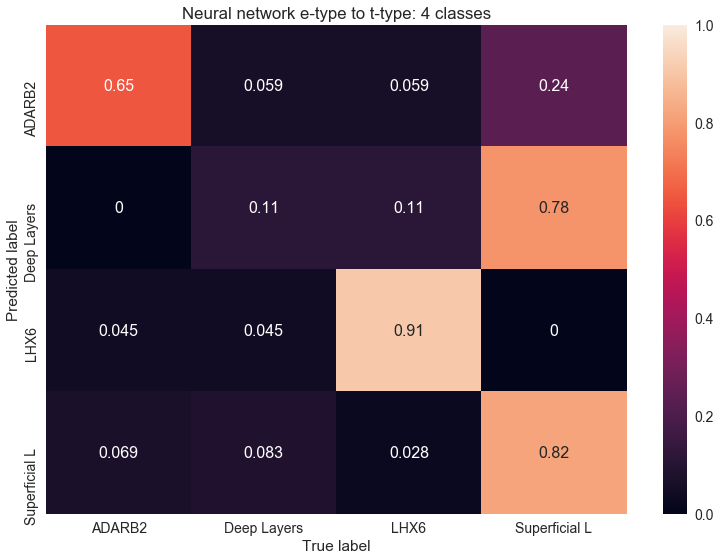

In [108]:

model_e2t_level_2=ephys_to_t_type_net(ephys_human_scaled,level_2_label,num_classes=4,out_layer=4)


### Level 2: random forest

Random forest precision: 0.8
Random forest f1 score: 0.8000000000000002
Random forest random labels performance: 0.23333333333333334

Random forest, important features:
upstroke_downstroke_ratio_long_square
upstroke_downstroke_ratio_short_square
latency
tau
threshold_i_short_square



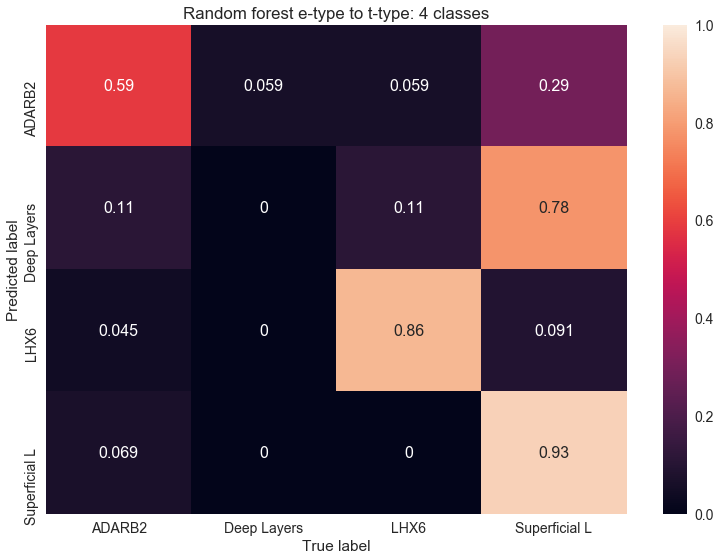

In [109]:

random_forest_plot(ephys_human_scaled,level_2_label,'Level 2', feature_names,num_classes=4,use_resampling=False)


### Level 2: SVM analysis

SVM precision: 0.8083333333333333
SVM random precision: 0.11666666666666667

SVM f1 score: 0.8083333333333333
SVM f1 random score: 0.11666666666666667


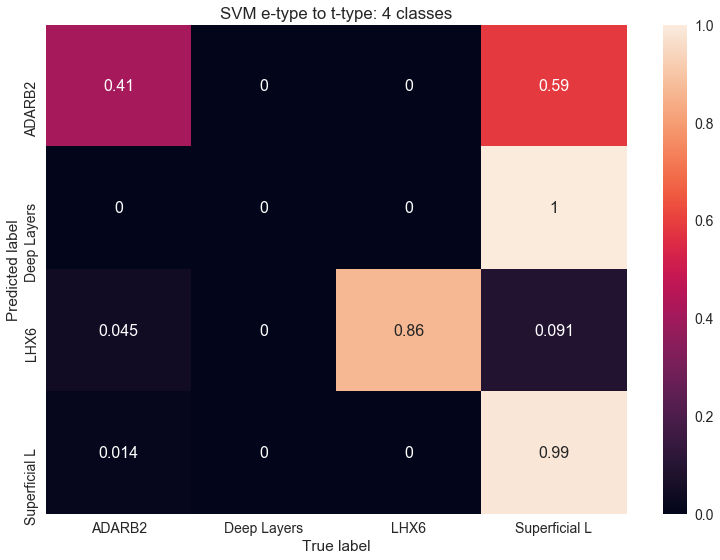

In [110]:

svm_analysis(ephys_human_scaled, level_2_label, 'Level 2', feature_names, num_classes=4,use_resampling=False)


### Level 3: neural netwok

y_test
[4 2 4 2 4 2 4 4 4 0 2 4 4 5 2 4 4 4 0 0 4 5 2 4 4 0 1 5 4 4 4 4 2 5 3 3 5
 2 5 2 4 4 4 4 4 0 4 4 4 4 4 4 2 4 4 4 4 4 4 4 0 5 4 4 4 4 4 4 0 2 4 4 2 5
 4 4 2 5 4 4 0 2 4 0 4 4 4 5 4 3 1 4 4 4 2 4 2 4 4 4 2 4 2 4 4 4 5 5 4 2 4
 1 4 4 4 4 1 4 1 4]

y_test_transformed
['Deep Layers' 'LAMP5/PAX6/Other' 'PVALB' 'SST' 'Superficial Layers' 'VIP']
Epoch 1/5000
476/476 [==============================] - 0s 1ms/step - loss: 1.8314 - categorical_accuracy: 0.1282
Epoch 2/5000
476/476 [==============================] - 0s 21us/step - loss: 1.7326 - categorical_accuracy: 0.2878
Epoch 3/5000
476/476 [==============================] - 0s 21us/step - loss: 1.6148 - categorical_accuracy: 0.4979
Epoch 4/5000
476/476 [==============================] - 0s 20us/step - loss: 1.4792 - categorical_accuracy: 0.5966
Epoch 5/5000
476/476 [==============================] - 0s 21us/step - loss: 1.3710 - categorical_accuracy: 0.6050
Epoch 6/5000
476/476 [==============================] - 0s 21us/step - loss: 1

476/476 [==============================] - 0s 23us/step - loss: 0.4265 - categorical_accuracy: 0.8613
Epoch 139/5000
476/476 [==============================] - 0s 23us/step - loss: 0.4177 - categorical_accuracy: 0.8529
Epoch 140/5000
476/476 [==============================] - 0s 22us/step - loss: 0.4293 - categorical_accuracy: 0.8655
Epoch 141/5000
476/476 [==============================] - 0s 23us/step - loss: 0.4338 - categorical_accuracy: 0.8508
Epoch 142/5000
476/476 [==============================] - 0s 23us/step - loss: 0.4588 - categorical_accuracy: 0.8487
Epoch 143/5000
476/476 [==============================] - 0s 26us/step - loss: 0.4342 - categorical_accuracy: 0.8550
Epoch 144/5000
476/476 [==============================] - 0s 26us/step - loss: 0.4092 - categorical_accuracy: 0.8487
Epoch 145/5000
476/476 [==============================] - 0s 25us/step - loss: 0.4163 - categorical_accuracy: 0.8613
Epoch 146/5000
476/476 [==============================] - 0s 24us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.2758 - categorical_accuracy: 0.8929
Epoch 279/5000
476/476 [==============================] - 0s 23us/step - loss: 0.2885 - categorical_accuracy: 0.8971
Epoch 280/5000
476/476 [==============================] - 0s 25us/step - loss: 0.2942 - categorical_accuracy: 0.8929
Epoch 281/5000
476/476 [==============================] - 0s 25us/step - loss: 0.2500 - categorical_accuracy: 0.9034
Epoch 282/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2661 - categorical_accuracy: 0.8971
Epoch 283/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2797 - categorical_accuracy: 0.8971
Epoch 284/5000
476/476 [==============================] - 0s 23us/step - loss: 0.2616 - categorical_accuracy: 0.9160
Epoch 285/5000
476/476 [==============================] - 0s 22us/step - loss: 0.2719 - categorical_accuracy: 0.9076
Epoch 286/5000
476/476 [==============================] - 0s 23us/step - loss: 

476/476 [==============================] - 0s 22us/step - loss: 0.1517 - categorical_accuracy: 0.9517
Epoch 419/5000
476/476 [==============================] - 0s 22us/step - loss: 0.1933 - categorical_accuracy: 0.9223
Epoch 420/5000
476/476 [==============================] - 0s 22us/step - loss: 0.1769 - categorical_accuracy: 0.9328
Epoch 421/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1609 - categorical_accuracy: 0.9370
Epoch 422/5000
476/476 [==============================] - 0s 23us/step - loss: 0.1979 - categorical_accuracy: 0.9202
Epoch 423/5000
476/476 [==============================] - 0s 23us/step - loss: 0.1632 - categorical_accuracy: 0.9328
Epoch 424/5000
476/476 [==============================] - 0s 22us/step - loss: 0.2094 - categorical_accuracy: 0.9244
Epoch 425/5000
476/476 [==============================] - 0s 22us/step - loss: 0.1844 - categorical_accuracy: 0.9265
Epoch 426/5000
476/476 [==============================] - 0s 23us/step - loss: 

476/476 [==============================] - 0s 29us/step - loss: 0.0868 - categorical_accuracy: 0.9748
Epoch 559/5000
476/476 [==============================] - 0s 31us/step - loss: 0.1098 - categorical_accuracy: 0.9643
Epoch 560/5000
476/476 [==============================] - 0s 31us/step - loss: 0.1237 - categorical_accuracy: 0.9601
Epoch 561/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1158 - categorical_accuracy: 0.9601
Epoch 562/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0972 - categorical_accuracy: 0.9622
Epoch 563/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1245 - categorical_accuracy: 0.9664
Epoch 564/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0925 - categorical_accuracy: 0.9706
Epoch 565/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1244 - categorical_accuracy: 0.9601
Epoch 566/5000
476/476 [==============================] - 0s 27us/step - loss: 

476/476 [==============================] - 0s 29us/step - loss: 0.0929 - categorical_accuracy: 0.9706
Epoch 699/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0706 - categorical_accuracy: 0.9769
Epoch 700/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0899 - categorical_accuracy: 0.9727
Epoch 701/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0786 - categorical_accuracy: 0.9727
Epoch 702/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0920 - categorical_accuracy: 0.9727
Epoch 703/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0614 - categorical_accuracy: 0.9790
Epoch 704/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0942 - categorical_accuracy: 0.9601
Epoch 705/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0578 - categorical_accuracy: 0.9895
Epoch 706/5000
476/476 [==============================] - 0s 26us/step - loss: 

476/476 [==============================] - 0s 26us/step - loss: 0.0536 - categorical_accuracy: 0.9832
Epoch 839/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0452 - categorical_accuracy: 0.9874
Epoch 840/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0561 - categorical_accuracy: 0.9811
Epoch 841/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0448 - categorical_accuracy: 0.9874
Epoch 842/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0472 - categorical_accuracy: 0.9853
Epoch 843/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0835 - categorical_accuracy: 0.9769
Epoch 844/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0520 - categorical_accuracy: 0.9853
Epoch 845/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0490 - categorical_accuracy: 0.9874
Epoch 846/5000
476/476 [==============================] - 0s 29us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.0437 - categorical_accuracy: 0.9832
Epoch 979/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0509 - categorical_accuracy: 0.9874
Epoch 980/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0431 - categorical_accuracy: 0.9832
Epoch 981/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0298 - categorical_accuracy: 0.9937
Epoch 982/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0410 - categorical_accuracy: 0.9874
Epoch 983/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0601 - categorical_accuracy: 0.9832
Epoch 984/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0353 - categorical_accuracy: 0.9916
Epoch 985/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0432 - categorical_accuracy: 0.9853
Epoch 986/5000
476/476 [==============================] - 0s 26us/step - loss: 

476/476 [==============================] - 0s 28us/step - loss: 0.0289 - categorical_accuracy: 0.9937
Epoch 1117/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0266 - categorical_accuracy: 0.9937
Epoch 1118/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0362 - categorical_accuracy: 0.9916
Epoch 1119/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0383 - categorical_accuracy: 0.9874
Epoch 1120/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0311 - categorical_accuracy: 0.9853
Epoch 1121/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0278 - categorical_accuracy: 0.9874
Epoch 1122/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0377 - categorical_accuracy: 0.9853
Epoch 1123/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0224 - categorical_accuracy: 0.9937
Epoch 1124/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0248 - categorical_accuracy: 0.9937
Epoch 1255/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0233 - categorical_accuracy: 0.9979
Epoch 1256/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0451 - categorical_accuracy: 0.9832
Epoch 1257/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0180 - categorical_accuracy: 0.9958
Epoch 1258/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0231 - categorical_accuracy: 0.9916
Epoch 1259/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0184 - categorical_accuracy: 0.9958
Epoch 1260/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0252 - categorical_accuracy: 0.9958
Epoch 1261/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0205 - categorical_accuracy: 0.9937
Epoch 1262/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 27us/step - loss: 0.0292 - categorical_accuracy: 0.9916
Epoch 1393/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0346 - categorical_accuracy: 0.9853
Epoch 1394/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0214 - categorical_accuracy: 0.9937
Epoch 1395/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0194 - categorical_accuracy: 0.9937
Epoch 1396/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0271 - categorical_accuracy: 0.9937
Epoch 1397/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0122 - categorical_accuracy: 0.9979
Epoch 1398/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0301 - categorical_accuracy: 0.9916
Epoch 1399/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0141 - categorical_accuracy: 0.9979
Epoch 1400/5000
476/476 [==============================] - 0s 30us/step 

476/476 [==============================] - 0s 28us/step - loss: 0.0116 - categorical_accuracy: 0.9979
Epoch 1531/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0182 - categorical_accuracy: 0.9937
Epoch 1532/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0222 - categorical_accuracy: 0.9916
Epoch 1533/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0125 - categorical_accuracy: 0.9979
Epoch 1534/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0133 - categorical_accuracy: 0.9979
Epoch 1535/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0101 - categorical_accuracy: 0.9979
Epoch 1536/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0138 - categorical_accuracy: 0.9979
Epoch 1537/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0252 - categorical_accuracy: 0.9895
Epoch 1538/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 28us/step - loss: 0.0163 - categorical_accuracy: 0.9937
Epoch 1669/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0288 - categorical_accuracy: 0.9937
Epoch 1670/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0094 - categorical_accuracy: 0.9979
Epoch 1671/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0088 - categorical_accuracy: 1.0000
Epoch 1672/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0155 - categorical_accuracy: 0.9979
Epoch 1673/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0089 - categorical_accuracy: 0.9979
Epoch 1674/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0120 - categorical_accuracy: 0.9937
Epoch 1675/5000
476/476 [==============================] - 0s 30us/step - loss: 0.0263 - categorical_accuracy: 0.9916
Epoch 1676/5000
476/476 [==============================] - 0s 33us/step 

476/476 [==============================] - 0s 31us/step - loss: 0.0081 - categorical_accuracy: 0.9979
Epoch 1807/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0169 - categorical_accuracy: 0.9916
Epoch 1808/5000
476/476 [==============================] - 0s 29us/step - loss: 0.0272 - categorical_accuracy: 0.9958
Epoch 1809/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0154 - categorical_accuracy: 0.9979
Epoch 1810/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0192 - categorical_accuracy: 0.9937
Epoch 1811/5000
476/476 [==============================] - 0s 34us/step - loss: 0.0038 - categorical_accuracy: 1.0000
Epoch 1812/5000
476/476 [==============================] - 0s 34us/step - loss: 0.0249 - categorical_accuracy: 0.9895
Epoch 1813/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0146 - categorical_accuracy: 0.9958
Epoch 1814/5000
476/476 [==============================] - 0s 31us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0157 - categorical_accuracy: 0.9937
Epoch 1876/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0172 - categorical_accuracy: 0.9979
Epoch 1877/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0146 - categorical_accuracy: 0.9958
Epoch 1878/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0170 - categorical_accuracy: 0.9937
Epoch 1879/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0095 - categorical_accuracy: 0.9979
Epoch 1880/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0098 - categorical_accuracy: 0.9979
Epoch 1881/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0094 - categorical_accuracy: 0.9979
Epoch 1882/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0109 - categorical_accuracy: 0.9979
Epoch 1883/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 36us/step - loss: 0.0150 - categorical_accuracy: 0.9937
Epoch 2014/5000
476/476 [==============================] - 0s 34us/step - loss: 0.0150 - categorical_accuracy: 0.9958
Epoch 2015/5000
476/476 [==============================] - 0s 35us/step - loss: 0.0083 - categorical_accuracy: 1.0000
Epoch 2016/5000
476/476 [==============================] - 0s 37us/step - loss: 0.0142 - categorical_accuracy: 0.9958
Epoch 2017/5000
476/476 [==============================] - 0s 43us/step - loss: 0.0151 - categorical_accuracy: 0.9916
Epoch 2018/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0129 - categorical_accuracy: 0.9937
Epoch 2019/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0135 - categorical_accuracy: 0.9958
Epoch 2020/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0120 - categorical_accuracy: 0.9979
Epoch 2021/5000
476/476 [==============================] - 0s 30us/step 

476/476 [==============================] - 0s 32us/step - loss: 0.0071 - categorical_accuracy: 1.0000
Epoch 2152/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0287 - categorical_accuracy: 0.9937
Epoch 2153/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0053 - categorical_accuracy: 1.0000
Epoch 2154/5000
476/476 [==============================] - 0s 31us/step - loss: 0.0082 - categorical_accuracy: 0.9958
Epoch 2155/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0096 - categorical_accuracy: 0.9979
Epoch 2156/5000
476/476 [==============================] - 0s 33us/step - loss: 0.0073 - categorical_accuracy: 0.9979
Epoch 2157/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0109 - categorical_accuracy: 0.9979
Epoch 2158/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0072 - categorical_accuracy: 0.9979
Epoch 2159/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0129 - categorical_accuracy: 0.9958
Epoch 2290/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0080 - categorical_accuracy: 1.0000
Epoch 2291/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0237 - categorical_accuracy: 0.9937
Epoch 2292/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0119 - categorical_accuracy: 0.9937
Epoch 2293/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0241 - categorical_accuracy: 0.9895
Epoch 2294/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0090 - categorical_accuracy: 0.9979
Epoch 2295/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0111 - categorical_accuracy: 0.9979
Epoch 2296/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0036 - categorical_accuracy: 1.0000
Epoch 2297/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 27us/step - loss: 0.0114 - categorical_accuracy: 0.9937
Epoch 2428/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0106 - categorical_accuracy: 0.9958
Epoch 2429/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0082 - categorical_accuracy: 0.9979
Epoch 2430/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0046 - categorical_accuracy: 1.0000
Epoch 2431/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0046 - categorical_accuracy: 1.0000
Epoch 2432/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0333 - categorical_accuracy: 0.9916
Epoch 2433/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0166 - categorical_accuracy: 0.9958
Epoch 2434/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0080 - categorical_accuracy: 0.9979
Epoch 2435/5000
476/476 [==============================] - 0s 22us/step 

/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115107). Check your callbacks.
  % delta_t_median)



476/476 [==============================] - 0s 23us/step - loss: 0.0064 - categorical_accuracy: 0.9979
Epoch 2442/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 2443/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0034 - categorical_accuracy: 1.0000
Epoch 2444/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0083 - categorical_accuracy: 0.9979
Epoch 2445/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0122 - categorical_accuracy: 0.9958
Epoch 2446/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0144 - categorical_accuracy: 0.9979
Epoch 2447/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0040 - categorical_accuracy: 1.0000
Epoch 2448/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0087 - categorical_accuracy: 0.9979
Epoch 2449/5000
476/476 [==============================] - 0s 26us/step

476/476 [==============================] - 0s 22us/step - loss: 0.0158 - categorical_accuracy: 0.9958
Epoch 2580/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0105 - categorical_accuracy: 0.9958
Epoch 2581/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 2582/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0075 - categorical_accuracy: 0.9979
Epoch 2583/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0202 - categorical_accuracy: 0.9979
Epoch 2584/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0059 - categorical_accuracy: 1.0000
Epoch 2585/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0061 - categorical_accuracy: 1.0000
Epoch 2586/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0124 - categorical_accuracy: 0.9958
Epoch 2587/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0158 - categorical_accuracy: 0.9958
Epoch 2718/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0094 - categorical_accuracy: 0.9979
Epoch 2719/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 2720/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 2721/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0048 - categorical_accuracy: 1.0000
Epoch 2722/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0124 - categorical_accuracy: 0.9958
Epoch 2723/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0095 - categorical_accuracy: 0.9979
Epoch 2724/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0042 - categorical_accuracy: 1.0000
Epoch 2725/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 2856/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0109 - categorical_accuracy: 0.9979
Epoch 2857/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 2858/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0046 - categorical_accuracy: 0.9979
Epoch 2859/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0103 - categorical_accuracy: 0.9958
Epoch 2860/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 2861/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0068 - categorical_accuracy: 0.9979
Epoch 2862/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0065 - categorical_accuracy: 0.9979
Epoch 2863/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 2994/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 2995/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0070 - categorical_accuracy: 0.9958
Epoch 2996/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0060 - categorical_accuracy: 0.9958
Epoch 2997/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 2998/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0055 - categorical_accuracy: 1.0000
Epoch 2999/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0072 - categorical_accuracy: 0.9979
Epoch 3000/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0169 - categorical_accuracy: 0.9979
Epoch 3001/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0101 - categorical_accuracy: 0.9979
Epoch 3132/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0034 - categorical_accuracy: 1.0000
Epoch 3133/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0052 - categorical_accuracy: 0.9979
Epoch 3134/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0167 - categorical_accuracy: 0.9958
Epoch 3135/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0021 - categorical_accuracy: 1.0000
Epoch 3136/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0122 - categorical_accuracy: 0.9937
Epoch 3137/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 3138/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0123 - categorical_accuracy: 0.9937
Epoch 3139/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0059 - categorical_accuracy: 0.9979
Epoch 3270/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0159 - categorical_accuracy: 0.9937
Epoch 3271/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0167 - categorical_accuracy: 0.9958
Epoch 3272/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0058 - categorical_accuracy: 0.9979
Epoch 3273/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0188 - categorical_accuracy: 0.9937
Epoch 3274/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 3275/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 3276/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0072 - categorical_accuracy: 0.9979
Epoch 3277/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0043 - categorical_accuracy: 1.0000
Epoch 3408/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0056 - categorical_accuracy: 1.0000
Epoch 3409/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0042 - categorical_accuracy: 0.9979
Epoch 3410/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0047 - categorical_accuracy: 1.0000
Epoch 3411/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0073 - categorical_accuracy: 0.9979
Epoch 3412/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0071 - categorical_accuracy: 0.9958
Epoch 3413/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0051 - categorical_accuracy: 0.9979
Epoch 3414/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0065 - categorical_accuracy: 0.9979
Epoch 3415/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0012 - categorical_accuracy: 1.0000
Epoch 3546/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0042 - categorical_accuracy: 0.9979
Epoch 3547/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 3548/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0061 - categorical_accuracy: 0.9958
Epoch 3549/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0125 - categorical_accuracy: 0.9937
Epoch 3550/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0081 - categorical_accuracy: 0.9958
Epoch 3551/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0246 - categorical_accuracy: 0.9958
Epoch 3552/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0061 - categorical_accuracy: 0.9979
Epoch 3553/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0033 - categorical_accuracy: 0.9979
Epoch 3684/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0048 - categorical_accuracy: 0.9979
Epoch 3685/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 3686/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0113 - categorical_accuracy: 0.9937
Epoch 3687/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0263 - categorical_accuracy: 0.9937
Epoch 3688/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0062 - categorical_accuracy: 0.9979
Epoch 3689/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 3690/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0069 - categorical_accuracy: 0.9979
Epoch 3691/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 3822/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0014 - categorical_accuracy: 1.0000
Epoch 3823/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0054 - categorical_accuracy: 1.0000
Epoch 3824/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0046 - categorical_accuracy: 0.9979
Epoch 3825/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0067 - categorical_accuracy: 0.9958
Epoch 3826/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0047 - categorical_accuracy: 0.9979
Epoch 3827/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 3828/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 3829/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 22us/step - loss: 0.0030 - categorical_accuracy: 1.0000
Epoch 3960/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0099 - categorical_accuracy: 0.9979
Epoch 3961/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 3962/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0034 - categorical_accuracy: 1.0000
Epoch 3963/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0031 - categorical_accuracy: 1.0000
Epoch 3964/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 3965/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0156 - categorical_accuracy: 0.9958
Epoch 3966/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0069 - categorical_accuracy: 0.9979
Epoch 3967/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0043 - categorical_accuracy: 0.9979
Epoch 4098/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0221 - categorical_accuracy: 0.9979
Epoch 4099/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 4100/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4101/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4102/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0071 - categorical_accuracy: 0.9979
Epoch 4103/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0037 - categorical_accuracy: 1.0000
Epoch 4104/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0016 - categorical_accuracy: 1.0000
Epoch 4105/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 4236/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0035 - categorical_accuracy: 1.0000
Epoch 4237/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0074 - categorical_accuracy: 0.9979
Epoch 4238/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 4239/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0040 - categorical_accuracy: 0.9979
Epoch 4240/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 4241/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4242/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0036 - categorical_accuracy: 1.0000
Epoch 4243/5000
476/476 [==============================] - 0s 22us/step 

476/476 [==============================] - 0s 24us/step - loss: 9.4100e-04 - categorical_accuracy: 1.0000
Epoch 4374/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0068 - categorical_accuracy: 0.9958
Epoch 4375/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0102 - categorical_accuracy: 0.9979
Epoch 4376/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4377/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0028 - categorical_accuracy: 1.0000
Epoch 4378/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0034 - categorical_accuracy: 1.0000
Epoch 4379/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0080 - categorical_accuracy: 0.9979
Epoch 4380/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 4381/5000
476/476 [==============================] - 0s 23us/s

476/476 [==============================] - 0s 21us/step - loss: 0.0123 - categorical_accuracy: 0.9979
Epoch 4512/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0051 - categorical_accuracy: 0.9958
Epoch 4513/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 4514/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 4515/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 4516/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4517/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0066 - categorical_accuracy: 0.9958
Epoch 4518/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4519/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4650/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 4651/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 4652/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0027 - categorical_accuracy: 1.0000
Epoch 4653/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0242 - categorical_accuracy: 0.9937
Epoch 4654/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0057 - categorical_accuracy: 0.9979
Epoch 4655/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0092 - categorical_accuracy: 0.9958
Epoch 4656/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0041 - categorical_accuracy: 0.9979
Epoch 4657/5000
476/476 [==============================] - 0s 21us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 4788/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 4789/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0017 - categorical_accuracy: 1.0000
Epoch 4790/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0231 - categorical_accuracy: 0.9916
Epoch 4791/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0013 - categorical_accuracy: 1.0000
Epoch 4792/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0015 - categorical_accuracy: 1.0000
Epoch 4793/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0060 - categorical_accuracy: 0.9979
Epoch 4794/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0151 - categorical_accuracy: 0.9937
Epoch 4795/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 21us/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 4926/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0044 - categorical_accuracy: 0.9979
Epoch 4927/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0031 - categorical_accuracy: 1.0000
Epoch 4928/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0059 - categorical_accuracy: 0.9979
Epoch 4929/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0076 - categorical_accuracy: 0.9958
Epoch 4930/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 4931/5000
476/476 [==============================] - 0s 21us/step - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 4932/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0019 - categorical_accuracy: 1.0000
Epoch 4933/5000
476/476 [==============================] - 0s 22us/step 

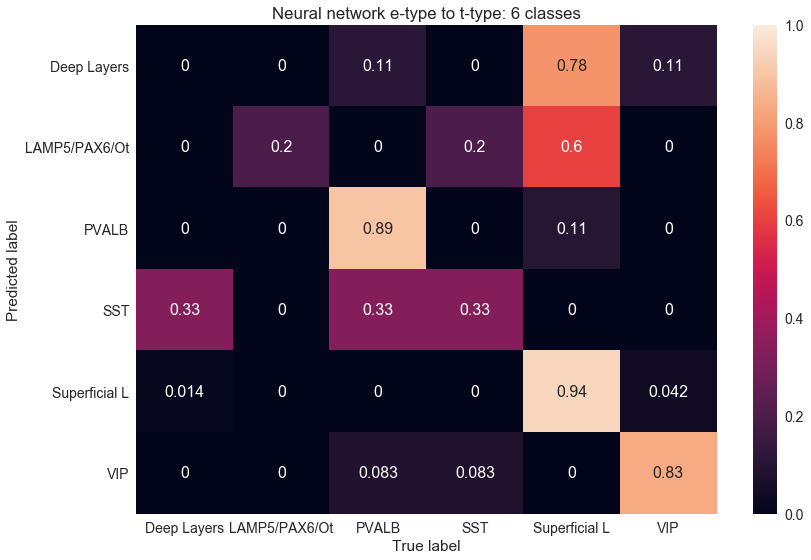

In [111]:

model_e2t_level_3=ephys_to_t_type_net(ephys_human_scaled,level_3_label,num_classes=6,out_layer=6)


### Level 3: random forest

Random forest precision: 0.825
Random forest f1 score: 0.825
Random forest random labels performance: 0.08333333333333333

Random forest, important features:
upstroke_downstroke_ratio_long_square
upstroke_downstroke_ratio_short_square
latency
tau
f_i_curve_slope



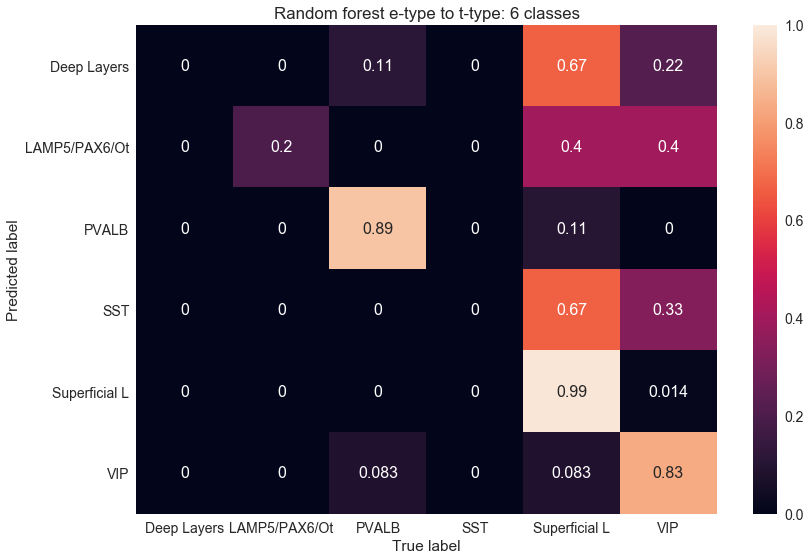

In [112]:

random_forest_plot(ephys_human_scaled,level_3_label,'Level 3', feature_names,num_classes=6,use_resampling=False)


### Level 3: SVM

SVM precision: 0.7833333333333333
SVM random precision: 0.06666666666666667

SVM f1 score: 0.7833333333333333
SVM f1 random score: 0.06666666666666667


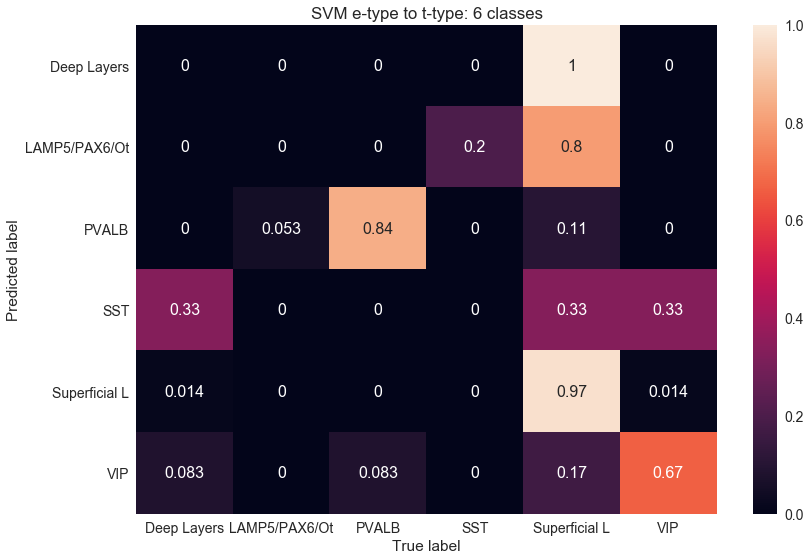

In [113]:

svm_analysis(ephys_human_scaled, level_3_label, 'Level 3', feature_names,num_classes=6, use_resampling=False)


### Level 4: neural network

Could not stratify classes
y_test
[ 0 25  5  4  0 25 25  0  3 16  5  5  3 11 12  0  0 10 17  8  5 16 25  0
 20  0 17  0  5  8 21  3  0 14 25  0  3  0 26  0  3  0 25 25  0  1  0 12
  0 25  5  0  2  0  3  0  3  7  5  3  0 17  3  3  0 18  3 25  0  0  3 11
  4  3  3 25 12 10 12 11 18  0  5 12  5  3 25  0  0  0 25  3  5  0 28  5
  3 12  5  3  0 12  5  2  0  0  5 16  5  3  1  0  0 21  0  0  0  5 15 16]

y_test_transformed
['Exc L2-3 LINC00507' 'Exc L3-4 RORB CARM1P1' 'Exc L3-5 RORB COL22A1'
 'Exc L3-5 RORB ESR1' 'Exc L4-5 RORB DAPK2' 'Exc L4-5 RORB LCN15'
 'Exc L5-6 FEZF2 ABO' 'Exc L5-6 RORB TTC12' 'Exc L5-6 THEMIS POSTN'
 'Inh L1-2 LAMP5 DBP' 'Inh L1-2 PAX6 CDH12' 'Inh L1-2 VIP LBH'
 'Inh L1-2 VIP PCDH20' 'Inh L1-2 VIP TSPAN12' 'Inh L1-3 VIP ADAMTSL1'
 'Inh L1-3 VIP CCDC184' 'Inh L1-4 VIP CHRNA6' 'Inh L1-4 VIP TRPC6'
 'Inh L2-5 PVALB ETS1' 'Inh L3-6 VIP HS3ST3A1' 'Inh L4-6 SST B3GAT2']
Epoch 1/5000
476/476 [==============================] - 0s 1ms/step - loss: 3.9333 - categorical_accuracy:

476/476 [==============================] - 0s 20us/step - loss: 1.3511 - categorical_accuracy: 0.6618
Epoch 65/5000
476/476 [==============================] - 0s 21us/step - loss: 1.3909 - categorical_accuracy: 0.6345
Epoch 66/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3495 - categorical_accuracy: 0.6513
Epoch 67/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3787 - categorical_accuracy: 0.6492
Epoch 68/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3302 - categorical_accuracy: 0.6639
Epoch 69/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3459 - categorical_accuracy: 0.6555
Epoch 70/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3613 - categorical_accuracy: 0.6534
Epoch 71/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3291 - categorical_accuracy: 0.6576
Epoch 72/5000
476/476 [==============================] - 0s 20us/step - loss: 1.3302 -

476/476 [==============================] - 0s 24us/step - loss: 0.8144 - categorical_accuracy: 0.7689
Epoch 205/5000
476/476 [==============================] - 0s 24us/step - loss: 0.7793 - categorical_accuracy: 0.7626
Epoch 206/5000
476/476 [==============================] - 0s 23us/step - loss: 0.8515 - categorical_accuracy: 0.7500
Epoch 207/5000
476/476 [==============================] - 0s 23us/step - loss: 0.7959 - categorical_accuracy: 0.7626
Epoch 208/5000
476/476 [==============================] - 0s 22us/step - loss: 0.8340 - categorical_accuracy: 0.7584
Epoch 209/5000
476/476 [==============================] - 0s 23us/step - loss: 0.8031 - categorical_accuracy: 0.7647
Epoch 210/5000
476/476 [==============================] - 0s 23us/step - loss: 0.8231 - categorical_accuracy: 0.7416
Epoch 211/5000
476/476 [==============================] - 0s 22us/step - loss: 0.7966 - categorical_accuracy: 0.7563
Epoch 212/5000
476/476 [==============================] - 0s 23us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.5982 - categorical_accuracy: 0.8109
Epoch 345/5000
476/476 [==============================] - 0s 24us/step - loss: 0.6060 - categorical_accuracy: 0.8004
Epoch 346/5000
476/476 [==============================] - 0s 24us/step - loss: 0.5637 - categorical_accuracy: 0.8151
Epoch 347/5000
476/476 [==============================] - 0s 23us/step - loss: 0.5812 - categorical_accuracy: 0.8151
Epoch 348/5000
476/476 [==============================] - 0s 24us/step - loss: 0.5466 - categorical_accuracy: 0.8193
Epoch 349/5000
476/476 [==============================] - 0s 23us/step - loss: 0.5728 - categorical_accuracy: 0.8235
Epoch 350/5000
476/476 [==============================] - 0s 24us/step - loss: 0.5558 - categorical_accuracy: 0.8235
Epoch 351/5000
476/476 [==============================] - 0s 23us/step - loss: 0.5215 - categorical_accuracy: 0.8424
Epoch 352/5000
476/476 [==============================] - 0s 22us/step - loss: 

476/476 [==============================] - 0s 25us/step - loss: 0.3949 - categorical_accuracy: 0.8655
Epoch 485/5000
476/476 [==============================] - 0s 25us/step - loss: 0.4471 - categorical_accuracy: 0.8550
Epoch 486/5000
476/476 [==============================] - 0s 25us/step - loss: 0.4239 - categorical_accuracy: 0.8592
Epoch 487/5000
476/476 [==============================] - 0s 25us/step - loss: 0.3996 - categorical_accuracy: 0.8803
Epoch 488/5000
476/476 [==============================] - 0s 26us/step - loss: 0.4424 - categorical_accuracy: 0.8571
Epoch 489/5000
476/476 [==============================] - 0s 24us/step - loss: 0.4297 - categorical_accuracy: 0.8592
Epoch 490/5000
476/476 [==============================] - 0s 24us/step - loss: 0.4125 - categorical_accuracy: 0.8655
Epoch 491/5000
476/476 [==============================] - 0s 24us/step - loss: 0.4033 - categorical_accuracy: 0.8655
Epoch 492/5000
476/476 [==============================] - 0s 24us/step - loss: 

476/476 [==============================] - 0s 28us/step - loss: 0.2886 - categorical_accuracy: 0.9097
Epoch 625/5000
476/476 [==============================] - 0s 26us/step - loss: 0.3178 - categorical_accuracy: 0.8971
Epoch 626/5000
476/476 [==============================] - 0s 26us/step - loss: 0.3142 - categorical_accuracy: 0.8971
Epoch 627/5000
476/476 [==============================] - 0s 25us/step - loss: 0.2979 - categorical_accuracy: 0.8866
Epoch 628/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2888 - categorical_accuracy: 0.9055
Epoch 629/5000
476/476 [==============================] - 0s 25us/step - loss: 0.3149 - categorical_accuracy: 0.8950
Epoch 630/5000
476/476 [==============================] - 0s 24us/step - loss: 0.3011 - categorical_accuracy: 0.9076
Epoch 631/5000
476/476 [==============================] - 0s 25us/step - loss: 0.3273 - categorical_accuracy: 0.8824
Epoch 632/5000
476/476 [==============================] - 0s 25us/step - loss: 

476/476 [==============================] - 0s 24us/step - loss: 0.2908 - categorical_accuracy: 0.9034
Epoch 765/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2983 - categorical_accuracy: 0.9034
Epoch 766/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2163 - categorical_accuracy: 0.9223
Epoch 767/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2641 - categorical_accuracy: 0.9181
Epoch 768/5000
476/476 [==============================] - 0s 23us/step - loss: 0.2516 - categorical_accuracy: 0.9181
Epoch 769/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2743 - categorical_accuracy: 0.9097
Epoch 770/5000
476/476 [==============================] - 0s 26us/step - loss: 0.2372 - categorical_accuracy: 0.9286
Epoch 771/5000
476/476 [==============================] - 0s 26us/step - loss: 0.2836 - categorical_accuracy: 0.9055
Epoch 772/5000
476/476 [==============================] - 0s 26us/step - loss: 

476/476 [==============================] - 0s 25us/step - loss: 0.1956 - categorical_accuracy: 0.9433
Epoch 905/5000
476/476 [==============================] - 0s 26us/step - loss: 0.2307 - categorical_accuracy: 0.9286
Epoch 906/5000
476/476 [==============================] - 0s 26us/step - loss: 0.2317 - categorical_accuracy: 0.9454
Epoch 907/5000
476/476 [==============================] - 0s 25us/step - loss: 0.2259 - categorical_accuracy: 0.9160
Epoch 908/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1748 - categorical_accuracy: 0.9538
Epoch 909/5000
476/476 [==============================] - 0s 23us/step - loss: 0.1919 - categorical_accuracy: 0.9433
Epoch 910/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2233 - categorical_accuracy: 0.9244
Epoch 911/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2146 - categorical_accuracy: 0.9223
Epoch 912/5000
476/476 [==============================] - 0s 25us/step - loss: 

476/476 [==============================] - 0s 25us/step - loss: 0.1531 - categorical_accuracy: 0.9475
Epoch 1044/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1753 - categorical_accuracy: 0.9412
Epoch 1045/5000
476/476 [==============================] - 0s 23us/step - loss: 0.1346 - categorical_accuracy: 0.9559
Epoch 1046/5000
476/476 [==============================] - 0s 23us/step - loss: 0.2039 - categorical_accuracy: 0.9223
Epoch 1047/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1742 - categorical_accuracy: 0.9517
Epoch 1048/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1481 - categorical_accuracy: 0.9580
Epoch 1049/5000
476/476 [==============================] - 0s 24us/step - loss: 0.2108 - categorical_accuracy: 0.9202
Epoch 1050/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1734 - categorical_accuracy: 0.9412
Epoch 1051/5000
476/476 [==============================] - 0s 26us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.1317 - categorical_accuracy: 0.9664
Epoch 1182/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1453 - categorical_accuracy: 0.9643
Epoch 1183/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1165 - categorical_accuracy: 0.9643
Epoch 1184/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1560 - categorical_accuracy: 0.9454
Epoch 1185/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1394 - categorical_accuracy: 0.9517
Epoch 1186/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1797 - categorical_accuracy: 0.9412
Epoch 1187/5000
476/476 [==============================] - 0s 28us/step - loss: 0.1571 - categorical_accuracy: 0.9496
Epoch 1188/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1280 - categorical_accuracy: 0.9538
Epoch 1189/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.1306 - categorical_accuracy: 0.9601
Epoch 1320/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1199 - categorical_accuracy: 0.9622
Epoch 1321/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1114 - categorical_accuracy: 0.9643
Epoch 1322/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1156 - categorical_accuracy: 0.9601
Epoch 1323/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1154 - categorical_accuracy: 0.9601
Epoch 1324/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1078 - categorical_accuracy: 0.9706
Epoch 1325/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1049 - categorical_accuracy: 0.9664
Epoch 1326/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1373 - categorical_accuracy: 0.9559
Epoch 1327/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0982 - categorical_accuracy: 0.9643
Epoch 1458/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0965 - categorical_accuracy: 0.9685
Epoch 1459/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1228 - categorical_accuracy: 0.9643
Epoch 1460/5000
476/476 [==============================] - 0s 25us/step - loss: 0.1036 - categorical_accuracy: 0.9727
Epoch 1461/5000
476/476 [==============================] - 0s 26us/step - loss: 0.1097 - categorical_accuracy: 0.9685
Epoch 1462/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1222 - categorical_accuracy: 0.9538
Epoch 1463/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0874 - categorical_accuracy: 0.9769
Epoch 1464/5000
476/476 [==============================] - 0s 27us/step - loss: 0.1068 - categorical_accuracy: 0.9580
Epoch 1465/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0935 - categorical_accuracy: 0.9769
Epoch 1596/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0996 - categorical_accuracy: 0.9664
Epoch 1597/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0928 - categorical_accuracy: 0.9706
Epoch 1598/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1391 - categorical_accuracy: 0.9559
Epoch 1599/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0874 - categorical_accuracy: 0.9748
Epoch 1600/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1216 - categorical_accuracy: 0.9454
Epoch 1601/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0874 - categorical_accuracy: 0.9706
Epoch 1602/5000
476/476 [==============================] - 0s 24us/step - loss: 0.1173 - categorical_accuracy: 0.9601
Epoch 1603/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 27us/step - loss: 0.1048 - categorical_accuracy: 0.9727
Epoch 1734/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0711 - categorical_accuracy: 0.9790
Epoch 1735/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0620 - categorical_accuracy: 0.9811
Epoch 1736/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0987 - categorical_accuracy: 0.9580
Epoch 1737/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0652 - categorical_accuracy: 0.9853
Epoch 1738/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0727 - categorical_accuracy: 0.9790
Epoch 1739/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0796 - categorical_accuracy: 0.9769
Epoch 1740/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0810 - categorical_accuracy: 0.9748
Epoch 1741/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.1060 - categorical_accuracy: 0.9622
Epoch 1872/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0693 - categorical_accuracy: 0.9706
Epoch 1873/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0811 - categorical_accuracy: 0.9685
Epoch 1874/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0758 - categorical_accuracy: 0.9748
Epoch 1875/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0523 - categorical_accuracy: 0.9853
Epoch 1876/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0917 - categorical_accuracy: 0.9685
Epoch 1877/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0779 - categorical_accuracy: 0.9811
Epoch 1878/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0773 - categorical_accuracy: 0.9727
Epoch 1879/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0494 - categorical_accuracy: 0.9853
Epoch 2010/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0840 - categorical_accuracy: 0.9769
Epoch 2011/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0505 - categorical_accuracy: 0.9853
Epoch 2012/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0805 - categorical_accuracy: 0.9790
Epoch 2013/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0640 - categorical_accuracy: 0.9811
Epoch 2014/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0565 - categorical_accuracy: 0.9811
Epoch 2015/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0753 - categorical_accuracy: 0.9727
Epoch 2016/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0565 - categorical_accuracy: 0.9832
Epoch 2017/5000
476/476 [==============================] - 0s 26us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0620 - categorical_accuracy: 0.9769
Epoch 2148/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0841 - categorical_accuracy: 0.9748
Epoch 2149/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0812 - categorical_accuracy: 0.9706
Epoch 2150/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0579 - categorical_accuracy: 0.9790
Epoch 2151/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0870 - categorical_accuracy: 0.9727
Epoch 2152/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0388 - categorical_accuracy: 0.9895
Epoch 2153/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0617 - categorical_accuracy: 0.9727
Epoch 2154/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0606 - categorical_accuracy: 0.9853
Epoch 2155/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 33us/step - loss: 0.0582 - categorical_accuracy: 0.9853
Epoch 2286/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0653 - categorical_accuracy: 0.9790
Epoch 2287/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0541 - categorical_accuracy: 0.9832
Epoch 2288/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0463 - categorical_accuracy: 0.9874
Epoch 2289/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0820 - categorical_accuracy: 0.9748
Epoch 2290/5000
476/476 [==============================] - 0s 32us/step - loss: 0.0512 - categorical_accuracy: 0.9832
Epoch 2291/5000
476/476 [==============================] - 0s 28us/step - loss: 0.0568 - categorical_accuracy: 0.9790
Epoch 2292/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0430 - categorical_accuracy: 0.9853
Epoch 2293/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0501 - categorical_accuracy: 0.9811
Epoch 2424/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0358 - categorical_accuracy: 0.9895
Epoch 2425/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0455 - categorical_accuracy: 0.9811
Epoch 2426/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0721 - categorical_accuracy: 0.9769
Epoch 2427/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0463 - categorical_accuracy: 0.9853
Epoch 2428/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0394 - categorical_accuracy: 0.9874
Epoch 2429/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0738 - categorical_accuracy: 0.9790
Epoch 2430/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0453 - categorical_accuracy: 0.9832
Epoch 2431/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0657 - categorical_accuracy: 0.9790
Epoch 2562/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0598 - categorical_accuracy: 0.9748
Epoch 2563/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0475 - categorical_accuracy: 0.9832
Epoch 2564/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0399 - categorical_accuracy: 0.9853
Epoch 2565/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0541 - categorical_accuracy: 0.9790
Epoch 2566/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0487 - categorical_accuracy: 0.9832
Epoch 2567/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0342 - categorical_accuracy: 0.9895
Epoch 2568/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0788 - categorical_accuracy: 0.9706
Epoch 2569/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0448 - categorical_accuracy: 0.9874
Epoch 2700/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0509 - categorical_accuracy: 0.9853
Epoch 2701/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0469 - categorical_accuracy: 0.9811
Epoch 2702/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0350 - categorical_accuracy: 0.9874
Epoch 2703/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0698 - categorical_accuracy: 0.9769
Epoch 2704/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0374 - categorical_accuracy: 0.9895
Epoch 2705/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0412 - categorical_accuracy: 0.9874
Epoch 2706/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0321 - categorical_accuracy: 0.9916
Epoch 2707/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0432 - categorical_accuracy: 0.9895
Epoch 2838/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0471 - categorical_accuracy: 0.9853
Epoch 2839/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0377 - categorical_accuracy: 0.9958
Epoch 2840/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0349 - categorical_accuracy: 0.9874
Epoch 2841/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0307 - categorical_accuracy: 0.9895
Epoch 2842/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0370 - categorical_accuracy: 0.9874
Epoch 2843/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0364 - categorical_accuracy: 0.9916
Epoch 2844/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0499 - categorical_accuracy: 0.9874
Epoch 2845/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0315 - categorical_accuracy: 0.9895
Epoch 2976/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0489 - categorical_accuracy: 0.9874
Epoch 2977/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0225 - categorical_accuracy: 0.9916
Epoch 2978/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0583 - categorical_accuracy: 0.9832
Epoch 2979/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0259 - categorical_accuracy: 0.9937
Epoch 2980/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0288 - categorical_accuracy: 0.9895
Epoch 2981/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0499 - categorical_accuracy: 0.9874
Epoch 2982/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0736 - categorical_accuracy: 0.9832
Epoch 2983/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0275 - categorical_accuracy: 0.9895
Epoch 3114/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0541 - categorical_accuracy: 0.9811
Epoch 3115/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0584 - categorical_accuracy: 0.9811
Epoch 3116/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0300 - categorical_accuracy: 0.9937
Epoch 3117/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0349 - categorical_accuracy: 0.9874
Epoch 3118/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0275 - categorical_accuracy: 0.9937
Epoch 3119/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0401 - categorical_accuracy: 0.9832
Epoch 3120/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0363 - categorical_accuracy: 0.9874
Epoch 3121/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 27us/step - loss: 0.0294 - categorical_accuracy: 0.9895
Epoch 3252/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0343 - categorical_accuracy: 0.9895
Epoch 3253/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0347 - categorical_accuracy: 0.9874
Epoch 3254/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0392 - categorical_accuracy: 0.9874
Epoch 3255/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0359 - categorical_accuracy: 0.9853
Epoch 3256/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0366 - categorical_accuracy: 0.9832
Epoch 3257/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0541 - categorical_accuracy: 0.9853
Epoch 3258/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0416 - categorical_accuracy: 0.9853
Epoch 3259/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 28us/step - loss: 0.0238 - categorical_accuracy: 0.9958
Epoch 3390/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0241 - categorical_accuracy: 0.9916
Epoch 3391/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0233 - categorical_accuracy: 0.9937
Epoch 3392/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0178 - categorical_accuracy: 0.9958
Epoch 3393/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0348 - categorical_accuracy: 0.9916
Epoch 3394/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0264 - categorical_accuracy: 0.9937
Epoch 3395/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0415 - categorical_accuracy: 0.9895
Epoch 3396/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0231 - categorical_accuracy: 0.9916
Epoch 3397/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0322 - categorical_accuracy: 0.9958
Epoch 3528/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0486 - categorical_accuracy: 0.9832
Epoch 3529/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0368 - categorical_accuracy: 0.9853
Epoch 3530/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0216 - categorical_accuracy: 0.9958
Epoch 3531/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0268 - categorical_accuracy: 0.9895
Epoch 3532/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0557 - categorical_accuracy: 0.9832
Epoch 3533/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0392 - categorical_accuracy: 0.9916
Epoch 3534/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0525 - categorical_accuracy: 0.9748
Epoch 3535/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0394 - categorical_accuracy: 0.9874
Epoch 3666/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0106 - categorical_accuracy: 1.0000
Epoch 3667/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0178 - categorical_accuracy: 0.9958
Epoch 3668/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0201 - categorical_accuracy: 0.9958
Epoch 3669/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0331 - categorical_accuracy: 0.9832
Epoch 3670/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0227 - categorical_accuracy: 0.9937
Epoch 3671/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0249 - categorical_accuracy: 0.9916
Epoch 3672/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0198 - categorical_accuracy: 0.9958
Epoch 3673/5000
476/476 [==============================] - 0s 27us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0238 - categorical_accuracy: 0.9874
Epoch 3804/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0202 - categorical_accuracy: 0.9937
Epoch 3805/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0380 - categorical_accuracy: 0.9874
Epoch 3806/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0287 - categorical_accuracy: 0.9895
Epoch 3807/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0163 - categorical_accuracy: 0.9979
Epoch 3808/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0180 - categorical_accuracy: 0.9958
Epoch 3809/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0275 - categorical_accuracy: 0.9874
Epoch 3810/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0217 - categorical_accuracy: 0.9916
Epoch 3811/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0240 - categorical_accuracy: 0.9937
Epoch 3942/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0546 - categorical_accuracy: 0.9874
Epoch 3943/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0510 - categorical_accuracy: 0.9853
Epoch 3944/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0321 - categorical_accuracy: 0.9853
Epoch 3945/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0271 - categorical_accuracy: 0.9895
Epoch 3946/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0196 - categorical_accuracy: 0.9937
Epoch 3947/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0238 - categorical_accuracy: 0.9937
Epoch 3948/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0180 - categorical_accuracy: 0.9979
Epoch 3949/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0136 - categorical_accuracy: 0.9979
Epoch 4080/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0307 - categorical_accuracy: 0.9895
Epoch 4081/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0213 - categorical_accuracy: 0.9958
Epoch 4082/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0235 - categorical_accuracy: 0.9937
Epoch 4083/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0306 - categorical_accuracy: 0.9916
Epoch 4084/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0337 - categorical_accuracy: 0.9832
Epoch 4085/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0311 - categorical_accuracy: 0.9874
Epoch 4086/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0390 - categorical_accuracy: 0.9895
Epoch 4087/5000
476/476 [==============================] - 0s 26us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0102 - categorical_accuracy: 1.0000
Epoch 4218/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0319 - categorical_accuracy: 0.9916
Epoch 4219/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0258 - categorical_accuracy: 0.9916
Epoch 4220/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0225 - categorical_accuracy: 0.9916
Epoch 4221/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0288 - categorical_accuracy: 0.9958
Epoch 4222/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0265 - categorical_accuracy: 0.9937
Epoch 4223/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0161 - categorical_accuracy: 0.9979
Epoch 4224/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0181 - categorical_accuracy: 0.9916
Epoch 4225/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0300 - categorical_accuracy: 0.9916
Epoch 4356/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0364 - categorical_accuracy: 0.9811
Epoch 4357/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0299 - categorical_accuracy: 0.9916
Epoch 4358/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0350 - categorical_accuracy: 0.9916
Epoch 4359/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0211 - categorical_accuracy: 0.9895
Epoch 4360/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0185 - categorical_accuracy: 0.9958
Epoch 4361/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0313 - categorical_accuracy: 0.9916
Epoch 4362/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0330 - categorical_accuracy: 0.9895
Epoch 4363/5000
476/476 [==============================] - 0s 25us/step 

476/476 [==============================] - 0s 24us/step - loss: 0.0333 - categorical_accuracy: 0.9874
Epoch 4494/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0401 - categorical_accuracy: 0.9895
Epoch 4495/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0345 - categorical_accuracy: 0.9895
Epoch 4496/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0250 - categorical_accuracy: 0.9916
Epoch 4497/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0166 - categorical_accuracy: 0.9958
Epoch 4498/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0373 - categorical_accuracy: 0.9895
Epoch 4499/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0167 - categorical_accuracy: 0.9937
Epoch 4500/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0123 - categorical_accuracy: 0.9979
Epoch 4501/5000
476/476 [==============================] - 0s 23us/step 

476/476 [==============================] - 0s 25us/step - loss: 0.0272 - categorical_accuracy: 0.9874
Epoch 4632/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0244 - categorical_accuracy: 0.9937
Epoch 4633/5000
476/476 [==============================] - 0s 27us/step - loss: 0.0251 - categorical_accuracy: 0.9916
Epoch 4634/5000
476/476 [==============================] - 0s 26us/step - loss: 0.0166 - categorical_accuracy: 0.9958
Epoch 4635/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0285 - categorical_accuracy: 0.9958
Epoch 4636/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0268 - categorical_accuracy: 0.9937
Epoch 4637/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0385 - categorical_accuracy: 0.9853
Epoch 4638/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0117 - categorical_accuracy: 0.9958
Epoch 4639/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 26us/step - loss: 0.0528 - categorical_accuracy: 0.9832
Epoch 4770/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0205 - categorical_accuracy: 0.9916
Epoch 4771/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0160 - categorical_accuracy: 0.9958
Epoch 4772/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0297 - categorical_accuracy: 0.9916
Epoch 4773/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0175 - categorical_accuracy: 0.9958
Epoch 4774/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0160 - categorical_accuracy: 0.9979
Epoch 4775/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0169 - categorical_accuracy: 0.9958
Epoch 4776/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0126 - categorical_accuracy: 0.9979
Epoch 4777/5000
476/476 [==============================] - 0s 24us/step 

476/476 [==============================] - 0s 23us/step - loss: 0.0175 - categorical_accuracy: 0.9958
Epoch 4908/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0223 - categorical_accuracy: 0.9958
Epoch 4909/5000
476/476 [==============================] - 0s 22us/step - loss: 0.0178 - categorical_accuracy: 0.9958
Epoch 4910/5000
476/476 [==============================] - 0s 24us/step - loss: 0.0237 - categorical_accuracy: 0.9874
Epoch 4911/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0241 - categorical_accuracy: 0.9958
Epoch 4912/5000
476/476 [==============================] - 0s 23us/step - loss: 0.0103 - categorical_accuracy: 0.9979
Epoch 4913/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0310 - categorical_accuracy: 0.9895
Epoch 4914/5000
476/476 [==============================] - 0s 25us/step - loss: 0.0178 - categorical_accuracy: 0.9937
Epoch 4915/5000
476/476 [==============================] - 0s 25us/step 

/Users/Anatoly/anaconda2/envs/mlbook/lib/python3.5/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide


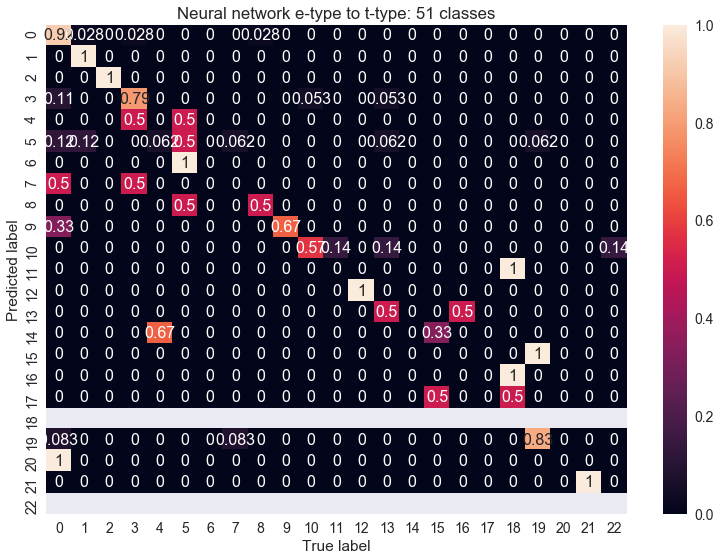

In [114]:

model_e2t_level_4=ephys_to_t_type_net(ephys_human_scaled,level_4_label,num_classes=51,out_layer=51)


### Level 4: random forest

Could not stratify classes
Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.09166666666666666

Random forest, important features:
upstroke_downstroke_ratio_long_square
threshold_i_short_square
upstroke_downstroke_ratio_short_square
ri
tau



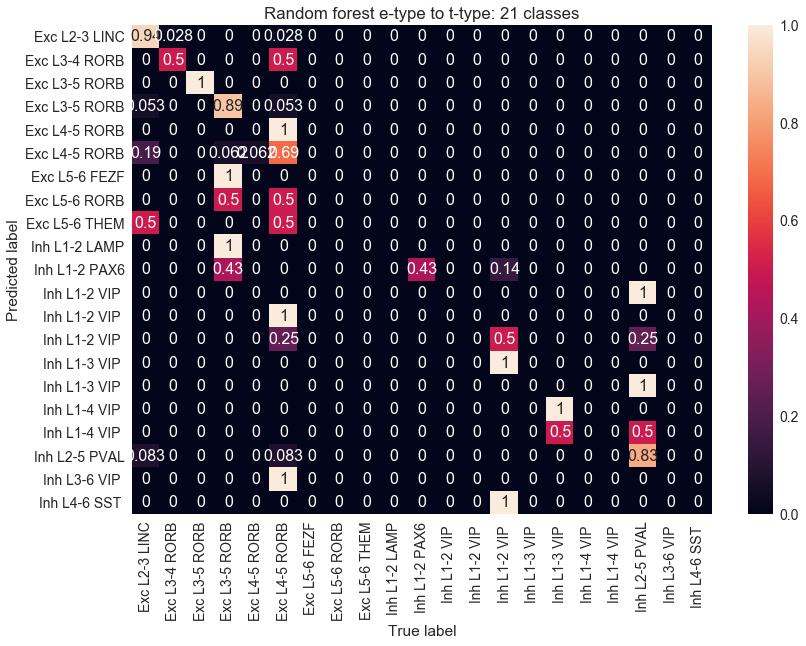

In [115]:

random_forest_plot(ephys_human_scaled,level_4_label,'Level 2', feature_names,num_classes=51,use_resampling=False)


### Level 4: SVM

Could not stratify classes
SVM precision: 0.5666666666666667
SVM random precision: 0.18333333333333332

SVM f1 score: 0.5666666666666667
SVM f1 random score: 0.18333333333333332


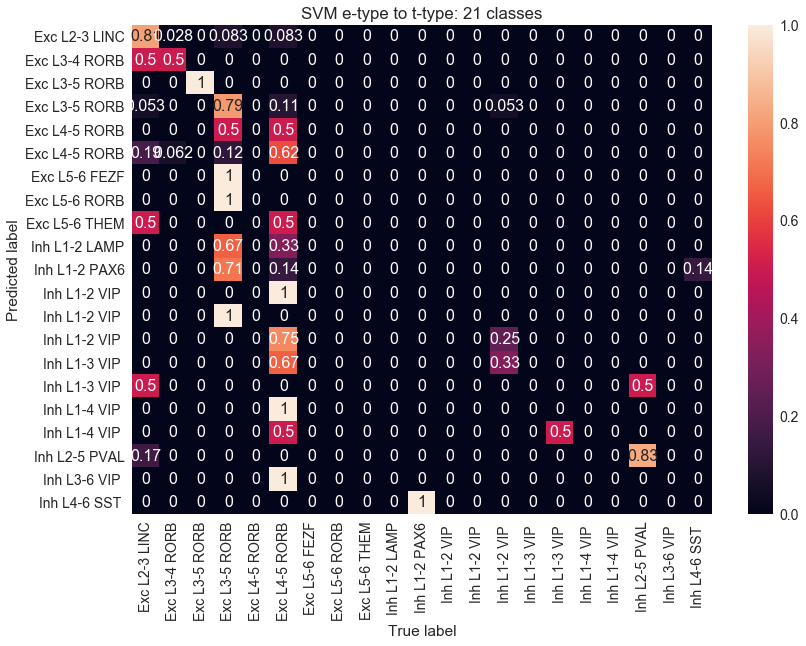

In [116]:

svm_analysis(ephys_human_scaled, level_4_label, 'Level 4', feature_names, num_classes=52, use_resampling=False)


# Predict ephys features based on t-type

## Make the classifier to predict ephys features

### Level 1: 2 types to ephys (40 best features)

In [117]:
print('Number of classes')
print(str(level_1_one_hot.shape[1]))

Number of classes
2


In [118]:

# learn first 20 features

f_start=0
f_end=10

x_train, x_test, y_train, y_test = train_test_split(level_1_one_hot, ephys_human_scaled_best[:,f_start:f_end], test_size=0.20)

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=2))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(f_end-f_start, activation='linear'))

ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error',
              optimizer=ADAM,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=2500,
          batch_size=256)

score = model.evaluate(x_test, y_test, batch_size=256)


Epoch 1/2500
476/476 [==============================] - 1s 1ms/step - loss: 0.5824 - acc: 0.2248
Epoch 2/2500
476/476 [==============================] - 0s 20us/step - loss: 0.5508 - acc: 0.3277
Epoch 3/2500
476/476 [==============================] - 0s 21us/step - loss: 0.5233 - acc: 0.3277
Epoch 4/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4959 - acc: 0.3277
Epoch 5/2500
476/476 [==============================] - 0s 20us/step - loss: 0.4696 - acc: 0.3298
Epoch 6/2500
476/476 [==============================] - 0s 20us/step - loss: 0.4473 - acc: 0.3256
Epoch 7/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4404 - acc: 0.3235
Epoch 8/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4455 - acc: 0.3004
Epoch 9/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4422 - acc: 0.2752
Epoch 10/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4384 - acc: 0.2878
Epoch 11/2500
476/47

476/476 [==============================] - 0s 22us/step - loss: 0.4305 - acc: 0.3214
Epoch 166/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4307 - acc: 0.3340
Epoch 167/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4308 - acc: 0.3172
Epoch 168/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4304 - acc: 0.3193
Epoch 169/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4301 - acc: 0.3277
Epoch 170/2500
476/476 [==============================] - 0s 21us/step - loss: 0.4303 - acc: 0.3235
Epoch 171/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4330 - acc: 0.3256
Epoch 172/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4292 - acc: 0.3235
Epoch 173/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4322 - acc: 0.3193
Epoch 174/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4310 - acc: 0.3151
Epoch 175/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4301 - acc: 0.3319
Epoch 248/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4303 - acc: 0.3298
Epoch 249/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4317 - acc: 0.3193
Epoch 250/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4327 - acc: 0.3235
Epoch 251/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4300 - acc: 0.3277
Epoch 252/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4292 - acc: 0.3172
Epoch 253/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4282 - acc: 0.3256
Epoch 254/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4300 - acc: 0.3172
Epoch 255/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4323 - acc: 0.3256
Epoch 256/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4295 - acc: 0.3256
Epoch 257/2500


476/476 [==============================] - 0s 24us/step - loss: 0.4295 - acc: 0.3277
Epoch 330/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4297 - acc: 0.3214
Epoch 331/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4304 - acc: 0.3193
Epoch 332/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4303 - acc: 0.3277
Epoch 333/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4298 - acc: 0.3235
Epoch 334/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4289 - acc: 0.3277
Epoch 335/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4291 - acc: 0.3235
Epoch 336/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4306 - acc: 0.3235
Epoch 337/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4291 - acc: 0.3277
Epoch 338/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4286 - acc: 0.3235
Epoch 339/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4317 - acc: 0.3298
Epoch 412/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4297 - acc: 0.3298
Epoch 413/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3235
Epoch 414/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4285 - acc: 0.3298
Epoch 415/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4284 - acc: 0.3235
Epoch 416/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3214
Epoch 417/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4301 - acc: 0.3319
Epoch 418/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4300 - acc: 0.3256
Epoch 419/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4307 - acc: 0.3256
Epoch 420/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4272 - acc: 0.3298
Epoch 421/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4296 - acc: 0.3298
Epoch 494/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4304 - acc: 0.3298
Epoch 495/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4287 - acc: 0.3340
Epoch 496/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4289 - acc: 0.3298
Epoch 497/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4292 - acc: 0.3298
Epoch 498/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4293 - acc: 0.3277
Epoch 499/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4302 - acc: 0.3298
Epoch 500/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3277
Epoch 501/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4292 - acc: 0.3298
Epoch 502/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4291 - acc: 0.3277
Epoch 503/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4302 - acc: 0.3319
Epoch 576/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4294 - acc: 0.3277
Epoch 577/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4283 - acc: 0.3298
Epoch 578/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 579/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4288 - acc: 0.3298
Epoch 580/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4289 - acc: 0.3298
Epoch 581/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4307 - acc: 0.3277
Epoch 582/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4292 - acc: 0.3298
Epoch 583/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4284 - acc: 0.3298
Epoch 584/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4293 - acc: 0.3277
Epoch 585/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4308 - acc: 0.3277
Epoch 658/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4287 - acc: 0.3277
Epoch 659/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4316 - acc: 0.3298
Epoch 660/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4294 - acc: 0.3298
Epoch 661/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4304 - acc: 0.3298
Epoch 662/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4303 - acc: 0.3298
Epoch 663/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4283 - acc: 0.3277
Epoch 664/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4283 - acc: 0.3298
Epoch 665/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4305 - acc: 0.3319
Epoch 666/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4283 - acc: 0.3256
Epoch 667/2500


476/476 [==============================] - 0s 29us/step - loss: 0.4297 - acc: 0.3298
Epoch 740/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4306 - acc: 0.3298
Epoch 741/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4279 - acc: 0.3277
Epoch 742/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4277 - acc: 0.3298
Epoch 743/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4312 - acc: 0.3277
Epoch 744/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4288 - acc: 0.3277
Epoch 745/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4298 - acc: 0.3298
Epoch 746/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4296 - acc: 0.3277
Epoch 747/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4307 - acc: 0.3298
Epoch 748/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4284 - acc: 0.3298
Epoch 749/2500


476/476 [==============================] - 0s 28us/step - loss: 0.4284 - acc: 0.3298
Epoch 822/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4293 - acc: 0.3298
Epoch 823/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4303 - acc: 0.3277
Epoch 824/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4295 - acc: 0.3235
Epoch 825/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4295 - acc: 0.3298
Epoch 826/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4296 - acc: 0.3298
Epoch 827/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4295 - acc: 0.3319
Epoch 828/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4291 - acc: 0.3298
Epoch 829/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4306 - acc: 0.3277
Epoch 830/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 831/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4283 - acc: 0.3298
Epoch 904/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4311 - acc: 0.3298
Epoch 905/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4310 - acc: 0.3277
Epoch 906/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4304 - acc: 0.3277
Epoch 907/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4298 - acc: 0.3298
Epoch 908/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4281 - acc: 0.3277
Epoch 909/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.3298
Epoch 910/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4299 - acc: 0.3319
Epoch 911/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4294 - acc: 0.3298
Epoch 912/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4289 - acc: 0.3298
Epoch 913/2500


476/476 [==============================] - 0s 31us/step - loss: 0.4278 - acc: 0.3298
Epoch 986/2500
476/476 [==============================] - 0s 31us/step - loss: 0.4297 - acc: 0.3298
Epoch 987/2500
476/476 [==============================] - 0s 32us/step - loss: 0.4286 - acc: 0.3298
Epoch 988/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.3298
Epoch 989/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4289 - acc: 0.3298
Epoch 990/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4295 - acc: 0.3298
Epoch 991/2500
476/476 [==============================] - 0s 31us/step - loss: 0.4305 - acc: 0.3298
Epoch 992/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4314 - acc: 0.3298
Epoch 993/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4303 - acc: 0.3298
Epoch 994/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4299 - acc: 0.3298
Epoch 995/2500


476/476 [==============================] - 0s 34us/step - loss: 0.4282 - acc: 0.3298
Epoch 1148/2500
476/476 [==============================] - 0s 31us/step - loss: 0.4289 - acc: 0.3298
Epoch 1149/2500
476/476 [==============================] - 0s 38us/step - loss: 0.4306 - acc: 0.3298
Epoch 1150/2500
476/476 [==============================] - 0s 43us/step - loss: 0.4295 - acc: 0.3298
Epoch 1151/2500
476/476 [==============================] - 0s 39us/step - loss: 0.4299 - acc: 0.3298
Epoch 1152/2500
476/476 [==============================] - 0s 37us/step - loss: 0.4270 - acc: 0.3298
Epoch 1153/2500
476/476 [==============================] - 0s 39us/step - loss: 0.4290 - acc: 0.3298
Epoch 1154/2500
476/476 [==============================] - 0s 37us/step - loss: 0.4292 - acc: 0.3298
Epoch 1155/2500
476/476 [==============================] - 0s 44us/step - loss: 0.4289 - acc: 0.3298
Epoch 1156/2500
476/476 [==============================] - 0s 34us/step - loss: 0.4302 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.4293 - acc: 0.3298
Epoch 1310/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4304 - acc: 0.3298
Epoch 1311/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4304 - acc: 0.3298
Epoch 1312/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4294 - acc: 0.3298
Epoch 1313/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4287 - acc: 0.3298
Epoch 1314/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4299 - acc: 0.3298
Epoch 1315/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4301 - acc: 0.3298
Epoch 1316/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4301 - acc: 0.3298
Epoch 1317/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4291 - acc: 0.3298
Epoch 1318/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4299 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.4293 - acc: 0.3298
Epoch 1472/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4309 - acc: 0.3298
Epoch 1473/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4308 - acc: 0.3298
Epoch 1474/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4295 - acc: 0.3298
Epoch 1475/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4279 - acc: 0.3298
Epoch 1476/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4281 - acc: 0.3298
Epoch 1477/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4292 - acc: 0.3298
Epoch 1478/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.3298
Epoch 1479/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4288 - acc: 0.3298
Epoch 1480/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4280 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 26us/step - loss: 0.4289 - acc: 0.3298
Epoch 1634/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4294 - acc: 0.3298
Epoch 1635/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4304 - acc: 0.3298
Epoch 1636/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4291 - acc: 0.3298
Epoch 1637/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4295 - acc: 0.3298
Epoch 1638/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4288 - acc: 0.3298
Epoch 1639/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4286 - acc: 0.3298
Epoch 1640/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4300 - acc: 0.3298
Epoch 1641/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4303 - acc: 0.3298
Epoch 1642/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4291 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 30us/step - loss: 0.4300 - acc: 0.3298
Epoch 1796/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4301 - acc: 0.3298
Epoch 1797/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4294 - acc: 0.3298
Epoch 1798/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4299 - acc: 0.3298
Epoch 1799/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4282 - acc: 0.3298
Epoch 1800/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4305 - acc: 0.3298
Epoch 1801/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.3298
Epoch 1802/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4312 - acc: 0.3298
Epoch 1803/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4285 - acc: 0.3298
Epoch 1804/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4282 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.4292 - acc: 0.3298
Epoch 1958/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4285 - acc: 0.3298
Epoch 1959/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4293 - acc: 0.3298
Epoch 1960/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4295 - acc: 0.3298
Epoch 1961/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4313 - acc: 0.3298
Epoch 1962/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4285 - acc: 0.3298
Epoch 1963/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4274 - acc: 0.3298
Epoch 1964/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 1965/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4287 - acc: 0.3298
Epoch 1966/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4298 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.4293 - acc: 0.3298
Epoch 2120/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4293 - acc: 0.3298
Epoch 2121/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4280 - acc: 0.3298
Epoch 2122/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 2123/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4297 - acc: 0.3298
Epoch 2124/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 2125/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4306 - acc: 0.3298
Epoch 2126/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4281 - acc: 0.3298
Epoch 2127/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4282 - acc: 0.3298
Epoch 2128/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4290 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.4287 - acc: 0.3298
Epoch 2282/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4297 - acc: 0.3298
Epoch 2283/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4285 - acc: 0.3298
Epoch 2284/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4301 - acc: 0.3298
Epoch 2285/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4292 - acc: 0.3298
Epoch 2286/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4290 - acc: 0.3298
Epoch 2287/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4297 - acc: 0.3298
Epoch 2288/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4296 - acc: 0.3298
Epoch 2289/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4288 - acc: 0.3298
Epoch 2290/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4295 - acc: 0.3298
Epoch 

476/476 [==============================] - 0s 29us/step - loss: 0.4286 - acc: 0.3298
Epoch 2444/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4294 - acc: 0.3298
Epoch 2445/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4292 - acc: 0.3298
Epoch 2446/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4282 - acc: 0.3298
Epoch 2447/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4305 - acc: 0.3298
Epoch 2448/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4287 - acc: 0.3298
Epoch 2449/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4295 - acc: 0.3298
Epoch 2450/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4285 - acc: 0.3298
Epoch 2451/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4284 - acc: 0.3298
Epoch 2452/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4298 - acc: 0.3298
Epoch 

### Level 2: 4 types to ephys (20 best features)

In [119]:
print('Number of classes')
print(str(level_2_one_hot.shape[1]))

Number of classes
4


In [120]:

# learn first 20 features

f_start=0
f_end=10

x_train, x_test, y_train, y_test = train_test_split(level_2_one_hot, ephys_human_scaled_best[:,f_start:f_end], test_size=0.20)

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=level_2_one_hot.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(f_end-f_start, activation='linear'))

ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error',
              optimizer=ADAM,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=2500,
          batch_size=256)

score = model.evaluate(x_test, y_test, batch_size=256)


Epoch 1/2500
476/476 [==============================] - 1s 1ms/step - loss: 0.5914 - acc: 0.0756
Epoch 2/2500
476/476 [==============================] - 0s 24us/step - loss: 0.5591 - acc: 0.1408
Epoch 3/2500
476/476 [==============================] - 0s 22us/step - loss: 0.5285 - acc: 0.2878
Epoch 4/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4970 - acc: 0.3172
Epoch 5/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4647 - acc: 0.3571
Epoch 6/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4412 - acc: 0.3655
Epoch 7/2500
476/476 [==============================] - 0s 22us/step - loss: 0.4246 - acc: 0.3529
Epoch 8/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4261 - acc: 0.3466
Epoch 9/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4248 - acc: 0.3256
Epoch 10/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4213 - acc: 0.3445
Epoch 11/2500
476/47

476/476 [==============================] - 0s 24us/step - loss: 0.4111 - acc: 0.3676
Epoch 166/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4059 - acc: 0.3655
Epoch 167/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4091 - acc: 0.3676
Epoch 168/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4072 - acc: 0.3676
Epoch 169/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4073 - acc: 0.3697
Epoch 170/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4101 - acc: 0.3676
Epoch 171/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4092 - acc: 0.3676
Epoch 172/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4088 - acc: 0.3655
Epoch 173/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4092 - acc: 0.3676
Epoch 174/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4091 - acc: 0.3676
Epoch 175/2500


476/476 [==============================] - 0s 24us/step - loss: 0.4093 - acc: 0.3676
Epoch 248/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4076 - acc: 0.3676
Epoch 249/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4083 - acc: 0.3697
Epoch 250/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4074 - acc: 0.3676
Epoch 251/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4097 - acc: 0.3676
Epoch 252/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4089 - acc: 0.3676
Epoch 253/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4078 - acc: 0.3676
Epoch 254/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4094 - acc: 0.3676
Epoch 255/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4091 - acc: 0.3676
Epoch 256/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4072 - acc: 0.3676
Epoch 257/2500


476/476 [==============================] - 0s 24us/step - loss: 0.4092 - acc: 0.3676
Epoch 330/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4073 - acc: 0.3676
Epoch 331/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4078 - acc: 0.3676
Epoch 332/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4100 - acc: 0.3676
Epoch 333/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4077 - acc: 0.3676
Epoch 334/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4084 - acc: 0.3676
Epoch 335/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4081 - acc: 0.3676
Epoch 336/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4066 - acc: 0.3676
Epoch 337/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4099 - acc: 0.3676
Epoch 338/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4068 - acc: 0.3676
Epoch 339/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4079 - acc: 0.3676
Epoch 412/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4082 - acc: 0.3676
Epoch 413/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4073 - acc: 0.3676
Epoch 414/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4081 - acc: 0.3676
Epoch 415/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4087 - acc: 0.3676
Epoch 416/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4083 - acc: 0.3676
Epoch 417/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4047 - acc: 0.3676
Epoch 418/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4064 - acc: 0.3676
Epoch 419/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4088 - acc: 0.3676
Epoch 420/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4098 - acc: 0.3676
Epoch 421/2500


476/476 [==============================] - 0s 25us/step - loss: 0.4079 - acc: 0.3676
Epoch 494/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4079 - acc: 0.3676
Epoch 495/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4069 - acc: 0.3676
Epoch 496/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4076 - acc: 0.3676
Epoch 497/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4088 - acc: 0.3676
Epoch 498/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4080 - acc: 0.3676
Epoch 499/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4074 - acc: 0.3676
Epoch 500/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4080 - acc: 0.3676
Epoch 501/2500
476/476 [==============================] - 0s 31us/step - loss: 0.4065 - acc: 0.3676
Epoch 502/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4077 - acc: 0.3676
Epoch 503/2500


476/476 [==============================] - 0s 28us/step - loss: 0.4086 - acc: 0.3676
Epoch 576/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4064 - acc: 0.3676
Epoch 577/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4062 - acc: 0.3676
Epoch 578/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4072 - acc: 0.3676
Epoch 579/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4090 - acc: 0.3676
Epoch 580/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4078 - acc: 0.3676
Epoch 581/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.3676
Epoch 582/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4065 - acc: 0.3676
Epoch 583/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4091 - acc: 0.3676
Epoch 584/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4072 - acc: 0.3676
Epoch 585/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4071 - acc: 0.3676
Epoch 658/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4066 - acc: 0.3676
Epoch 659/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4083 - acc: 0.3676
Epoch 660/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4061 - acc: 0.3676
Epoch 661/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4091 - acc: 0.3676
Epoch 662/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4088 - acc: 0.3676
Epoch 663/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4076 - acc: 0.3676
Epoch 664/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4078 - acc: 0.3676
Epoch 665/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4095 - acc: 0.3676
Epoch 666/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4084 - acc: 0.3676
Epoch 667/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4091 - acc: 0.3676
Epoch 740/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4070 - acc: 0.3676
Epoch 741/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4073 - acc: 0.3676
Epoch 742/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4084 - acc: 0.3676
Epoch 743/2500
476/476 [==============================] - 0s 31us/step - loss: 0.4074 - acc: 0.3676
Epoch 744/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4067 - acc: 0.3676
Epoch 745/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4065 - acc: 0.3676
Epoch 746/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4069 - acc: 0.3676
Epoch 747/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4070 - acc: 0.3676
Epoch 748/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4073 - acc: 0.3676
Epoch 749/2500


476/476 [==============================] - 0s 28us/step - loss: 0.4079 - acc: 0.3676
Epoch 822/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4078 - acc: 0.3676
Epoch 823/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4071 - acc: 0.3676
Epoch 824/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4080 - acc: 0.3676
Epoch 825/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4068 - acc: 0.3676
Epoch 826/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4067 - acc: 0.3676
Epoch 827/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4070 - acc: 0.3676
Epoch 828/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4086 - acc: 0.3676
Epoch 829/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4088 - acc: 0.3676
Epoch 830/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4071 - acc: 0.3676
Epoch 831/2500


476/476 [==============================] - 0s 27us/step - loss: 0.4081 - acc: 0.3676
Epoch 904/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4090 - acc: 0.3676
Epoch 905/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4061 - acc: 0.3676
Epoch 906/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4090 - acc: 0.3676
Epoch 907/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4068 - acc: 0.3676
Epoch 908/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4087 - acc: 0.3676
Epoch 909/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4081 - acc: 0.3676
Epoch 910/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4061 - acc: 0.3676
Epoch 911/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4076 - acc: 0.3676
Epoch 912/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4075 - acc: 0.3676
Epoch 913/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4076 - acc: 0.3676
Epoch 986/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4084 - acc: 0.3676
Epoch 987/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4068 - acc: 0.3676
Epoch 988/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4082 - acc: 0.3676
Epoch 989/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4087 - acc: 0.3676
Epoch 990/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4084 - acc: 0.3676
Epoch 991/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.3676
Epoch 992/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4077 - acc: 0.3676
Epoch 993/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4070 - acc: 0.3676
Epoch 994/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4071 - acc: 0.3676
Epoch 995/2500


476/476 [==============================] - 0s 26us/step - loss: 0.4072 - acc: 0.3676
Epoch 1067/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4078 - acc: 0.3676
Epoch 1068/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4092 - acc: 0.3676
Epoch 1069/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4069 - acc: 0.3676
Epoch 1070/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4063 - acc: 0.3676
Epoch 1071/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.3676
Epoch 1072/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4056 - acc: 0.3676
Epoch 1073/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4081 - acc: 0.3676
Epoch 1074/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4074 - acc: 0.3676
Epoch 1075/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4070 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 29us/step - loss: 0.4075 - acc: 0.3676
Epoch 1229/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4072 - acc: 0.3676
Epoch 1230/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4091 - acc: 0.3676
Epoch 1231/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4062 - acc: 0.3676
Epoch 1232/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4069 - acc: 0.3676
Epoch 1233/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4071 - acc: 0.3676
Epoch 1234/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4056 - acc: 0.3676
Epoch 1235/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.3676
Epoch 1236/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4094 - acc: 0.3676
Epoch 1237/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4068 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 26us/step - loss: 0.4071 - acc: 0.3676
Epoch 1391/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4067 - acc: 0.3676
Epoch 1392/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4088 - acc: 0.3676
Epoch 1393/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4094 - acc: 0.3676
Epoch 1394/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4068 - acc: 0.3676
Epoch 1395/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4062 - acc: 0.3676
Epoch 1396/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4074 - acc: 0.3676
Epoch 1397/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4098 - acc: 0.3676
Epoch 1398/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4060 - acc: 0.3676
Epoch 1399/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4077 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 29us/step - loss: 0.4074 - acc: 0.3676
Epoch 1553/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4068 - acc: 0.3676
Epoch 1554/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4067 - acc: 0.3676
Epoch 1555/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4063 - acc: 0.3676
Epoch 1556/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4059 - acc: 0.3676
Epoch 1557/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4051 - acc: 0.3676
Epoch 1558/2500
476/476 [==============================] - 0s 30us/step - loss: 0.4083 - acc: 0.3676
Epoch 1559/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4058 - acc: 0.3676
Epoch 1560/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4072 - acc: 0.3676
Epoch 1561/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4065 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.4078 - acc: 0.3676
Epoch 1715/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4075 - acc: 0.3676
Epoch 1716/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4073 - acc: 0.3676
Epoch 1717/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4074 - acc: 0.3676
Epoch 1718/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4067 - acc: 0.3676
Epoch 1719/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4063 - acc: 0.3676
Epoch 1720/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4082 - acc: 0.3676
Epoch 1721/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4071 - acc: 0.3676
Epoch 1722/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4081 - acc: 0.3676
Epoch 1723/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4086 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 26us/step - loss: 0.4070 - acc: 0.3676
Epoch 1877/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4077 - acc: 0.3676
Epoch 1878/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4080 - acc: 0.3676
Epoch 1879/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4071 - acc: 0.3676
Epoch 1880/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4072 - acc: 0.3676
Epoch 1881/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4072 - acc: 0.3676
Epoch 1882/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4060 - acc: 0.3676
Epoch 1883/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4063 - acc: 0.3676
Epoch 1884/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4087 - acc: 0.3676
Epoch 1885/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4070 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 30us/step - loss: 0.4062 - acc: 0.3676
Epoch 2038/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4088 - acc: 0.3676
Epoch 2039/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4076 - acc: 0.3676
Epoch 2040/2500
476/476 [==============================] - 0s 27us/step - loss: 0.4080 - acc: 0.3676
Epoch 2041/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4068 - acc: 0.3676
Epoch 2042/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4088 - acc: 0.3676
Epoch 2043/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4069 - acc: 0.3676
Epoch 2044/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4081 - acc: 0.3676
Epoch 2045/2500
476/476 [==============================] - 0s 29us/step - loss: 0.4070 - acc: 0.3676
Epoch 2046/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4072 - acc: 0.3676
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.4071 - acc: 0.3676
Epoch 2200/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4084 - acc: 0.3676
Epoch 2201/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4093 - acc: 0.3676
Epoch 2202/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4072 - acc: 0.3676
Epoch 2203/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4069 - acc: 0.3676
Epoch 2204/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4058 - acc: 0.3676
Epoch 2205/2500
476/476 [==============================] - ETA: 0s - loss: 0.4241 - acc: 0.371 - 0s 26us/step - loss: 0.4055 - acc: 0.3676
Epoch 2206/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4071 - acc: 0.3676
Epoch 2207/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4051 - acc: 0.3676
Epoch 2208/2500
476/476 [==============================] - 0s 26us/st

476/476 [==============================] - 0s 26us/step - loss: 0.4064 - acc: 0.3676
Epoch 2361/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4085 - acc: 0.3676
Epoch 2362/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4068 - acc: 0.3676
Epoch 2363/2500
476/476 [==============================] - 0s 28us/step - loss: 0.4088 - acc: 0.3676
Epoch 2364/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4090 - acc: 0.3676
Epoch 2365/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4069 - acc: 0.3676
Epoch 2366/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4085 - acc: 0.3676
Epoch 2367/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4067 - acc: 0.3676
Epoch 2368/2500
476/476 [==============================] - 0s 26us/step - loss: 0.4086 - acc: 0.3676
Epoch 2369/2500
476/476 [==============================] - 0s 25us/step - loss: 0.4062 - acc: 0.3676
Epoch 

## Level 3: 6 types to ephys (10 best features)

In [121]:
print('Number of classes')
print(str(level_3_one_hot.shape[1]))

Number of classes
6


In [122]:

# learn first 20 features

f_start=0
f_end=10

x_train, x_test, y_train, y_test = train_test_split(level_3_one_hot, ephys_human_scaled_best[:,f_start:f_end], test_size=0.20)

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=level_3_one_hot.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(f_end-f_start, activation='linear'))

ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error',
              optimizer=ADAM,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=2500,
          batch_size=256)

score = model.evaluate(x_test, y_test, batch_size=256)


Epoch 1/2500
476/476 [==============================] - 1s 1ms/step - loss: 0.5804 - acc: 0.2332
Epoch 2/2500
476/476 [==============================] - 0s 25us/step - loss: 0.5483 - acc: 0.3382
Epoch 3/2500
476/476 [==============================] - 0s 24us/step - loss: 0.5193 - acc: 0.3424
Epoch 4/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4886 - acc: 0.3445
Epoch 5/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4560 - acc: 0.3445
Epoch 6/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4284 - acc: 0.3382
Epoch 7/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4173 - acc: 0.3319
Epoch 8/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4149 - acc: 0.3025
Epoch 9/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4136 - acc: 0.2836
Epoch 10/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4083 - acc: 0.2920
Epoch 11/2500
476/47

476/476 [==============================] - 0s 24us/step - loss: 0.3940 - acc: 0.3508
Epoch 166/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3941 - acc: 0.3445
Epoch 167/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3951 - acc: 0.3445
Epoch 168/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3947 - acc: 0.3445
Epoch 169/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3953 - acc: 0.3382
Epoch 170/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3962 - acc: 0.3319
Epoch 171/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3934 - acc: 0.3508
Epoch 172/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3950 - acc: 0.3424
Epoch 173/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3929 - acc: 0.3508
Epoch 174/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3926 - acc: 0.3487
Epoch 175/2500


476/476 [==============================] - 0s 26us/step - loss: 0.3933 - acc: 0.3466
Epoch 248/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3934 - acc: 0.3403
Epoch 249/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3951 - acc: 0.3361
Epoch 250/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3940 - acc: 0.3487
Epoch 251/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3941 - acc: 0.3487
Epoch 252/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3934 - acc: 0.3445
Epoch 253/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3931 - acc: 0.3403
Epoch 254/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3927 - acc: 0.3466
Epoch 255/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3941 - acc: 0.3466
Epoch 256/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3946 - acc: 0.3445
Epoch 257/2500


476/476 [==============================] - 0s 26us/step - loss: 0.3925 - acc: 0.3466
Epoch 330/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3952 - acc: 0.3466
Epoch 331/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3933 - acc: 0.3466
Epoch 332/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3939 - acc: 0.3466
Epoch 333/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3946 - acc: 0.3424
Epoch 334/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3939 - acc: 0.3466
Epoch 335/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3930 - acc: 0.3424
Epoch 336/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3943 - acc: 0.3508
Epoch 337/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3949 - acc: 0.3466
Epoch 338/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3928 - acc: 0.3487
Epoch 339/2500


476/476 [==============================] - 0s 25us/step - loss: 0.3942 - acc: 0.3487
Epoch 412/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3930 - acc: 0.3487
Epoch 413/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3928 - acc: 0.3487
Epoch 414/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3934 - acc: 0.3466
Epoch 415/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3929 - acc: 0.3487
Epoch 416/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3922 - acc: 0.3487
Epoch 417/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3937 - acc: 0.3487
Epoch 418/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3932 - acc: 0.3487
Epoch 419/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3942 - acc: 0.3487
Epoch 420/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3937 - acc: 0.3487
Epoch 421/2500


476/476 [==============================] - 0s 29us/step - loss: 0.3926 - acc: 0.3487
Epoch 494/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3923 - acc: 0.3487
Epoch 495/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3958 - acc: 0.3487
Epoch 496/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3949 - acc: 0.3487
Epoch 497/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3945 - acc: 0.3487
Epoch 498/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3932 - acc: 0.3487
Epoch 499/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3922 - acc: 0.3487
Epoch 500/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3922 - acc: 0.3487
Epoch 501/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3935 - acc: 0.3508
Epoch 502/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3937 - acc: 0.3487
Epoch 503/2500


476/476 [==============================] - 0s 26us/step - loss: 0.3923 - acc: 0.3487
Epoch 576/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3936 - acc: 0.3487
Epoch 577/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3930 - acc: 0.3487
Epoch 578/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3926 - acc: 0.3487
Epoch 579/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3926 - acc: 0.3487
Epoch 580/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3927 - acc: 0.3487
Epoch 581/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3944 - acc: 0.3508
Epoch 582/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3941 - acc: 0.3487
Epoch 583/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3934 - acc: 0.3487
Epoch 584/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3940 - acc: 0.3508
Epoch 585/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3912 - acc: 0.3487
Epoch 658/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3935 - acc: 0.3487
Epoch 659/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3945 - acc: 0.3487
Epoch 660/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3937 - acc: 0.3487
Epoch 661/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3920 - acc: 0.3487
Epoch 662/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3925 - acc: 0.3487
Epoch 663/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3933 - acc: 0.3487
Epoch 664/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3933 - acc: 0.3487
Epoch 665/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3916 - acc: 0.3487
Epoch 666/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3931 - acc: 0.3487
Epoch 667/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3927 - acc: 0.3487
Epoch 740/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3916 - acc: 0.3487
Epoch 741/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3937 - acc: 0.3487
Epoch 742/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3921 - acc: 0.3487
Epoch 743/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3935 - acc: 0.3487
Epoch 744/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3929 - acc: 0.3487
Epoch 745/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3920 - acc: 0.3487
Epoch 746/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3926 - acc: 0.3487
Epoch 747/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3928 - acc: 0.3487
Epoch 748/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3933 - acc: 0.3487
Epoch 749/2500


476/476 [==============================] - 0s 28us/step - loss: 0.3939 - acc: 0.3487
Epoch 822/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3921 - acc: 0.3487
Epoch 823/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.3487
Epoch 824/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3921 - acc: 0.3487
Epoch 825/2500
476/476 [==============================] - 0s 33us/step - loss: 0.3930 - acc: 0.3487
Epoch 826/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3941 - acc: 0.3487
Epoch 827/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3936 - acc: 0.3487
Epoch 828/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3934 - acc: 0.3487
Epoch 829/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3947 - acc: 0.3487
Epoch 830/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3930 - acc: 0.3487
Epoch 831/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3938 - acc: 0.3487
Epoch 904/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3933 - acc: 0.3487
Epoch 905/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3927 - acc: 0.3487
Epoch 906/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3937 - acc: 0.3487
Epoch 907/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3935 - acc: 0.3487
Epoch 908/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3957 - acc: 0.3487
Epoch 909/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3921 - acc: 0.3487
Epoch 910/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3930 - acc: 0.3487
Epoch 911/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3915 - acc: 0.3487
Epoch 912/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3937 - acc: 0.3487
Epoch 913/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3940 - acc: 0.3487
Epoch 986/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3937 - acc: 0.3487
Epoch 987/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3915 - acc: 0.3487
Epoch 988/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3941 - acc: 0.3487
Epoch 989/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3942 - acc: 0.3487
Epoch 990/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3919 - acc: 0.3487
Epoch 991/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3937 - acc: 0.3487
Epoch 992/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3916 - acc: 0.3487
Epoch 993/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3934 - acc: 0.3487
Epoch 994/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3927 - acc: 0.3487
Epoch 995/2500


476/476 [==============================] - 0s 26us/step - loss: 0.3939 - acc: 0.3487
Epoch 1148/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3950 - acc: 0.3487
Epoch 1149/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3926 - acc: 0.3487
Epoch 1150/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3914 - acc: 0.3487
Epoch 1151/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3933 - acc: 0.3487
Epoch 1152/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3931 - acc: 0.3487
Epoch 1153/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3948 - acc: 0.3487
Epoch 1154/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3933 - acc: 0.3487
Epoch 1155/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3918 - acc: 0.3487
Epoch 1156/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3937 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3931 - acc: 0.3487
Epoch 1310/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3909 - acc: 0.3487
Epoch 1311/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3928 - acc: 0.3487
Epoch 1312/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3923 - acc: 0.3487
Epoch 1313/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3940 - acc: 0.3487
Epoch 1314/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3927 - acc: 0.3487
Epoch 1315/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3930 - acc: 0.3487
Epoch 1316/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3941 - acc: 0.3487
Epoch 1317/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3926 - acc: 0.3487
Epoch 1318/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3918 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3924 - acc: 0.3487
Epoch 1472/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3911 - acc: 0.3487
Epoch 1473/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3933 - acc: 0.3487
Epoch 1474/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3932 - acc: 0.3487
Epoch 1475/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3928 - acc: 0.3487
Epoch 1476/2500
476/476 [==============================] - 0s 91us/step - loss: 0.3935 - acc: 0.3487
Epoch 1477/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3927 - acc: 0.3487
Epoch 1478/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3920 - acc: 0.3487
Epoch 1479/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3938 - acc: 0.3487
Epoch 1480/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3931 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3940 - acc: 0.3487
Epoch 1634/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3935 - acc: 0.3487
Epoch 1635/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3915 - acc: 0.3508
Epoch 1636/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3918 - acc: 0.3487
Epoch 1637/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3940 - acc: 0.3487
Epoch 1638/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3918 - acc: 0.3487
Epoch 1639/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.3487
Epoch 1640/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3944 - acc: 0.3487
Epoch 1641/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3942 - acc: 0.3487
Epoch 1642/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3923 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.3933 - acc: 0.3487
Epoch 1796/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3915 - acc: 0.3487
Epoch 1797/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3916 - acc: 0.3487
Epoch 1798/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3920 - acc: 0.3487
Epoch 1799/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3925 - acc: 0.3487
Epoch 1800/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3937 - acc: 0.3487
Epoch 1801/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3928 - acc: 0.3487
Epoch 1802/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3919 - acc: 0.3487
Epoch 1803/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3936 - acc: 0.3487
Epoch 1804/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3940 - acc: 0.3487
Epoch 1957/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3935 - acc: 0.3487
Epoch 1958/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3929 - acc: 0.3487
Epoch 1959/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3932 - acc: 0.3487
Epoch 1960/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.3487
Epoch 1961/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3935 - acc: 0.3487
Epoch 1962/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3925 - acc: 0.3487
Epoch 1963/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3930 - acc: 0.3487
Epoch 1964/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3914 - acc: 0.3487
Epoch 1965/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3949 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 29us/step - loss: 0.3923 - acc: 0.3487
Epoch 2119/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3918 - acc: 0.3487
Epoch 2120/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3932 - acc: 0.3487
Epoch 2121/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3933 - acc: 0.3487
Epoch 2122/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3926 - acc: 0.3487
Epoch 2123/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3943 - acc: 0.3487
Epoch 2124/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.3487
Epoch 2125/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3921 - acc: 0.3487
Epoch 2126/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3916 - acc: 0.3487
Epoch 2127/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3936 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 25us/step - loss: 0.3914 - acc: 0.3487
Epoch 2280/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3921 - acc: 0.3487
Epoch 2281/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3945 - acc: 0.3487
Epoch 2282/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3916 - acc: 0.3487
Epoch 2283/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3938 - acc: 0.3487
Epoch 2284/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3956 - acc: 0.3487
Epoch 2285/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3922 - acc: 0.3487
Epoch 2286/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3930 - acc: 0.3487
Epoch 2287/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3921 - acc: 0.3487
Epoch 2288/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3918 - acc: 0.3487
Epoch 

476/476 [==============================] - 0s 26us/step - loss: 0.3932 - acc: 0.3487
Epoch 2442/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3933 - acc: 0.3487
Epoch 2443/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3920 - acc: 0.3487
Epoch 2444/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3939 - acc: 0.3487
Epoch 2445/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3933 - acc: 0.3487
Epoch 2446/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3938 - acc: 0.3487
Epoch 2447/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3932 - acc: 0.3487
Epoch 2448/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3927 - acc: 0.3487
Epoch 2449/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3934 - acc: 0.3487
Epoch 2450/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3924 - acc: 0.3487
Epoch 

### Level 4: 50 types to ephys (10 best features)

In [123]:

print('Number of classes')
print(str(level_4_one_hot.shape[1]))


Number of classes
31


In [124]:

# learn first 20 features

f_start=0
f_end=10

x_train, x_test, y_train, y_test = train_test_split(level_4_one_hot, ephys_human_scaled_best[:,f_start:f_end], test_size=0.20)

model = Sequential()

model.add(Dense(64, activation='relu', input_dim=level_4_one_hot.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(f_end-f_start, activation='linear'))

ADAM = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error',
              optimizer=ADAM,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=2500,
          batch_size=256)

score = model.evaluate(x_test, y_test, batch_size=256)


Epoch 1/2500
476/476 [==============================] - 1s 2ms/step - loss: 0.5877 - acc: 0.1513
Epoch 2/2500
476/476 [==============================] - 0s 23us/step - loss: 0.5629 - acc: 0.1933
Epoch 3/2500
476/476 [==============================] - 0s 23us/step - loss: 0.5390 - acc: 0.3088
Epoch 4/2500
476/476 [==============================] - 0s 24us/step - loss: 0.5122 - acc: 0.4034
Epoch 5/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4814 - acc: 0.4223
Epoch 6/2500
476/476 [==============================] - 0s 23us/step - loss: 0.4485 - acc: 0.4307
Epoch 7/2500
476/476 [==============================] - 0s 24us/step - loss: 0.4173 - acc: 0.4412
Epoch 8/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3995 - acc: 0.4517
Epoch 9/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3819 - acc: 0.4454
Epoch 10/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3757 - acc: 0.4349
Epoch 11/2500
476/47

476/476 [==============================] - 0s 25us/step - loss: 0.3110 - acc: 0.4811
Epoch 166/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3131 - acc: 0.4727
Epoch 167/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3108 - acc: 0.4790
Epoch 168/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3135 - acc: 0.4685
Epoch 169/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3137 - acc: 0.4685
Epoch 170/2500
476/476 [==============================] - 0s 42us/step - loss: 0.3153 - acc: 0.4811
Epoch 171/2500
476/476 [==============================] - 0s 35us/step - loss: 0.3136 - acc: 0.4727
Epoch 172/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3117 - acc: 0.4748
Epoch 173/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3141 - acc: 0.4769
Epoch 174/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3143 - acc: 0.4748
Epoch 175/2500


476/476 [==============================] - 0s 25us/step - loss: 0.3132 - acc: 0.4769
Epoch 248/2500
476/476 [==============================] - 0s 23us/step - loss: 0.3137 - acc: 0.4853
Epoch 249/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3137 - acc: 0.4727
Epoch 250/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3120 - acc: 0.4895
Epoch 251/2500
476/476 [==============================] - 0s 24us/step - loss: 0.3114 - acc: 0.4853
Epoch 252/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3137 - acc: 0.4664
Epoch 253/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3117 - acc: 0.4643
Epoch 254/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3147 - acc: 0.4727
Epoch 255/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3142 - acc: 0.4664
Epoch 256/2500
476/476 [==============================] - 0s 25us/step - loss: 0.3149 - acc: 0.4727
Epoch 257/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3139 - acc: 0.4811
Epoch 330/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3129 - acc: 0.4727
Epoch 331/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3152 - acc: 0.4727
Epoch 332/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3129 - acc: 0.4811
Epoch 333/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3141 - acc: 0.4706
Epoch 334/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3107 - acc: 0.4706
Epoch 335/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3103 - acc: 0.4685
Epoch 336/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3097 - acc: 0.4748
Epoch 337/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3103 - acc: 0.4727
Epoch 338/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3128 - acc: 0.4685
Epoch 339/2500


476/476 [==============================] - 0s 25us/step - loss: 0.3128 - acc: 0.4622
Epoch 412/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3091 - acc: 0.4748
Epoch 413/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3137 - acc: 0.4685
Epoch 414/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3136 - acc: 0.4727
Epoch 415/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3121 - acc: 0.4727
Epoch 416/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3102 - acc: 0.4790
Epoch 417/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3140 - acc: 0.4538
Epoch 418/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3123 - acc: 0.4706
Epoch 419/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3123 - acc: 0.4664
Epoch 420/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3136 - acc: 0.4643
Epoch 421/2500


476/476 [==============================] - 0s 29us/step - loss: 0.3129 - acc: 0.4706
Epoch 494/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3123 - acc: 0.4685
Epoch 495/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3118 - acc: 0.4832
Epoch 496/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3144 - acc: 0.4706
Epoch 497/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3135 - acc: 0.4748
Epoch 498/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3117 - acc: 0.4706
Epoch 499/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3099 - acc: 0.4580
Epoch 500/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3113 - acc: 0.4664
Epoch 501/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3115 - acc: 0.4769
Epoch 502/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3100 - acc: 0.4769
Epoch 503/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3141 - acc: 0.4685
Epoch 576/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3121 - acc: 0.4664
Epoch 577/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3126 - acc: 0.4601
Epoch 578/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3135 - acc: 0.4790
Epoch 579/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3115 - acc: 0.4706
Epoch 580/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3139 - acc: 0.4664
Epoch 581/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3105 - acc: 0.4727
Epoch 582/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3111 - acc: 0.4748
Epoch 583/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3122 - acc: 0.4790
Epoch 584/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3122 - acc: 0.4832
Epoch 585/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3131 - acc: 0.4706
Epoch 658/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3093 - acc: 0.4790
Epoch 659/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3116 - acc: 0.4748
Epoch 660/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3104 - acc: 0.4832
Epoch 661/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3115 - acc: 0.4748
Epoch 662/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3102 - acc: 0.4685
Epoch 663/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3105 - acc: 0.4727
Epoch 664/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3114 - acc: 0.4664
Epoch 665/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3117 - acc: 0.4706
Epoch 666/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3122 - acc: 0.4769
Epoch 667/2500


476/476 [==============================] - 0s 30us/step - loss: 0.3114 - acc: 0.4664
Epoch 740/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3133 - acc: 0.4832
Epoch 741/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3110 - acc: 0.4664
Epoch 742/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3090 - acc: 0.4685
Epoch 743/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3123 - acc: 0.4685
Epoch 744/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3102 - acc: 0.4664
Epoch 745/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3112 - acc: 0.4790
Epoch 746/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3116 - acc: 0.4664
Epoch 747/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3124 - acc: 0.4706
Epoch 748/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3110 - acc: 0.4685
Epoch 749/2500


476/476 [==============================] - 0s 28us/step - loss: 0.3104 - acc: 0.4685
Epoch 822/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3115 - acc: 0.4748
Epoch 823/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3111 - acc: 0.4664
Epoch 824/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3098 - acc: 0.4622
Epoch 825/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3109 - acc: 0.4790
Epoch 826/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3103 - acc: 0.4874
Epoch 827/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3113 - acc: 0.4685
Epoch 828/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3116 - acc: 0.4790
Epoch 829/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3119 - acc: 0.4727
Epoch 830/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3134 - acc: 0.4748
Epoch 831/2500


476/476 [==============================] - 0s 27us/step - loss: 0.3105 - acc: 0.4769
Epoch 904/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3113 - acc: 0.4727
Epoch 905/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3105 - acc: 0.4769
Epoch 906/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3120 - acc: 0.4685
Epoch 907/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3134 - acc: 0.4643
Epoch 908/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3122 - acc: 0.4727
Epoch 909/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3104 - acc: 0.4664
Epoch 910/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3123 - acc: 0.4664
Epoch 911/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3115 - acc: 0.4832
Epoch 912/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3105 - acc: 0.4706
Epoch 913/2500


476/476 [==============================] - 0s 28us/step - loss: 0.3119 - acc: 0.4811
Epoch 986/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3123 - acc: 0.4727
Epoch 987/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3126 - acc: 0.4748
Epoch 988/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3117 - acc: 0.4727
Epoch 989/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3110 - acc: 0.4811
Epoch 990/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3116 - acc: 0.4727
Epoch 991/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3104 - acc: 0.4769
Epoch 992/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3139 - acc: 0.4790
Epoch 993/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3118 - acc: 0.4769
Epoch 994/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3113 - acc: 0.4664
Epoch 995/2500


476/476 [==============================] - 0s 26us/step - loss: 0.3120 - acc: 0.4769
Epoch 1148/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3108 - acc: 0.4811
Epoch 1149/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3091 - acc: 0.4769
Epoch 1150/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3134 - acc: 0.4664
Epoch 1151/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3118 - acc: 0.4790
Epoch 1152/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3112 - acc: 0.4811
Epoch 1153/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3070 - acc: 0.4685
Epoch 1154/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3099 - acc: 0.4790
Epoch 1155/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3120 - acc: 0.4685
Epoch 1156/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3106 - acc: 0.4769
Epoch 

476/476 [==============================] - 0s 31us/step - loss: 0.3123 - acc: 0.4727
Epoch 1310/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3124 - acc: 0.4769
Epoch 1311/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3122 - acc: 0.4622
Epoch 1312/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3143 - acc: 0.4769
Epoch 1313/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3091 - acc: 0.4706
Epoch 1314/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3118 - acc: 0.4832
Epoch 1315/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3134 - acc: 0.4769
Epoch 1316/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3095 - acc: 0.4811
Epoch 1317/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3121 - acc: 0.4748
Epoch 1318/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3123 - acc: 0.4853
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.3107 - acc: 0.4685
Epoch 1472/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3111 - acc: 0.4727
Epoch 1473/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3091 - acc: 0.4853
Epoch 1474/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3081 - acc: 0.4685
Epoch 1475/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3104 - acc: 0.4643
Epoch 1476/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3104 - acc: 0.4769
Epoch 1477/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3120 - acc: 0.4748
Epoch 1478/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3110 - acc: 0.4748
Epoch 1479/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3103 - acc: 0.4748
Epoch 1480/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3120 - acc: 0.4706
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3106 - acc: 0.4685
Epoch 1633/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3111 - acc: 0.4790
Epoch 1634/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3095 - acc: 0.4685
Epoch 1635/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3101 - acc: 0.4748
Epoch 1636/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3106 - acc: 0.4706
Epoch 1637/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3113 - acc: 0.4748
Epoch 1638/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3092 - acc: 0.4601
Epoch 1639/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3105 - acc: 0.4727
Epoch 1640/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3120 - acc: 0.4706
Epoch 1641/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3109 - acc: 0.4832
Epoch 

476/476 [==============================] - 0s 28us/step - loss: 0.3122 - acc: 0.4769
Epoch 1794/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3116 - acc: 0.4727
Epoch 1795/2500
476/476 [==============================] - 0s 31us/step - loss: 0.3105 - acc: 0.4811
Epoch 1796/2500
476/476 [==============================] - 0s 32us/step - loss: 0.3113 - acc: 0.4727
Epoch 1797/2500
476/476 [==============================] - 0s 32us/step - loss: 0.3114 - acc: 0.4748
Epoch 1798/2500
476/476 [==============================] - 0s 31us/step - loss: 0.3118 - acc: 0.4748
Epoch 1799/2500
476/476 [==============================] - 0s 31us/step - loss: 0.3116 - acc: 0.4790
Epoch 1800/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3113 - acc: 0.4769
Epoch 1801/2500
476/476 [==============================] - 0s 33us/step - loss: 0.3110 - acc: 0.4643
Epoch 1802/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3103 - acc: 0.4685
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3114 - acc: 0.4643
Epoch 1956/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3105 - acc: 0.4706
Epoch 1957/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3108 - acc: 0.4664
Epoch 1958/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3108 - acc: 0.4769
Epoch 1959/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3131 - acc: 0.4790
Epoch 1960/2500
476/476 [==============================] - 0s 30us/step - loss: 0.3109 - acc: 0.4727
Epoch 1961/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3105 - acc: 0.4664
Epoch 1962/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3116 - acc: 0.4895
Epoch 1963/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3113 - acc: 0.4727
Epoch 1964/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3115 - acc: 0.4664
Epoch 

476/476 [==============================] - 0s 27us/step - loss: 0.3094 - acc: 0.4769
Epoch 2118/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3112 - acc: 0.4727
Epoch 2119/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3110 - acc: 0.4811
Epoch 2120/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3108 - acc: 0.4811
Epoch 2121/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3107 - acc: 0.4685
Epoch 2122/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3112 - acc: 0.4811
Epoch 2123/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3132 - acc: 0.4727
Epoch 2124/2500
476/476 [==============================] - 0s 31us/step - loss: 0.3126 - acc: 0.4664
Epoch 2125/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3114 - acc: 0.4622
Epoch 2126/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3110 - acc: 0.4727
Epoch 

476/476 [==============================] - 0s 51us/step - loss: 0.3092 - acc: 0.4685
Epoch 2280/2500
476/476 [==============================] - 0s 29us/step - loss: 0.3114 - acc: 0.4769
Epoch 2281/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3116 - acc: 0.4769
Epoch 2282/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3129 - acc: 0.4790
Epoch 2283/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3110 - acc: 0.4706
Epoch 2284/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3094 - acc: 0.4790
Epoch 2285/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3121 - acc: 0.4811
Epoch 2286/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3124 - acc: 0.4769
Epoch 2287/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3106 - acc: 0.4790
Epoch 2288/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3116 - acc: 0.4727
Epoch 

476/476 [==============================] - 0s 25us/step - loss: 0.3105 - acc: 0.4769
Epoch 2442/2500
476/476 [==============================] - 0s 28us/step - loss: 0.3094 - acc: 0.4748
Epoch 2443/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3098 - acc: 0.4769
Epoch 2444/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3104 - acc: 0.4706
Epoch 2445/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3104 - acc: 0.4748
Epoch 2446/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3127 - acc: 0.4601
Epoch 2447/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3130 - acc: 0.4685
Epoch 2448/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3093 - acc: 0.4727
Epoch 2449/2500
476/476 [==============================] - 0s 26us/step - loss: 0.3095 - acc: 0.4853
Epoch 2450/2500
476/476 [==============================] - 0s 27us/step - loss: 0.3118 - acc: 0.4790
Epoch 